# Necessary stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Oct 20 08:59:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install -r /content/drive/MyDrive/RGELAN/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00


# RepVGG-GELAN


In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 150 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data /content/drive/MyDrive/RGELAN/data/coco.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/rcs-gelan-c.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml

# Squeeze-and-Excitation Networks

In [ ]:
!pip install timm

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

### Only SEBlocks

In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 5 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data /content/drive/MyDrive/RGELAN/data/coco.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v3.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml

2024-09-17 13:41:21.255789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 13:41:21.276253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 13:41:21.282239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 13:41:21.297341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 13:41:22.489474: W tensorflow/comp

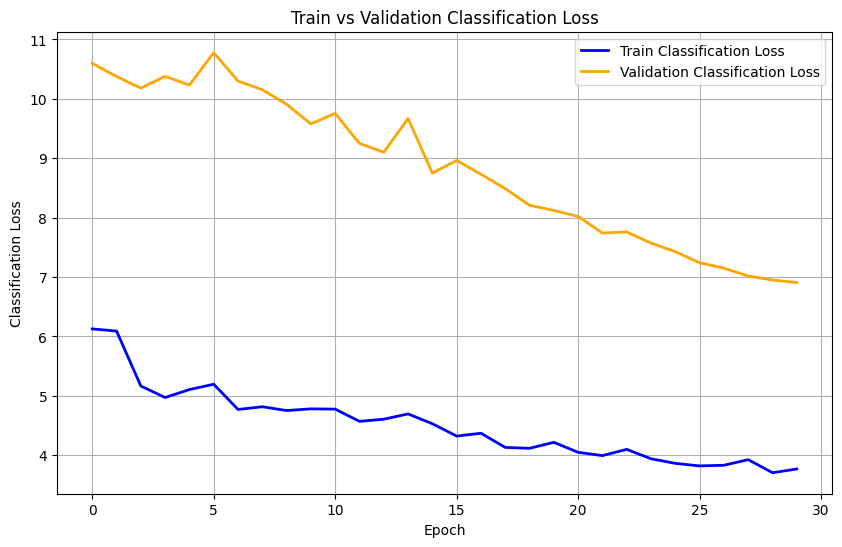

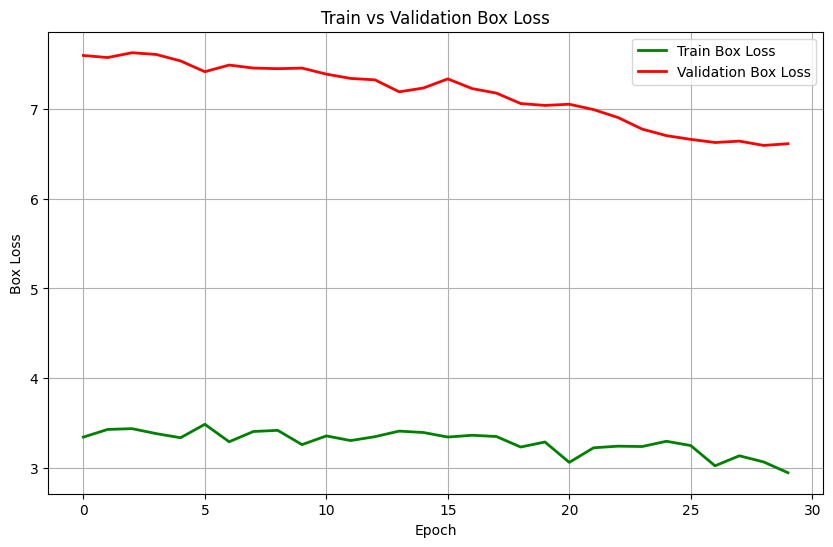

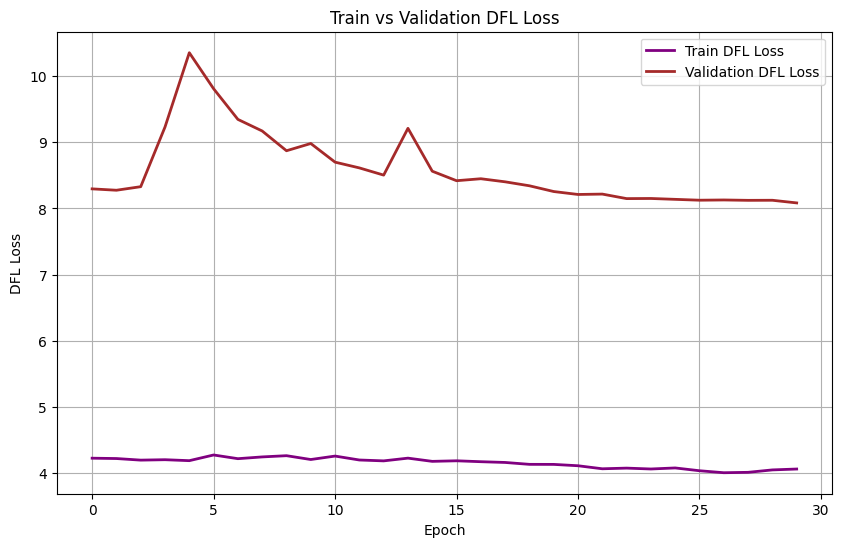

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/exp70/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/cls_loss'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['        val/cls_loss'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/box_loss'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['        val/box_loss'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()


### SEBlocks, Residual Blocks and CBAM

#### Finding optimal number of anchors

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
import yaml

# Load dataset annotations (width, height)
def load_annotations(data_yaml_path):
    # Load data.yaml file to get dataset path
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)

    # Define paths to dataset files
    train_path = data_yaml['train']  # Path to training set
    labels_dir = os.path.join(train_path, 'labels')  # Assuming labels are stored here

    # Gather all width, height pairs of objects
    boxes = []
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    # Assuming YOLO format: class, x_center, y_center, width, height
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        width = float(parts[3])
                        height = float(parts[4])
                        boxes.append([width, height])

    return np.array(boxes)

# Apply K-Means clustering to calculate anchors
def calculate_anchors(boxes, num_anchors):
    kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(boxes)
    return kmeans.cluster_centers_

# Save calculated anchors to a modified copy of your YOLO config
def save_anchors_to_yaml(anchor_boxes, yaml_path):
    with open(yaml_path, 'r') as f:
        model_yaml = yaml.safe_load(f)

    # Update the anchor boxes
    model_yaml['anchors'] = anchor_boxes.tolist()

    # Define the path for the modified YAML file
    base_name, ext = os.path.splitext(yaml_path)
    modified_yaml_path = f"{base_name}_modified{ext}"

    # Save the updated YAML to the new file
    with open(modified_yaml_path, 'w') as f:
        yaml.dump(model_yaml, f)

    return modified_yaml_path

if __name__ == "__main__":
    data_yaml_path = '/content/drive/MyDrive/RGELAN/data/coco.yaml'  # Path to your data.yaml file
    model_yaml_path = '/content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v32.yaml'  # Path to your model config

    num_anchors = 6  # Adjust this based on your architecture

    # Load dataset annotations and calculate anchors
    boxes = load_annotations(data_yaml_path)
    anchors = calculate_anchors(boxes, num_anchors)

    print(f"Calculated anchors: {anchors}")

    # Save anchors to a modified model configuration file
    modified_model_yaml_path = save_anchors_to_yaml(anchors, model_yaml_path)
    print(f"Anchors saved to {modified_model_yaml_path}")


Calculated anchors: [[0.31540816 0.37836735]
 [0.21497207 0.20815642]
 [0.28328859 0.27006711]
 [0.13952756 0.12346457]
 [0.43813953 0.45813953]
 [0.39886364 0.30613636]]
Anchors saved to /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v32_modified.yaml


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 150 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data /content/drive/MyDrive/coco.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v39.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml

2024-10-02 12:15:47.302350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 12:15:47.322086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 12:15:47.328023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 12:15:47.348828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 12:15:49.052284: W tensorflow/compiler/tf2

## 5-Fold Cross-Validation for Br35H

In [ ]:
import os
import yaml
import shutil

In [ ]:
# Define paths
yolov9_path = '/content/drive/MyDrive/RGELAN'  # Update with the path to YOLOv9 directory
custom_yaml_path = '/content/drive/MyDrive/RGELAN/data/coco.yaml'  # Update with the path to custom.yaml
data_path = '/content/drive/MyDrive/Folds'

# Function to create training folders for each fold
def create_train_folders(train_folders, n):
    for idx, folder in enumerate(train_folders):
        train_folder = f'/content/drive/MyDrive/Folds/train{n}'
        os.makedirs(os.path.join(train_folder, 'images'), exist_ok=True)
        os.makedirs(os.path.join(train_folder, 'labels'), exist_ok=True)

        # Copy images and labels from original training folders
        images_src = os.path.join(folder, 'images')
        labels_src = os.path.join(folder, 'labels')

        images_dst = os.path.join(train_folder, 'images')
        labels_dst = os.path.join(train_folder, 'labels')

        for image_file in os.listdir(images_src):
            shutil.copy(os.path.join(images_src, image_file), images_dst)

        for label_file in os.listdir(labels_src):
            shutil.copy(os.path.join(labels_src, label_file), labels_dst)

        # Count images and labels
        num_images = len(os.listdir(images_dst))
        num_labels = len(os.listdir(labels_dst))
    print(f"Train{n} - Images: {num_images}, Labels: {num_labels}")

    return train_folder

# Function to train YOLOv9
def train_yolov9(train_folders, val_folder, fold_idx):
    # Load custom.yaml
    with open(custom_yaml_path, 'r') as file:
        yaml_content = yaml.safe_load(file)

    # Update train and val paths
    yaml_content['path'] = data_path
    yaml_content['train'] = train_folders
    yaml_content['val'] = val_folder

    print(yaml_content['val'])

    # Write the updated YAML content back to the file
    with open(custom_yaml_path, 'w') as file:
        yaml.dump(yaml_content, file)

    !python {yolov9_path}/train.py --img 640 --batch 8 --epochs 150 --min-items 0 --data {custom_yaml_path} --cfg {yolov9_path}/models/detect/ne-rcs-gelan-c-v39.yaml --hyp {yolov9_path}/data/hyps/hyp.scratch-high.yaml --device 0 --name fold{fold_idx} --save-period 20 #--resume /content/drive/MyDrive/RGELAN/runs/train/fold5/weights/epoch440.pt #(you might need to change exp? or epoch_?)

# Get list of fold directories
fold_directories = [f'/content/drive/MyDrive/Folds/fold_{i+1}' for i in range(5)]


In [ ]:
import shutil
p = '/content/drive/MyDrive/Folds/train1'
shutil.rmtree(p)

### Training on Fold 1

In [ ]:
# Fold 1
fold_idx = 0
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)


Training on fold 1...
Train1 - Images: 561, Labels: 561
/content/drive/MyDrive/Folds/train1
/content/drive/MyDrive/Folds/fold_1
2024-10-11 17:11:58.673778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 17:11:58.693182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 17:11:58.698997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 17:11:58.712926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in

### Training on Fold 2

In [ ]:
# Fold 2
fold_idx = 1
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)

Training on fold 2...


KeyboardInterrupt: 

### Training on Fold 3

In [ ]:
# Fold 3
fold_idx = 2
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)


### Training on Fold 4

In [ ]:
# Fold 4
fold_idx = 3
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)


### Training on Fold 5

In [ ]:
# Fold 5
fold_idx = 4
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)

# yolov8 on brain

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 27.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import shutil
import random

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/'

In [ ]:
# Load a model
model = YOLO("yolov8m.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model


Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 4.06MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

train: Scanning /content/drive/MyDrive/Folds/train5/labels... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [07:40<00:00,  1.43it/s]


train: New cache created: /content/drive/MyDrive/Folds/train5/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Folds/fold_5/labels... 15 images, 0 backgrounds, 0 corrupt:  11%|█         | 15/141 [00:10<01:21,  1.54it/s]

In [ ]:
# Load a model
model = YOLO("yolov8s.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model


100%|██████████| 21.5M/21.5M [00:00<00:00, 194MB/s]


New https://pypi.org/project/ultralytics/8.2.87 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.76G      1.215      2.781      1.387          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        141        141      0.589      0.709      0.683      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.55G      1.264      1.338      1.418          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


                   all        141        141      0.235      0.135      0.129     0.0754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.48G      1.239      1.253      1.382          5        640: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


                   all        141        141      0.016      0.546     0.0126    0.00504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.53G      1.326      1.329      1.475          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        141        141      0.184      0.348      0.174     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       4.5G      1.274       1.17      1.384          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.671      0.596      0.616      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.53G      1.193      1.094      1.376          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.739      0.695      0.765      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       4.5G      1.159     0.9995       1.34          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        141        141      0.745      0.702      0.751      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.53G      1.178      1.047      1.321          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


                   all        141        141      0.774      0.681      0.801      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.52G      1.141     0.9712      1.312          9        640: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.842      0.755      0.848      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.52G      1.144     0.9248      1.316          5        640: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        141        141      0.891      0.872      0.907      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.35G       1.15     0.9499      1.312          8        640: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        141        141      0.841      0.753      0.806      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.54G      1.086     0.8971      1.268          6        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141        0.9      0.745      0.838      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150       4.5G      1.132     0.9138      1.305          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        141        141      0.909      0.787      0.895      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.52G      1.071     0.8346      1.269          4        640: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.881      0.841      0.908      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       4.5G      1.024     0.8343      1.224          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


                   all        141        141      0.889      0.908      0.933      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.53G      1.029     0.7972      1.247          6        640: 100%|██████████| 42/42 [00:20<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        141        141      0.879      0.908      0.942       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       4.5G      1.051     0.8173      1.248          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.865      0.894      0.917      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.53G      1.053     0.8152      1.258          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.936      0.933      0.941      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.52G      1.042     0.7874      1.243          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        141        141      0.943      0.745      0.864      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.52G      1.018     0.7822      1.215          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141      0.908      0.699      0.848      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.35G      1.009      0.757      1.205          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.891      0.929       0.95      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.54G     0.9996     0.7387      1.211          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141       0.91       0.95       0.96      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       4.5G      0.959     0.7216      1.195          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.946      0.908      0.938      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.52G     0.9616     0.7192      1.202          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141      0.907      0.887      0.925      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       4.5G     0.9429     0.7318      1.165          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.931      0.957      0.965      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.53G      0.967     0.7428      1.195          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.882      0.956      0.954      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150       4.5G     0.9479     0.7071      1.184          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.908      0.909      0.966      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.53G     0.9913     0.7532      1.226          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


                   all        141        141       0.92      0.887      0.947      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.52G      1.022     0.7291       1.25          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


                   all        141        141      0.921      0.905      0.948      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.52G     0.9267     0.6986      1.155          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        141        141       0.96      0.901      0.965      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.35G      0.947     0.6804      1.162          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.945      0.894      0.969      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.54G     0.9501     0.7143      1.184          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.942      0.908      0.969      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       4.5G      0.931     0.6796      1.174          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.966      0.908      0.973      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.52G     0.9155     0.6582      1.159          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.935      0.913      0.967      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       4.5G     0.9449     0.6581      1.186          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.949      0.918      0.971      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.53G     0.9276     0.7019      1.174          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        141        141      0.964      0.901       0.97      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       4.5G     0.9071     0.6651      1.158          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        141        141      0.921      0.922      0.955      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.53G     0.9124     0.6618      1.153          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.929      0.943      0.975      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.52G     0.9109      0.618      1.153          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141       0.97       0.92      0.967      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.52G     0.9176      0.649      1.156          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


                   all        141        141      0.953      0.936      0.974      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.35G     0.9245     0.6409      1.156          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.949      0.936      0.981      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.54G     0.9166     0.6439       1.16          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        141        141      0.958      0.922      0.979      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       4.5G     0.8811     0.6177      1.142          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.894      0.901      0.959      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.52G     0.8973     0.6467      1.152          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        141        141      0.926      0.943       0.98      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       4.5G     0.8908     0.6116       1.16          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.916      0.957      0.968      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.53G     0.8866     0.6201      1.145          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        141        141      0.931      0.972      0.966      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       4.5G     0.9095     0.6204      1.158          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.944      0.943       0.97      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.53G     0.8788     0.6547      1.153          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.931      0.954       0.96      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.52G     0.8784     0.6335      1.147          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.909      0.936      0.961      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.52G       0.86     0.5835      1.123          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        141        141      0.931      0.943      0.972      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.35G     0.8837     0.6283       1.14          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.956      0.919      0.974      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.54G     0.8579     0.5843      1.126          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        141        141      0.944       0.95      0.971      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       4.5G      0.866     0.6025      1.141          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.918      0.965      0.976      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.52G      0.855     0.6076      1.128          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.966      0.943      0.978      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       4.5G     0.8848     0.6226      1.158          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.956      0.943      0.975      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.53G     0.8753     0.6111      1.154          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.971      0.936       0.98      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       4.5G     0.8601     0.5783      1.134          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        141        141       0.97      0.911      0.969      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.53G     0.8759     0.6056      1.143          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141       0.97      0.965      0.987      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.52G     0.8471     0.5556       1.11          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.951      0.957      0.984      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.52G     0.8417     0.5694      1.118          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141      0.953       0.95      0.983      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.35G     0.8587     0.5897      1.117          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


                   all        141        141      0.963      0.923      0.978      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.54G     0.8652     0.5692      1.133          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.922      0.928      0.967       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150       4.5G     0.8384     0.5795       1.12          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.945      0.974      0.986      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.52G     0.8421      0.554       1.12          1        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.955      0.965      0.988        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150       4.5G     0.8372     0.5624      1.135          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.949      0.957      0.982      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      4.53G     0.8542     0.5597       1.11          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.964      0.952      0.979      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150       4.5G     0.7964     0.5403      1.084          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.971      0.934      0.979      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.53G     0.8131     0.5412        1.1         10        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.957       0.95      0.983      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.52G     0.8126     0.5244      1.097          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]

                   all        141        141      0.964      0.951      0.979      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.52G     0.8047     0.5335      1.107          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.965       0.97      0.986      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.35G     0.8258     0.5385      1.109          9        640: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        141        141      0.959      0.957      0.982      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.54G     0.8076     0.5396      1.101          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        141        141      0.974      0.929      0.986      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150       4.5G     0.8161     0.5308      1.102          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.963      0.972      0.982       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.52G     0.8176     0.5155      1.109          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        141        141      0.955      0.965      0.979      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       4.5G     0.7986     0.5284      1.105          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141      0.954      0.979      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.53G     0.8117     0.5275      1.107          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.958      0.977      0.982      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150       4.5G     0.7756     0.4842      1.077          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.938      0.967      0.988      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.53G     0.8019     0.5061      1.097          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.965      0.943      0.982      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.52G     0.7676     0.4804      1.072          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.956      0.979      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      4.52G      0.786     0.4831      1.064          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.965      0.979      0.988      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.35G      0.791     0.5178      1.077          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141      0.964      0.956      0.987      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.54G     0.7913     0.5034      1.083          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        141        141      0.955      0.972      0.991      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       4.5G     0.7915     0.5177      1.073          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141      0.964      0.965      0.988      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.52G     0.7715     0.5303      1.079          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        141        141       0.96       0.95      0.987      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       4.5G     0.7908     0.5168      1.091          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141       0.98      0.936      0.983      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.53G     0.7931     0.5177      1.087          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        141        141      0.978      0.964      0.988      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       4.5G     0.7768     0.5041      1.078          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.965      0.969      0.989      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      4.53G     0.7638     0.4874      1.074          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.985      0.936      0.984      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      4.52G      0.745     0.4815      1.049          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141      0.981      0.965      0.986      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      4.52G     0.7468     0.4779       1.05          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.969      0.979      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      4.35G     0.7587     0.4816      1.055          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.977      0.957      0.989      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.54G      0.738     0.4898      1.048          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141      0.971      0.964      0.986      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       4.5G     0.7651     0.5007      1.075          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.964      0.947      0.987      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      4.52G     0.7429     0.4794      1.068          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        141        141      0.951      0.968      0.983      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       4.5G     0.7326     0.4505      1.054          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.963      0.972       0.98      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      4.53G     0.7639     0.4823       1.06          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.944       0.95      0.981      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150       4.5G     0.7355     0.4814      1.048          4        640: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141      0.942      0.979      0.977      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      4.53G     0.7609      0.488      1.069          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141      0.969      0.979      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.52G     0.7332      0.471      1.056          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.965      0.965      0.984      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      4.52G     0.7305     0.4665      1.056          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        141        141      0.958      0.976       0.99      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      4.35G     0.7161     0.4672      1.045          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.975      0.943      0.989      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.54G     0.7278      0.475      1.044          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.969      0.965      0.989      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150       4.5G     0.7412       0.48      1.072          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        141        141      0.963      0.972      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      4.52G      0.731     0.4558      1.042          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.965      0.964      0.981       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150       4.5G     0.7192     0.4389      1.052          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141      0.958      0.986       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      4.53G      0.749     0.4767       1.06          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.963      0.957      0.987      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150       4.5G     0.7209     0.4599      1.047          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

                   all        141        141      0.968      0.972      0.986      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      4.53G     0.7144     0.4374      1.047          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        141        141      0.971      0.979      0.988      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.52G      0.695     0.4374      1.027          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        141        141      0.972      0.977      0.983      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      4.52G     0.6948      0.455      1.036          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141       0.97      0.986      0.988      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      4.35G     0.7093     0.4369      1.042          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        141        141      0.975      0.979      0.989      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      4.54G     0.6996     0.4204      1.022          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.959       0.99      0.988      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150       4.5G      0.708     0.4611      1.039          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        141        141      0.979      0.978       0.99      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      4.52G      0.703     0.4311      1.035          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        141        141      0.965      0.987      0.989      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150       4.5G     0.6959     0.4493      1.029          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.967      0.979      0.986       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      4.53G     0.6816      0.421      1.032          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.971      0.966      0.988      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150       4.5G     0.6984     0.4266      1.035          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


                   all        141        141      0.965      0.986      0.989      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      4.53G     0.6975     0.4402      1.023          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.965      0.991      0.985      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.52G     0.7039     0.4179      1.033          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.965      0.978      0.985      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      4.52G     0.6959     0.4194      1.025          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        141        141      0.959      0.985      0.989       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      4.35G     0.6894     0.4134       1.03         11        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.959       0.99      0.988      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      4.54G     0.6771     0.4395      1.022          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        141        141      0.959      0.991      0.989      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       4.5G     0.6857     0.4211       1.03          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.959      0.979      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      4.52G     0.6536     0.3967      1.002         10        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.971      0.963      0.986      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       4.5G     0.6975     0.4352      1.034          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.971      0.964      0.986      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      4.53G     0.6392     0.4043      1.005          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.946      0.987      0.985      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       4.5G     0.6717     0.3969      1.025          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.965      0.979      0.984      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      4.53G      0.634     0.3918     0.9994          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.971      0.979      0.983      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.52G      0.654     0.4066      1.013          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


                   all        141        141      0.956      0.993      0.987      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      4.52G     0.6658     0.3919      1.028          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        141        141      0.977      0.957      0.989      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      4.35G     0.6373     0.3904       1.01          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141      0.972       0.97      0.986      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      4.54G     0.6574       0.39      1.006          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.971      0.986      0.985      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150       4.5G     0.6678     0.4104      1.014          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.972      0.978      0.981      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      4.52G     0.6618     0.4037      1.022          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.952      0.991      0.988      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150       4.5G     0.6476     0.4013      1.006          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        141        141      0.952      0.986      0.986      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      4.53G     0.6522     0.4018      1.017          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        141        141      0.972      0.971      0.985      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150       4.5G     0.6133      0.356     0.9878          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

                   all        141        141      0.972      0.977      0.987      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.53G      0.636     0.3835      1.017          9        640: 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        141        141      0.972      0.984      0.988      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.52G     0.6189     0.3796     0.9919          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        141        141      0.964      0.986      0.988      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      4.52G      0.622      0.392     0.9924          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.965      0.986      0.988      0.858


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.35G     0.5583     0.3222     0.9266          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.965      0.985      0.987      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      4.54G     0.5448     0.3073     0.9218          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        141        141      0.965      0.982      0.988      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150       4.5G     0.5422     0.3041     0.9209          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.951          1      0.989      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.52G      0.531      0.297     0.9235          3        640: 100%|██████████| 42/42 [00:14<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141      0.952          1      0.988      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150       4.5G     0.5356     0.3078     0.9167          3        640: 100%|██████████| 42/42 [00:14<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.958          1      0.988      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      4.53G     0.5238     0.2932     0.9145          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.944          1      0.988      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150       4.5G     0.5385      0.296     0.9235          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.946      0.988      0.988      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.53G     0.5233     0.2905     0.9138          3        640: 100%|██████████| 42/42 [00:14<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.957      0.979      0.988      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.52G     0.5214     0.2918     0.9092          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.959      0.984      0.988      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.52G     0.5347     0.2971     0.9224          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.952      0.989      0.988      0.863



150 epochs completed in 0.926 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


                   all        141        141      0.958          1      0.988      0.865
Speed: 0.3ms preprocess, 5.6ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to runs/detect/train4


# Yolov9 on brain

In [ ]:
!pip install opencv-python ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.1/872.1 kB 23.3 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO
from IPython.display import display, Image


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/'

In [ ]:
# Load a model
model = YOLO("yolov9c.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      11.3G      1.364      3.693      1.611          5        640: 100%|██████████| 42/42 [00:39<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141   0.000199     0.0567   0.000101   3.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      11.3G      1.546      1.787      1.743          2        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141   0.000199     0.0567   0.000101   3.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      11.1G       1.57      1.822      1.768          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        141        141   2.36e-05    0.00709   1.21e-05   3.63e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      11.1G      1.568      1.767      1.775          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141   2.36e-05    0.00709   1.21e-05   3.63e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      11.2G      1.419      1.482      1.622          2        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141   0.000601     0.0284   0.000329   0.000137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      11.1G      1.404      1.392      1.652          4        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.683      0.645      0.653      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      11.1G      1.349      1.232      1.586          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.648      0.406       0.43      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      11.2G        1.3      1.221      1.528          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

                   all        141        141      0.565      0.359      0.383      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      11.2G      1.266      1.168      1.535          9        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.921      0.801      0.866      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      11.2G      1.246      1.084      1.522          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.739      0.722      0.768        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      11.2G      1.245      1.104      1.511          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.873      0.546      0.695      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      11.1G      1.193      1.057      1.461          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.757      0.662      0.721      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      11.1G        1.2      1.028      1.469          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.862      0.787      0.872      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      11.1G      1.167     0.9686      1.426          4        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.846      0.819      0.886      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      11.2G      1.138     0.9774      1.421          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.809      0.629      0.751      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      11.1G      1.107     0.9272      1.408          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.888       0.83       0.91      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      11.2G      1.119     0.9166      1.399          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.859      0.787      0.883      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      11.1G       1.13     0.9442      1.433          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.888      0.902      0.937      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      11.2G      1.119     0.9072      1.415          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        141        141      0.918      0.795      0.871       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      11.2G      1.062     0.8556       1.36          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.949      0.851      0.927      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      11.2G      1.087     0.8671      1.382          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.894      0.879       0.93      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      11.1G      1.108     0.8668       1.41          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.907      0.858      0.913      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      11.2G       1.05     0.8627      1.372          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

                   all        141        141      0.931      0.862       0.95      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      11.1G      1.041     0.8116      1.363          8        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141      0.901      0.872       0.93      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      11.1G      1.049     0.8493      1.351          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.945      0.823      0.913      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      11.2G      1.042     0.8208      1.349          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.875      0.896      0.949      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      11.2G      1.029       0.82      1.342          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.901      0.908      0.932      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      11.1G      1.056     0.8214      1.393          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.928      0.787      0.889      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      11.2G      1.098     0.8006      1.404          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

                   all        141        141      0.935      0.901      0.948      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      11.1G      1.002     0.7778      1.322          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        141        141       0.94      0.891      0.932      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      11.2G      1.041     0.7842      1.332          8        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.908      0.906      0.943      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      11.2G     0.9991     0.7683       1.31          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.915      0.879       0.94      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      11.2G      1.027     0.7722      1.337          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.915       0.83      0.919       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      11.2G     0.9957     0.7111      1.307          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.824      0.858      0.912      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      11.2G     0.9991     0.7522      1.329          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.918      0.887      0.957      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      11.2G      1.022     0.7701      1.333          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        141        141      0.879      0.908       0.95      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      11.2G     0.9805      0.744      1.316          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        141        141      0.982       0.83      0.946      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      11.1G      1.017     0.7765      1.325          9        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.933      0.887      0.955      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      11.1G     0.9701     0.6953      1.297          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.952      0.844      0.943      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      11.1G     0.9803      0.701      1.301          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.974      0.894      0.965      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      11.2G     0.9643     0.7374      1.289          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.902      0.914      0.955      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      11.1G      1.002     0.7016      1.317          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.935      0.915      0.954      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      11.2G     0.9409     0.6783      1.265          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.955      0.906      0.971      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      11.1G     0.9571     0.6877      1.295          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.926      0.901      0.949      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      11.2G       0.93     0.6557      1.303          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.947      0.922      0.967      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      11.1G     0.9485      0.652      1.289          8        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.934      0.909      0.961      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      11.2G     0.9691      0.675      1.308          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141       0.94      0.891      0.951      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      11.2G     0.9458     0.6983      1.266          9        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.938      0.862      0.961      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      11.2G     0.9304     0.6856      1.265          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141       0.94      0.887      0.959      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      11.1G     0.9112      0.649      1.233          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.939      0.894      0.954      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      11.2G     0.9404     0.6774      1.271          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.921      0.929      0.964       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      11.1G     0.9247     0.6427      1.247          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141       0.93      0.943      0.962      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      11.2G     0.9256      0.642      1.255          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

                   all        141        141      0.953      0.861      0.939      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      11.2G     0.9114     0.6667      1.259          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.972      0.908      0.959      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      11.2G     0.9375     0.6582      1.272          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.935      0.929      0.966      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      11.2G     0.9286     0.6499      1.263          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141       0.92      0.936      0.971      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      11.2G     0.9379     0.6226      1.282          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.942      0.894      0.938      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      11.1G     0.9626     0.6665       1.28          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.955      0.914      0.963      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      11.2G     0.8877     0.6066      1.229          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.927      0.936       0.96      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      11.1G     0.8981     0.6143      1.245          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141       0.93      0.943      0.968      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      11.2G     0.9159     0.6575      1.252          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141       0.97      0.894      0.972       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      11.1G     0.9253      0.624      1.262          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.961      0.929       0.97       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      11.2G     0.8971     0.6158      1.235          8        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141       0.95      0.887      0.974      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      11.1G     0.8929     0.6075      1.235          1        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.927      0.922      0.972      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      11.2G     0.9034     0.6263      1.263          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        141        141      0.966      0.894      0.965       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      11.1G     0.9133     0.5916      1.239          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.976      0.908      0.971      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      11.2G     0.8491     0.5937       1.19          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.969      0.908      0.975      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      11.2G     0.8725     0.5982      1.217         10        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.983      0.915      0.964      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      11.2G     0.8729     0.5756      1.229          2        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.956      0.922      0.977      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      11.1G     0.8743     0.5956      1.226          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]

                   all        141        141       0.97      0.931      0.973      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      11.2G     0.8857     0.5912      1.222          9        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.959      0.922      0.977      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      11.1G     0.8693     0.5911      1.215          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.942      0.927      0.983       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      11.2G     0.8889      0.578      1.227          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        141        141      0.918      0.956       0.98      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      11.1G     0.8841     0.5822      1.224          9        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.985       0.91      0.976      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      11.1G     0.8574     0.5813      1.221          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.957      0.908      0.962      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      11.1G     0.8673     0.5881      1.217          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.943      0.944       0.98        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      11.2G       0.84     0.5372      1.208          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.953      0.851       0.95      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      11.2G     0.8667     0.5772      1.213          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.955      0.943       0.97      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      11.2G     0.8397     0.5371        1.2          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        141        141      0.984      0.922      0.978      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      11.1G     0.8619     0.5361        1.2          8        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.929       0.95      0.978      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      11.2G     0.8488     0.5728      1.202          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141      0.936      0.941      0.984      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      11.1G     0.8636      0.538       1.25          2        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        141        141      0.913      0.968      0.981      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      11.1G     0.8531     0.5683      1.193          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.937      0.957      0.985      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      11.2G     0.8229     0.5715      1.199          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.941      0.943      0.969       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      11.2G     0.8703     0.5885      1.209          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

                   all        141        141      0.916       0.93      0.975      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      11.1G     0.8407     0.5739      1.209          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.957      0.939      0.976      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      11.2G     0.8339     0.5451      1.197          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.931      0.955      0.982      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      11.2G     0.8251     0.5229      1.199          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.956      0.935       0.98      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      11.2G     0.8129     0.5269      1.165          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        141        141      0.984      0.899      0.976      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      11.2G     0.8061     0.5133      1.159          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.977      0.908      0.983      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      11.2G     0.8161     0.5361      1.176          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.957       0.95      0.983      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      11.1G     0.7929      0.517      1.161          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.965      0.922       0.98      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      11.2G     0.8191      0.537      1.177          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.969      0.922      0.976      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      11.2G     0.8262     0.5535      1.197          8        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.951      0.956      0.975      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      11.2G     0.8066     0.5041      1.178          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.944      0.959      0.985      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      11.1G     0.8203     0.5299      1.182          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.945      0.968      0.986       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      11.2G     0.7847     0.5095      1.154          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.964      0.965       0.98      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      11.2G     0.8189     0.5357      1.187          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        141        141      0.963      0.936      0.981      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      11.2G     0.7934     0.5221      1.185          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.975      0.929      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      11.2G     0.7962     0.4993      1.179          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.971      0.929      0.984      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      11.2G     0.7768     0.4951      1.162          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

                   all        141        141      0.944       0.95      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      11.2G     0.8018     0.5313      1.171          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.945      0.978      0.984      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      11.2G     0.8002     0.5132      1.175          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.944      0.943      0.979      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      11.2G     0.7907     0.5047      1.163          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.945      0.968      0.975      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      11.2G     0.7786     0.4896      1.155          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.958       0.96      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      11.2G     0.8028     0.5141      1.152          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.965      0.943      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      11.2G     0.7778      0.505      1.172          2        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.951      0.958      0.986      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      11.1G     0.7591     0.4759       1.14          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141       0.97      0.965      0.984      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      11.2G     0.7768     0.4808      1.158          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.977       0.95      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      11.2G     0.7553     0.4933       1.14          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.945      0.977      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      11.2G     0.7852     0.4927      1.169          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.971      0.934      0.985      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      11.1G     0.7549     0.4608      1.121          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        141        141      0.964      0.955      0.987      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      11.2G     0.7771     0.5187      1.163          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.964      0.954      0.985      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      11.1G     0.7518     0.4806      1.141          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.964      0.957      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      11.2G     0.7574     0.4947      1.135          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.964      0.961      0.985       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      11.2G     0.7381     0.4676      1.149          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.971      0.962      0.984       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      11.2G     0.7489     0.4682      1.135          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.956      0.979      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      11.2G     0.7502     0.4687      1.118          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.933       0.99      0.984      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      11.2G     0.7462     0.4557      1.132          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.964      0.963      0.986      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      11.2G     0.7774     0.4757      1.139          5        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.965       0.97      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      11.2G     0.7394     0.4559      1.128         11        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.977      0.972      0.986      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      11.1G     0.7446     0.4921       1.12          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.976      0.957      0.988      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      11.2G     0.7443     0.4582      1.144          7        640: 100%|██████████| 42/42 [00:35<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.971      0.979      0.985      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      11.1G     0.7069     0.4424      1.103         10        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.965       0.97      0.988      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      11.2G     0.7542     0.4765      1.153          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.957      0.972      0.985      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      11.1G     0.7053     0.4442      1.108          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.966      0.957      0.982       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      11.2G     0.7455     0.4344      1.131          4        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.944      0.979      0.985      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      11.2G     0.6938     0.4375      1.099          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.953      0.965      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      11.1G     0.7109     0.4391      1.099          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.971      0.964      0.986      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      11.1G     0.7266     0.4434      1.131          4        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.964      0.951      0.988      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      11.2G     0.7066     0.4246      1.122          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.978      0.965      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      11.1G     0.7118     0.4309      1.108          7        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        141        141      0.958      0.969      0.987      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      11.2G      0.738     0.4523      1.125          5        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.961      0.972      0.988      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      11.1G     0.7048     0.4414       1.11          8        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141       0.97      0.957      0.988      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      11.2G     0.7008     0.4347      1.102          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.965      0.968      0.989      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      11.1G     0.7118     0.4387      1.125          6        640: 100%|██████████| 42/42 [00:35<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.955      0.979      0.988      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      11.2G     0.6719        0.4      1.079          9        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.958       0.97      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      11.1G     0.6963     0.4357      1.115          9        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141       0.97      0.965      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      11.2G     0.6815     0.4212      1.096          6        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141      0.959      0.972      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      11.2G     0.6885     0.4438      1.097          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141      0.958      0.976      0.987      0.843


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      11.2G     0.6246     0.3621      1.093          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.963      0.972      0.988      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      11.2G     0.6156     0.3513      1.092          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.945      0.974      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      11.2G     0.6037     0.3417      1.073          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141       0.96      0.979      0.988      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      11.1G     0.5967     0.3473      1.077          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.947      0.979      0.987      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      11.2G     0.5918       0.34      1.058          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.958      0.966      0.987      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      11.2G     0.5961     0.3395      1.067          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.962      0.979      0.987      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      11.2G     0.5951     0.3324      1.076          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.964      0.979      0.987      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      11.2G     0.5907     0.3294      1.061          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.977      0.979      0.987      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      11.1G     0.5832      0.331      1.074          3        640: 100%|██████████| 42/42 [00:35<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.968      0.979      0.986      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      11.2G     0.5798     0.3323      1.046          3        640: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        141        141      0.967      0.979      0.987      0.857



150 epochs completed in 1.911 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 51.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


                   all        141        141      0.964      0.979      0.987      0.862
Speed: 0.5ms preprocess, 18.3ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
# Load a model
model = YOLO("yolov9s.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 14.7M/14.7M [00:00<00:00, 124MB/s] 


Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.27G      1.186      2.635       1.53          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141      0.605      0.588      0.618      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.49G      1.262      1.355      1.527          2        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        141        141      0.191      0.489       0.16      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      5.47G      1.265      1.339      1.568          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141    0.00165     0.0142   0.000351   0.000157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.48G      1.353      1.344      1.638          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        141        141      0.467      0.539      0.497      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.46G      1.303      1.182      1.538          2        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.568      0.653      0.621       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      5.48G      1.212      1.089      1.511          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.559      0.475      0.497      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      5.47G      1.188      1.047      1.493          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        141        141     0.0034      0.397    0.00274    0.00176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      5.48G      1.183      1.068      1.467          8        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.703      0.745      0.782      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.47G      1.173      1.009      1.476          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


                   all        141        141        0.5      0.383       0.42      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      5.48G      1.173      1.002      1.482          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


                   all        141        141      0.852      0.813       0.87      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      5.47G      1.138     0.9586      1.452          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.896      0.798      0.873      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.48G      1.111     0.9537      1.431          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        141        141      0.795      0.824      0.865      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      5.47G      1.143     0.9446      1.439          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        141        141      0.871      0.812      0.886      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      5.48G      1.075     0.8702      1.372          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        141        141       0.92      0.872      0.889       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      5.47G      1.049     0.8251      1.351          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.875      0.644      0.743      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      5.48G       1.05     0.7802      1.372          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        141        141      0.882      0.797      0.876      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      5.47G      1.073     0.8478      1.385          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        141        141      0.898      0.879      0.888      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      5.48G      1.048     0.8259      1.378          4        640: 100%|██████████| 42/42 [00:23<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.854      0.829      0.876      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      5.47G      1.084     0.8069      1.386          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        141        141      0.876      0.865      0.934      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      5.48G      1.007     0.7601      1.325          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.891      0.869      0.919      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      5.47G      1.042      0.774      1.352          4        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

                   all        141        141      0.903      0.859      0.913      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      5.48G      1.049     0.7418       1.36          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.928      0.894      0.932      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      5.47G     0.9806     0.7057      1.324          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.948      0.897      0.947      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      5.48G     0.9703     0.6955      1.311          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.891      0.932      0.951      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      5.47G     0.9967     0.7428      1.317          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141       0.93      0.942      0.951      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      5.48G     0.9899     0.7214      1.307          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        141        141      0.895      0.922      0.952      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.47G     0.9634     0.7076      1.305          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        141        141      0.952      0.847      0.936      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.48G      0.977     0.7233      1.336          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        141        141      0.953      0.929      0.957      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.47G      1.003      0.712      1.339          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.927      0.894      0.926      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      5.48G     0.9373     0.6869       1.27          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        141        141       0.91      0.936      0.959      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.47G     0.9813     0.6908      1.298          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.908      0.915      0.947      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.48G     0.9551     0.6889      1.287          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.923       0.94      0.956       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      5.47G     0.9604     0.6812      1.295          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.948      0.908      0.951      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      5.48G     0.9352     0.6515      1.268          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.895      0.936      0.948      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.47G     0.9457     0.6462      1.289          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.941      0.851      0.943      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.48G     0.9696     0.6809      1.286          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        141        141      0.953      0.872      0.929      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.47G     0.9543     0.6595      1.288          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141       0.95      0.879       0.94       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      5.48G      0.956     0.6798      1.284          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


                   all        141        141      0.927      0.901      0.933      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.47G     0.9416     0.6432      1.268          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.931      0.922      0.961       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.48G     0.9445     0.6447      1.271          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.917       0.94      0.966      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      5.47G      0.938     0.6465      1.274          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.906      0.929      0.952      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      5.48G     0.9423     0.6476      1.278          6        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.961      0.901      0.968      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      5.47G     0.9129     0.6162      1.251          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.942      0.936      0.958      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      5.48G     0.9286     0.6204       1.27          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.957      0.901      0.952      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      5.47G     0.9149     0.6035      1.287          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.931      0.936      0.961      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      5.48G     0.9077     0.6422      1.257          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


                   all        141        141      0.953      0.864      0.951      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      5.47G     0.9267     0.6089      1.281          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        141        141      0.929      0.929      0.964      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      5.48G     0.9064     0.6243      1.239          9        640: 100%|██████████| 42/42 [00:23<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        141        141      0.958      0.915      0.974      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      5.47G     0.8962     0.6356      1.241          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.954      0.887      0.955      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      5.48G      0.893     0.5931      1.216          3        640: 100%|██████████| 42/42 [00:23<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.865      0.908      0.947      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      5.47G     0.9193     0.6157      1.258          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.898      0.872      0.926      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      5.48G     0.8994     0.5992      1.231          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141      0.955      0.915      0.963      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      5.47G     0.8788     0.5897      1.233          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.948      0.908      0.961      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      5.48G     0.8448     0.5886      1.204          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.948      0.915      0.968      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      5.47G      0.899     0.6036      1.252          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


                   all        141        141      0.943      0.934      0.973      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      5.48G     0.8953     0.6127      1.249          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        141        141      0.951      0.922      0.974       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      5.47G     0.8839     0.5688      1.244          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.902       0.91      0.938      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      5.48G     0.9258     0.6408      1.258          7        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.954      0.883      0.962      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      5.47G     0.8593     0.5686      1.216          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.895       0.85      0.899       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      5.48G     0.8858     0.5803      1.236          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        141        141      0.936      0.935      0.976      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      5.47G       0.89     0.5894      1.229          6        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141      0.944      0.943      0.973       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      5.48G     0.9117     0.5819       1.25          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        141        141      0.955      0.913      0.967      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      5.47G     0.8602     0.5585       1.22          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.959      0.922      0.973      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      5.48G     0.8486     0.5524      1.207          1        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.963       0.92      0.961      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      5.47G      0.856     0.5781      1.239          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        141        141      0.935      0.943      0.972      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      5.48G     0.8772     0.5656      1.211          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141      0.946      0.915      0.956      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      5.47G     0.8355     0.5608      1.178          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.946      0.929      0.966       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      5.48G      0.874     0.5501      1.216         10        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        141        141      0.924      0.952      0.971      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      5.47G     0.8555     0.5397      1.211          2        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.937       0.95      0.972      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      5.48G      0.844     0.5404       1.21          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


                   all        141        141       0.95      0.942      0.984      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      5.47G      0.851     0.5492      1.202          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.963      0.935      0.985      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      5.48G     0.8245     0.5543      1.197          5        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.946      0.943      0.981      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      5.47G     0.8323     0.5254       1.19          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        141        141      0.948      0.908      0.978      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      5.48G      0.844     0.5239      1.201          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.937      0.951       0.98      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      5.47G     0.8361     0.5284       1.21          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.926      0.965       0.98      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      5.48G     0.8312     0.5341      1.195          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.932      0.972      0.974      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      5.47G     0.8158      0.502      1.182          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.948      0.901       0.97      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      5.48G     0.8318     0.5168      1.198          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        141        141      0.953      0.915      0.973      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      5.47G     0.8074     0.4863      1.187          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.951      0.943      0.976      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      5.48G     0.8341     0.5081      1.182          8        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        141        141      0.925      0.969      0.978      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      5.47G     0.8189     0.5331      1.191          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        141        141      0.949      0.931      0.978      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      5.48G     0.8584     0.5196      1.239          2        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141       0.93      0.941      0.975      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      5.47G     0.8271     0.5302      1.175          7        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.925      0.967      0.985       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      5.48G     0.8108     0.5331      1.189          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        141        141      0.931      0.952      0.979      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      5.47G     0.8291     0.5561      1.187          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.943      0.935      0.979      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      5.48G     0.8267     0.5366      1.204          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        141        141      0.955      0.936      0.977      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      5.47G      0.816      0.516      1.183          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.963      0.914      0.966      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.48G      0.825     0.5094      1.191          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.904      0.957       0.98      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      5.47G     0.7882     0.5186      1.148          5        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.957      0.942       0.98      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.48G     0.7985     0.4968      1.158          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        141        141      0.945       0.95      0.983      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.46G     0.8065     0.5042      1.172          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.956      0.965      0.984      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      5.48G      0.786     0.5084       1.15          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.942       0.95      0.978      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      5.47G     0.8121     0.5131      1.169          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        141        141      0.937      0.979      0.976      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      5.48G     0.8041     0.5223      1.189          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.969      0.936      0.979      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      5.47G     0.7711     0.4717      1.156          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141       0.95      0.972      0.987       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.48G     0.8055     0.4915      1.172          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.913      0.979      0.982      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.47G      0.761     0.4696      1.131          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

                   all        141        141       0.92      0.983      0.984      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.48G     0.7942     0.4851      1.171          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

                   all        141        141      0.957       0.95      0.984      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      5.47G     0.7709     0.4765      1.181          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.944      0.956      0.982      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      5.48G     0.7728      0.472      1.165          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141      0.947      0.965      0.987      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      5.47G     0.7428     0.4656      1.139          7        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        141        141      0.945      0.979      0.985      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      5.48G     0.7798     0.5048      1.161          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.945      0.977      0.983       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      5.47G     0.7665      0.493      1.154          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141       0.95      0.986      0.985      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      5.48G     0.7519     0.4796      1.137          7        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.965      0.979      0.975      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      5.47G     0.7622     0.4656      1.152          5        640: 100%|██████████| 42/42 [00:23<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        141        141      0.956      0.972      0.979      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      5.48G     0.7776     0.4806      1.136          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.971      0.942      0.982      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      5.47G     0.7476      0.473      1.152          2        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        141        141      0.923      0.972      0.981      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      5.48G     0.7405      0.442      1.131          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.961      0.965      0.979      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      5.47G     0.7441     0.4496      1.135          5        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        141        141      0.957      0.955      0.985      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      5.48G     0.7421     0.4706      1.124          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        141        141      0.939      0.985      0.981      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      5.47G     0.7635     0.4561      1.152          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.944      0.953      0.983      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      5.48G      0.742     0.4474      1.112          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        141        141      0.945      0.975      0.985       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      5.46G     0.7496     0.4873      1.138          3        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141      0.955      0.979      0.983      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      5.48G     0.7307     0.4378       1.13          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        141        141      0.965      0.964      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      5.47G     0.7433     0.4733      1.126          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.965      0.982      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      5.48G     0.7242     0.4319      1.141          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.963      0.965      0.985      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      5.47G     0.7469       0.44      1.131          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.961      0.965      0.983      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      5.48G     0.7286      0.439      1.109          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141      0.965      0.969      0.984      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      5.47G     0.7409     0.4211      1.129          3        640: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.962      0.972      0.982      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      5.48G     0.7533     0.4378      1.117          5        640: 100%|██████████| 42/42 [00:23<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141      0.958      0.983      0.987      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      5.47G     0.7235      0.431      1.118         11        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.959      0.985      0.988      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      5.48G     0.7275     0.4592       1.11          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141      0.959      0.986      0.989      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      5.47G     0.7287     0.4268      1.129          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141       0.97      0.972      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      5.48G     0.6929     0.4031      1.086         10        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        141        141       0.96      0.972      0.987       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      5.47G     0.7319     0.4487      1.133          6        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        141        141      0.952      0.979      0.987      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      5.48G     0.7012     0.4201      1.099          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        141        141      0.964      0.972      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      5.47G     0.7242      0.403      1.117          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        141        141      0.965      0.986      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      5.48G     0.6679      0.406      1.079          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.954      0.986      0.986      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      5.47G     0.6923     0.4148      1.081          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        141        141      0.962      0.965      0.984      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      5.48G     0.6962     0.4045      1.109          4        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.964      0.965      0.986      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      5.47G      0.683      0.406      1.108          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.965      0.984      0.987      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      5.48G      0.698     0.3939      1.094          7        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        141        141      0.965      0.986      0.985      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      5.47G      0.705     0.4282      1.099          5        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141      0.965      0.984      0.983       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      5.48G     0.7025     0.4063      1.104          8        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.963      0.986      0.982      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      5.47G     0.6839     0.4029      1.097          6        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.964      0.979      0.983      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      5.48G      0.682     0.4163        1.1          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141      0.963      0.986      0.984      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      5.47G     0.6525     0.3722      1.062          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.965      0.991      0.987      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      5.48G     0.6927     0.4022      1.109          9        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.965       0.99      0.986      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      5.47G     0.6759      0.397      1.085          6        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        141        141      0.965      0.992      0.987      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      5.48G     0.6714     0.4154      1.085          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.965      0.991      0.989      0.853


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      5.47G        0.6     0.3291      1.077          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.965      0.992      0.989      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      5.48G     0.5815     0.3092      1.056          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.965      0.986       0.99      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      5.47G     0.5879     0.3087      1.055          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.963      0.986      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      5.48G     0.5658     0.3081      1.053          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        141        141      0.952      0.991       0.99      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      5.47G     0.5726     0.3049      1.045          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        141        141      0.965      0.977       0.99      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      5.48G     0.5613     0.3016      1.028          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.961      0.979       0.99      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      5.47G      0.567     0.2939      1.047          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.963      0.979      0.989      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      5.48G     0.5752     0.2955       1.04          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        141        141      0.964      0.986      0.989      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      5.47G      0.558      0.298      1.048          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        141        141      0.964      0.986      0.989      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      5.48G     0.5606       0.29      1.029          3        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.965      0.986      0.988      0.854



150 epochs completed in 1.110 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 15.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9s summary (fused): 486 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


                   all        141        141      0.964      0.986      0.989      0.858
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
# Load a model
model = YOLO("yolov9m.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 39.1M/39.1M [00:00<00:00, 63.8MB/s]


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9m.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 28.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1    171648  ultralytics.nn.modules.block.RepNCSPELAN4    [64, 128, 128, 64, 1]         
  3                  -1  1    276960  ultralytics.nn.modules.block.AConv           [128, 240]                    
  4                  -1  1    629520  ultralytics.nn.modules.block.RepNCSPELAN4    [240, 240, 240, 120, 1]       
  5                  -1  1    778320  ultralytics.nn.modules.block.AConv           [240, 360]                    
  6                  -1  1   1414080  ultralytics.nn.modules.block.RepNCSPELAN4    [360, 360, 360, 180, 1]       
  7                  -1  1   1556160  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 99.2MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 149 weight(decay=0.0), 156 weight(decay=0.0005), 155 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       8.4G      1.278      2.719      1.586          5        640: 100%|██████████| 42/42 [00:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

                   all        141        141     0.0264      0.156     0.0322     0.0234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      8.34G      1.401      1.505      1.622          2        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141   4.73e-05     0.0142   2.47e-05   4.94e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      8.35G      1.392      1.479      1.632          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        141        141   4.73e-05     0.0142   2.47e-05   4.94e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      8.34G      1.471      1.551      1.724          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141   0.000775     0.0355   0.000181   6.98e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       8.3G      1.447      1.377      1.633          2        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        141        141      0.439      0.262      0.256      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      8.33G      1.339      1.277      1.601          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.542      0.348      0.325       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       8.3G      1.269       1.15      1.533          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.689      0.709      0.745      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      8.34G      1.243      1.116      1.487          8        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.511      0.348      0.395      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150       8.3G      1.216       1.06      1.492          9        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.759      0.691      0.789      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      8.34G      1.209     0.9925      1.492          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.882      0.851      0.898      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       8.3G      1.186     0.9852      1.474          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141       0.77      0.833      0.854       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      8.33G      1.193      1.012      1.459          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.906      0.851      0.901      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      8.31G      1.194      1.011      1.475          6        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.778      0.773      0.833      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      8.33G      1.146     0.9638      1.408          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.844      0.787      0.872      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       8.3G      1.101     0.9111      1.396          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141       0.88      0.844      0.901       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      8.34G       1.09     0.8878      1.399          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.866      0.828      0.873      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      8.31G      1.123     0.8895      1.405          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.906      0.885      0.921       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      8.34G      1.124     0.8724      1.432          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.899      0.887       0.91      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       8.3G       1.12     0.8805      1.407          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.945      0.823      0.916      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      8.34G       1.07     0.8564      1.369          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.904      0.816      0.906      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      8.31G      1.074     0.8429       1.37          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.865       0.83      0.897      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      8.34G       1.06     0.8194      1.377          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.919      0.858      0.917       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      8.31G      1.018      0.807      1.329          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.908      0.842      0.899      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      8.34G      1.036     0.7975      1.352          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.905      0.908      0.928      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       8.3G       1.01     0.8104      1.313          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

                   all        141        141      0.877      0.816      0.872      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      8.34G      1.046     0.8332      1.347          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.882      0.847      0.925       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      8.31G      1.008     0.7855      1.318          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.905      0.887      0.947      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      8.34G      1.038      0.818      1.371          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.864      0.865      0.899      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       8.3G      1.065     0.7765      1.373          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.913      0.908      0.948      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      8.34G      0.965     0.7595      1.288          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.919      0.722       0.83      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      8.31G     0.9943     0.7363      1.296          8        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.855      0.834      0.925        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      8.33G     0.9889     0.7526      1.302          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        141        141      0.881      0.891      0.947      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150       8.3G      1.006     0.7461      1.323          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.969      0.901      0.953      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      8.33G     0.9949     0.7193      1.291          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141       0.87      0.887      0.936      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       8.3G     0.9724     0.7452      1.301          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        141        141      0.948      0.902      0.962      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      8.34G      0.978     0.7222      1.299          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.899      0.929      0.959      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      8.31G     0.9638      0.704      1.296          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.878      0.919      0.946      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      8.34G       0.99     0.7253      1.301          9        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141       0.87      0.855      0.931      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150       8.3G     0.9463     0.6782       1.28          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.927      0.872      0.927      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      8.34G     0.9674     0.6822      1.284          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.916      0.936      0.963      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150       8.3G     0.9659     0.7041      1.289          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.915      0.901      0.954      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      8.34G     0.9692     0.6822      1.292          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141       0.94      0.894      0.955      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      8.31G       0.94     0.6651      1.263          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.915      0.919      0.963      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      8.34G     0.9567     0.6574      1.296          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

                   all        141        141      0.969      0.887      0.952      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150       8.3G     0.9353     0.6465      1.295          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.866      0.957      0.963      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      8.35G     0.9373     0.6557      1.277          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        141        141      0.976      0.871      0.966      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150       8.3G     0.9533      0.659        1.3          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.927      0.907      0.955      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      8.34G     0.9339     0.6787      1.257          9        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        141        141      0.977      0.885       0.96       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      8.31G     0.9236     0.6712      1.265          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.947      0.908      0.946      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      8.33G     0.9011     0.6283      1.231          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141       0.92      0.899      0.956      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150       8.3G     0.9138     0.6598      1.253          7        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.915      0.914      0.951      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      8.33G     0.9131     0.6292      1.237          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.937      0.947      0.964      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       8.3G     0.9146     0.6431      1.251          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.926      0.887      0.959      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      8.34G     0.8845     0.6412      1.238          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        141        141      0.934      0.936      0.968      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150       8.3G     0.9178      0.632      1.266          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        141        141      0.925       0.95      0.965      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      8.34G     0.9129      0.619      1.258          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.924      0.943      0.966      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       8.3G     0.9322     0.6202      1.274          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]

                   all        141        141      0.909      0.918      0.955      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      8.34G     0.9509     0.6829      1.268          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.891      0.925      0.961       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150       8.3G     0.8762     0.6051      1.225          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.963      0.922      0.974      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      8.34G     0.8909     0.6045      1.243          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.912      0.943      0.962      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      8.31G     0.9054     0.6222      1.239          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.958      0.915      0.975      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      8.34G     0.9166     0.6371      1.262          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.984      0.899      0.964      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      8.31G     0.8752      0.608      1.227          8        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.944      0.922      0.976      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      8.34G     0.8675     0.5884      1.216          1        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.938      0.929      0.975       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      8.31G      0.874        0.6      1.254          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]

                   all        141        141      0.956      0.927      0.965      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      8.34G     0.8769     0.5983      1.204          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        141        141      0.937      0.949      0.975      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150       8.3G     0.8587     0.6003      1.199          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.963      0.921      0.977       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      8.34G     0.8586       0.59      1.206         10        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        141        141      0.956      0.918      0.973      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150       8.3G     0.8721     0.5657      1.219          2        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        141        141      0.964      0.929      0.976      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      8.34G     0.8764     0.5677      1.225          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.948       0.95      0.983       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      8.31G     0.8866     0.5844      1.217          9        640: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141       0.96      0.922      0.974      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      8.34G     0.8552      0.575      1.207          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        141        141      0.912      0.965      0.983      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150       8.3G     0.8561     0.5548      1.203          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.966      0.922      0.981      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      8.34G     0.8522     0.5527       1.21          9        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.919      0.957      0.982       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       8.3G     0.8475     0.5766      1.207          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

                   all        141        141      0.938      0.929      0.979      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      8.34G     0.8467     0.5754      1.205          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141       0.97      0.929      0.982      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      8.31G     0.8269     0.5256      1.201          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141       0.95      0.922      0.976       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      8.34G     0.8584     0.5705       1.21          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.976      0.929       0.98       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      8.31G     0.8185     0.5295      1.189          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.954      0.922      0.977      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      8.34G     0.8431     0.5244      1.184          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.951      0.972      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150       8.3G     0.8266      0.561      1.191          7        640: 100%|██████████| 42/42 [00:29<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.945       0.95      0.984      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      8.33G     0.8434     0.5439      1.231          2        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141       0.95      0.922      0.979      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      8.31G     0.8231     0.5551       1.18          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.951      0.963      0.986      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      8.33G     0.8216     0.5495      1.198          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141       0.97      0.916       0.98      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      8.31G     0.8487     0.5673      1.204          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.971      0.949      0.985      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      8.34G     0.8478     0.5618      1.219          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.949      0.957      0.986      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       8.3G     0.8164     0.5366      1.184          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.955       0.95      0.985        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      8.34G     0.8187     0.5242      1.187          6        640: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.941       0.95       0.98      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      8.31G     0.8104     0.5191      1.159          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.952      0.986      0.984      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      8.34G     0.8203     0.5242       1.17          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141       0.93      0.957      0.983      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      8.31G     0.8189     0.5197       1.18          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.971      0.942      0.985      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      8.34G     0.7908     0.5269      1.155          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.951      0.955      0.988      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       8.3G     0.8173     0.5293      1.179          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.956      0.923      0.981       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      8.35G      0.806     0.5447       1.19          8        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141       0.94       0.95      0.986      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       8.3G      0.789     0.4853      1.173          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.938      0.973      0.987       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      8.34G     0.7956     0.5086      1.161          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141       0.97      0.936      0.987      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150       8.3G     0.7809     0.4959      1.145          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141       0.97      0.915       0.98      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      8.34G     0.8099      0.516      1.183          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        141        141      0.946      0.936      0.967      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       8.3G      0.782     0.5105      1.177          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.971      0.942      0.983      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      8.35G     0.7909     0.5037      1.173          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141       0.96      0.929      0.981       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150       8.3G     0.7603     0.4833      1.156          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141      0.964      0.951      0.978      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      8.33G     0.7927     0.5188      1.168          8        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

                   all        141        141      0.943      0.972      0.986      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150       8.3G     0.7866     0.5099      1.169          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.964      0.937      0.987      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      8.34G     0.7748      0.506      1.154          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.942      0.979      0.988      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      8.31G     0.7652     0.4729      1.155          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.938       0.96      0.989       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      8.34G     0.7943     0.5039      1.153          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141       0.94      0.965       0.99      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      8.31G     0.7599     0.4839      1.162          2        640: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.971      0.943      0.989      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      8.35G     0.7489     0.4718       1.13          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.964      0.946      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150       8.3G     0.7739     0.4757      1.157          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.966      0.943      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      8.34G     0.7493       0.48      1.134          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.977      0.936      0.988      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      8.31G     0.7773     0.4827      1.171          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.958      0.963      0.987      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      8.33G     0.7574     0.4735      1.126          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.972      0.943      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      8.31G     0.7542     0.4982      1.145          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.968      0.957      0.989       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      8.34G     0.7447     0.4635      1.139          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.967      0.979      0.991      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      8.31G     0.7517     0.4961      1.138          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.945      0.979      0.987      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      8.34G     0.7328      0.449      1.147          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.963      0.936      0.989      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150       8.3G     0.7441     0.4542      1.127          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141       0.95      0.972      0.986      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      8.33G     0.7407     0.4647      1.113          8        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141       0.95      0.979      0.989      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      8.31G     0.7412     0.4554      1.124          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.978      0.956      0.991      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      8.34G     0.7607     0.4596      1.125          5        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.956      0.972      0.991      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      8.31G     0.7231      0.446      1.117         11        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.958      0.974      0.991      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      8.34G      0.739     0.4836      1.122          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.965      0.979      0.992      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       8.3G     0.7342     0.4546      1.138          7        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141       0.97      0.972      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      8.33G     0.7031     0.4284      1.097         10        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.941      0.979      0.991      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      8.31G     0.7475     0.4778       1.15          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.978       0.95      0.991      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      8.33G     0.7081     0.4404      1.107          8        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.952       0.99      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      8.31G     0.7466      0.432      1.136          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.957      0.972      0.988      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      8.34G     0.6822     0.4326      1.088          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        141        141      0.971      0.963      0.991      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       8.3G     0.7066     0.4397      1.099          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.962      0.972       0.99      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      8.34G     0.7071     0.4294      1.123          4        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.964      0.953       0.99      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150       8.3G     0.6924     0.4237      1.115          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.939       0.99       0.99      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      8.34G      0.705     0.4196      1.101          7        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.971      0.957      0.991      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      8.31G     0.7175     0.4493       1.11          5        640: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.978      0.963      0.991      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      8.34G     0.6927      0.434      1.097          8        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.971      0.965      0.989      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150       8.3G     0.6941     0.4249        1.1          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141      0.977      0.957       0.99       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      8.34G     0.7063     0.4318      1.123          6        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.965      0.972       0.99      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150       8.3G     0.6589     0.3892      1.069          9        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.968      0.972      0.992      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      8.33G     0.6791     0.4232      1.104          9        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.972       0.97      0.991      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      8.31G     0.6727     0.4114      1.089          6        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.965      0.974       0.99      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      8.33G     0.6935     0.4234      1.096          3        640: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        141        141      0.972      0.977      0.991      0.848


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150       8.3G     0.6172     0.3592      1.094          3        640: 100%|██████████| 42/42 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.979       0.97      0.992      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      8.34G     0.5969     0.3343      1.083          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.976      0.972      0.991      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      8.31G     0.5801     0.3313      1.056          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

                   all        141        141      0.976      0.972      0.992      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      8.34G     0.5835     0.3368       1.07          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.979      0.969      0.992      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150       8.3G     0.5804     0.3293      1.055          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.969      0.972      0.992      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      8.34G     0.5721     0.3228      1.048          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141      0.972      0.977      0.992      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150       8.3G     0.5855      0.325      1.064          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.974      0.972      0.992       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      8.34G     0.5796     0.3137      1.061          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        141        141      0.977      0.972      0.991      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150       8.3G     0.5757     0.3172      1.055          3        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.976      0.972      0.991      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      8.34G     0.5686     0.3198       1.04          3        640: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.975      0.972      0.991      0.861



150 epochs completed in 1.386 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9m summary (fused): 374 layers, 20,013,715 parameters, 0 gradients, 76.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


                   all        141        141      0.976      0.972      0.991      0.865
Speed: 0.5ms preprocess, 13.4ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train


# Yolov10 on brain

In [ ]:
pip install opencv-python ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 12.8 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/'

In [ ]:
# Load a model
model = YOLO("yolov10m.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

RuntimeError: Dataset '/content/drive/MyDrive/coco.yaml' error ❌ '/content/drive/MyDrive/coco.yaml' does not exist

In [ ]:
# Load a model
model = YOLO("yolov10s.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 15.9M/15.9M [00:00<00:00, 206MB/s]


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0005), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      5.36G      2.537      13.16      2.858          5        640: 100%|██████████| 42/42 [00:23<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.487      0.511       0.48      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.19G      2.836       3.62      2.878          2        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        141        141      0.487      0.511       0.48      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      5.32G      2.991      3.243      2.934          5        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


                   all        141        141   0.000266     0.0709   0.000166   4.89e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.19G      3.021      3.235      2.954          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        141        141     0.0511     0.0142    0.00684    0.00433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.15G      2.866      2.829      2.793          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141    0.00166     0.0284   0.000906   0.000341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150       5.2G       2.76      2.493      2.758          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.634      0.539      0.602       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      5.17G      2.568      2.366      2.708          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141      0.788      0.688      0.767      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      5.19G      2.573      2.309      2.625          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141      0.726       0.73      0.748      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.15G      2.579      2.173      2.602          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


                   all        141        141      0.717      0.709      0.746      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       5.2G      2.608      2.144      2.652          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141       0.78      0.702      0.763       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      5.17G      2.424      2.129      2.586          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        141        141      0.834      0.818      0.843      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.19G      2.432      2.099      2.568          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.759      0.801      0.821      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      5.15G      2.482      2.124      2.573          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        141        141      0.838      0.698      0.811      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150       5.2G      2.331       1.97      2.505          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141      0.828      0.794      0.832      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      5.17G      2.276      1.902      2.469          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.913      0.817      0.904      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      5.19G      2.264      1.813      2.499          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        141        141      0.882      0.852      0.898      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      5.15G      2.326      1.868      2.518          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        141        141      0.871      0.817      0.892      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       5.2G      2.334      1.869      2.486          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        141        141      0.882      0.793      0.887      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      5.17G      2.332      1.885      2.475          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        141        141       0.86      0.873      0.903      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      5.19G      2.225       1.75      2.423          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


                   all        141        141      0.867       0.83      0.905      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      5.15G      2.199      1.742      2.386          4        640: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


                   all        141        141       0.74      0.829      0.858      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       5.2G      2.224      1.723      2.443          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


                   all        141        141      0.883      0.801      0.871      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      5.17G      2.198      1.701      2.419          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        141        141      0.812      0.827      0.833      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      5.19G      2.143      1.614      2.414          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.891      0.858      0.916      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      5.15G      2.105      1.729      2.363          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.868      0.865      0.899      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       5.2G      2.227      1.705      2.428          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        141        141      0.924      0.864      0.908      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.17G      2.095      1.652      2.383          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        141        141      0.923      0.851       0.92      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.19G      2.173      1.705      2.424          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


                   all        141        141      0.951      0.826      0.926      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.15G      2.188       1.64      2.428          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.862      0.851      0.895      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       5.2G      2.009      1.602      2.295          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.951      0.858      0.928      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.17G      2.078      1.543      2.335          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.877      0.879      0.911      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.19G      2.068      1.577      2.356          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141       0.89      0.865      0.916      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      5.15G      2.087      1.528      2.368          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.871       0.86      0.911      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       5.2G      2.004      1.452      2.298          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.917      0.864      0.926      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.17G      2.021      1.488      2.349          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.932       0.87      0.926        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.19G      2.047      1.548      2.344          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        141        141      0.851      0.929      0.935      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.15G      2.027      1.444       2.33          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


                   all        141        141       0.93      0.845      0.934       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       5.2G      2.055      1.471      2.334          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        141        141      0.868      0.915      0.936      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.15G      2.009      1.407      2.296          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.968      0.901       0.96      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.18G       2.01      1.415      2.324          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        141        141      0.921      0.906      0.951      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      5.15G      2.002      1.483      2.309          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.901      0.905      0.941      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      5.19G      2.013      1.447      2.336          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


                   all        141        141       0.92      0.891      0.939       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      5.15G      1.901      1.377      2.284          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141       0.94      0.889      0.954      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      5.18G      1.967      1.414      2.313          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        141        141      0.945      0.894      0.933      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      5.15G      1.939      1.344      2.301          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141      0.881      0.944      0.947      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      5.18G      1.913       1.37      2.273          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        141        141      0.933      0.901      0.948      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      5.15G      1.974      1.351      2.296          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        141        141      0.923      0.901      0.957      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      5.19G      1.954      1.426      2.281          9        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.918      0.894      0.954      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      5.15G      1.949      1.417      2.293          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.922      0.835      0.923      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      5.19G      1.898       1.33      2.266          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        141        141      0.919      0.936       0.97      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      5.15G      1.939      1.372      2.282          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.951       0.82      0.931      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      5.19G      1.926      1.303      2.275          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


                   all        141        141      0.914      0.879      0.952      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      5.15G      1.828      1.299       2.24          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.887      0.887      0.942      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      5.19G      1.828      1.328       2.24          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


                   all        141        141      0.928      0.879      0.946      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      5.15G      1.908      1.325      2.261          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        141        141      0.902      0.908       0.96      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      5.18G      1.905      1.364      2.265          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        141        141      0.945      0.853      0.952      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      5.15G      1.938      1.305      2.295          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141      0.939      0.871      0.948      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      5.18G      1.924      1.383       2.27          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        141        141      0.879      0.931      0.957      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      5.15G      1.828      1.268      2.202          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.941      0.899      0.963      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      5.18G      1.847      1.288      2.236          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        141        141      0.947      0.886      0.963      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      5.15G      1.875      1.307      2.238          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141       0.94      0.892      0.965       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      5.19G       1.88       1.27      2.255          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        141        141      0.934      0.887      0.966      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      5.15G       1.84      1.246      2.236          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

                   all        141        141      0.933      0.889      0.958      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      5.18G      1.846      1.252      2.223          1        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        141        141      0.943      0.922      0.965      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      5.15G      1.867      1.261      2.269          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.921      0.915      0.963      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      5.18G       1.83      1.254      2.214          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141       0.93      0.922      0.967      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      5.15G      1.784      1.211      2.163          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        141        141      0.922      0.921       0.96      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      5.19G      1.787      1.184      2.204         10        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        141        141      0.975      0.835      0.968      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      5.15G      1.773      1.184      2.205          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.939      0.922      0.965      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      5.18G      1.761      1.152      2.207          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        141        141      0.906      0.943      0.963       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      5.15G      1.772       1.17      2.197          9        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]

                   all        141        141       0.92      0.936      0.974      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      5.18G       1.76      1.188      2.194          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        141        141      0.933      0.884      0.968      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      5.15G      1.754      1.209      2.186          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        141        141      0.909      0.943      0.974      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      5.18G      1.774      1.138      2.195          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.932      0.922      0.974      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      5.15G      1.763      1.184      2.215          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        141        141      0.942      0.936      0.979      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      5.19G      1.748      1.182      2.174          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.914      0.929      0.975      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      5.15G      1.701      1.049      2.145          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        141        141      0.936      0.937      0.974      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      5.18G      1.729      1.178      2.197          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.955      0.922      0.973      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      5.15G       1.69      1.037      2.178          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.899      0.894      0.962      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      5.18G       1.75      1.098      2.171          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

                   all        141        141      0.913      0.898      0.964      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      5.15G      1.728      1.156      2.178          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.925      0.915      0.966      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      5.19G      1.779      1.056      2.206          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.942       0.92      0.971      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      5.15G      1.752      1.184      2.164          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.922      0.936      0.977      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      5.19G       1.69      1.163      2.173          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        141        141       0.92       0.95       0.98      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      5.15G      1.772       1.21      2.218          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


                   all        141        141      0.932       0.88      0.974      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      5.18G      1.739      1.161      2.198          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        141        141      0.948      0.912      0.972      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      5.15G      1.692       1.11       2.17          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141      0.934      0.915      0.973      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.18G      1.703      1.078      2.164          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.931      0.953      0.977      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      5.15G      1.671      1.097      2.146          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.923      0.933      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.18G      1.664      1.068      2.135          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        141        141      0.938      0.922      0.976      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.15G       1.66      1.038      2.132          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141      0.953      0.922      0.977      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      5.19G      1.614        1.1       2.11          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        141        141      0.929      0.922      0.973      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      5.15G      1.707      1.085      2.164          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141      0.923      0.929      0.974      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      5.18G      1.652      1.116       2.15          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        141        141       0.97      0.921      0.973      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      5.15G      1.603     0.9794      2.094          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        141        141       0.94      0.943      0.982      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.18G      1.688      1.034      2.151          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141      0.886      0.937      0.973      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.15G      1.643      1.048       2.13          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        141        141       0.92      0.957      0.984      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.19G      1.697      1.072      2.147          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141      0.918      0.959      0.974      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      5.15G      1.635      1.015      2.134          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all        141        141      0.924      0.951      0.973      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      5.18G      1.613       1.02      2.119          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141       0.93      0.945       0.98      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      5.15G      1.564      1.019      2.107          7        640: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        141        141      0.946      0.929      0.982       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      5.18G      1.612      1.103      2.112          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        141        141      0.968      0.915       0.98      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      5.15G      1.617      1.064       2.15          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]

                   all        141        141      0.943      0.939      0.978      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      5.18G      1.613      1.041      2.089          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]

                   all        141        141      0.906       0.96      0.978       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      5.15G      1.596     0.9859      2.103          5        640: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.957      0.946      0.981      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      5.18G      1.665      1.055      2.124          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.931      0.954      0.983      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      5.15G      1.578      1.006      2.099          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.944       0.95      0.985      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      5.18G      1.584     0.9792      2.096          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141      0.939      0.943      0.977      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      5.15G      1.545     0.9657      2.072          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.944       0.95      0.982       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      5.18G      1.541      1.024      2.095          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.949      0.919      0.981      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      5.15G      1.585     0.9496      2.108          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        141        141      0.936      0.937      0.985      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      5.18G      1.558     0.9507      2.079          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141       0.93      0.957      0.984      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      5.15G      1.574      1.057      2.117          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.944      0.957      0.987      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      5.19G      1.515     0.9592      2.078          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        141        141      0.968      0.936      0.985      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      5.15G      1.574       1.06      2.081          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


                   all        141        141      0.978      0.958      0.992      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      5.18G      1.526     0.9281      2.083          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.951      0.973      0.991      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      5.15G      1.553     0.9428      2.067          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

                   all        141        141      0.974       0.95      0.984      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      5.19G      1.514     0.9681      2.047          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.982      0.957      0.985      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      5.15G      1.567     0.9097      2.071          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.978      0.945      0.989      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      5.18G      1.557     0.9404      2.073          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        141        141      0.925      0.968      0.985      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      5.15G      1.524     0.9198      2.075         11        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141       0.97      0.957      0.987      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      5.19G      1.517      1.027      2.059          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        141        141      0.946       0.95      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      5.15G      1.526     0.8784      2.076          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.964      0.963      0.989      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      5.19G      1.411     0.8511      2.002         10        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.964      0.948      0.987       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      5.15G      1.526     0.9845      2.078          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.971      0.929      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      5.18G      1.482     0.8766      2.047          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.978      0.935      0.988      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      5.15G       1.53     0.8694      2.081          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

                   all        141        141      0.955      0.957      0.985       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      5.18G      1.419     0.8859      2.014          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        141        141      0.951      0.943      0.985      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      5.15G      1.454     0.8959      2.024          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        141        141       0.92      0.985      0.982      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      5.18G      1.479     0.8793      2.073          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        141        141      0.937      0.948      0.983      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      5.15G      1.448     0.8685      2.046          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.939      0.975      0.985      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      5.18G      1.454     0.8269      2.025          7        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        141        141      0.948      0.965      0.985       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      5.15G      1.491     0.9054      2.043          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        141        141      0.955      0.957      0.985      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      5.19G      1.459     0.8771       2.05          8        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        141        141      0.963      0.929      0.983      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      5.15G      1.432      0.852      2.018          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.937      0.972      0.985      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      5.19G       1.45     0.8789      2.052          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        141        141      0.971      0.979      0.989      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      5.15G      1.388     0.7921      2.001          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        141        141      0.976      0.943      0.987      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      5.19G      1.416      0.842      2.048          9        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        141        141      0.949      0.965      0.984      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      5.15G      1.389     0.8221      2.004          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.938      0.972      0.983       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      5.19G      1.398     0.8863      1.999          3        640: 100%|██████████| 42/42 [00:20<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


                   all        141        141      0.926      0.982      0.984      0.843
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      5.15G      1.244     0.6772      1.885          3        640: 100%|██████████| 42/42 [00:21<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


                   all        141        141      0.946      0.965      0.985      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      5.19G      1.208     0.6378      1.865          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all        141        141       0.95      0.953      0.985      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      5.17G      1.193     0.6943      1.858          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        141        141      0.921      0.972      0.985      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      5.19G       1.18     0.6486      1.872          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.947      0.965      0.986      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      5.16G      1.153     0.6401      1.828          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


                   all        141        141      0.968       0.95      0.985      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150       5.2G      1.168     0.6382      1.858          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        141        141      0.971      0.942      0.984      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      5.17G      1.189      0.623      1.867          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141      0.924      0.972      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      5.19G      1.164     0.6063      1.841          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.938      0.971      0.985      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      5.15G      1.154     0.6283      1.821          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        141        141      0.938      0.971      0.986      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      5.19G      1.137     0.6146      1.847          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        141        141      0.932      0.965      0.984      0.855



150 epochs completed in 1.002 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 16.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8,035,734 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


                   all        141        141      0.938      0.969      0.986      0.855
Speed: 0.4ms preprocess, 12.6ms inference, 0.2ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train6


In [ ]:
# Load a model
model = YOLO("yolov10n.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 5.59M/5.59M [00:00<00:00, 107MB/s]


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 659 images, 0 backgrounds, 0 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.05G      2.339      9.527      2.731          5        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

                   all        141        141    0.00279      0.837      0.193      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      3.02G      2.416       7.47      2.617          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


                   all        141        141      0.687      0.264      0.419      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      3.01G      2.499      5.883      2.612          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


                   all        141        141      0.662      0.668      0.746       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      3.02G      2.576      5.001      2.693          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        141        141      0.017    0.00709    0.00181   0.000513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      3.01G      2.537      4.072      2.583          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all        141        141       0.26      0.106      0.116      0.068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      3.02G      2.467      3.406      2.569          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        141        141      0.582      0.596      0.633       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      3.01G      2.459      3.023      2.627          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


                   all        141        141      0.813      0.723      0.825      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      3.02G      2.455      2.729       2.58          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


                   all        141        141      0.759      0.553      0.713      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.01G      2.394      2.512      2.527          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.762      0.723      0.826      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.02G      2.343      2.329      2.493          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all        141        141      0.833      0.837      0.898       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      3.01G      2.319      2.343      2.509          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141      0.788      0.687      0.758      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      3.02G      2.257      2.236      2.455          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


                   all        141        141      0.926       0.78      0.902      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      3.01G      2.332      2.188      2.508          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        141        141      0.809      0.816      0.856      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.02G      2.262       2.02      2.463          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        141        141      0.814      0.787      0.832      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      3.01G      2.166      1.884      2.391          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all        141        141      0.761       0.78      0.828      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.02G      2.182      1.895       2.44          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

                   all        141        141      0.851      0.809      0.884      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.01G      2.242      1.988       2.46          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.782      0.801      0.841      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      3.02G      2.234      1.951       2.41          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        141        141      0.818      0.844      0.869      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      3.01G      2.229      1.884      2.408          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        141        141      0.856       0.73      0.829       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      3.02G       2.22      1.792      2.412          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        141        141       0.86      0.816      0.889      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      3.01G      2.159      1.752      2.353          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141      0.898      0.875      0.922      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      3.02G      2.144      1.748      2.402          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]

                   all        141        141      0.859      0.872      0.915      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      3.01G       2.08      1.644      2.331          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        141        141      0.825       0.83      0.872      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      3.02G      2.031      1.576      2.342          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141      0.899      0.844      0.916       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      3.01G      2.079      1.696      2.324          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


                   all        141        141      0.891      0.869      0.914      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      3.02G      2.143      1.729      2.366          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        141        141      0.834      0.879      0.908      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      3.01G      2.031      1.671      2.327          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        141        141      0.882      0.809      0.898      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      3.02G      2.063       1.73      2.388          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.864      0.856        0.9      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      3.01G      2.159       1.66      2.402          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all        141        141        0.9      0.829      0.909      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      3.02G      2.027      1.599      2.291          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        141        141      0.921      0.872       0.92      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      3.01G       2.04        1.5      2.312          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all        141        141      0.819        0.9      0.921      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      3.02G      2.077      1.604      2.342          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141       0.89      0.844      0.919      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      3.01G      2.021      1.631      2.329          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        141        141      0.878      0.869      0.934      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      3.02G       1.97      1.495      2.285          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all        141        141      0.898      0.858       0.93      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      3.01G      1.994      1.566      2.318          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.887      0.851      0.936      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      3.02G      1.997       1.63      2.332          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        141        141      0.825      0.901      0.933      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      3.01G      1.959      1.489      2.294          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141        0.9      0.892       0.93      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      3.02G      2.017      1.532      2.318          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]

                   all        141        141      0.919      0.858      0.938      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      3.01G      1.942      1.347      2.253          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        141        141      0.879      0.874      0.927       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      3.02G      1.959      1.441      2.295          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.901      0.901       0.96      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      3.01G      2.037      1.484      2.308          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141       0.93      0.887      0.944      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      3.02G      1.994      1.432      2.317          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.922      0.919      0.955      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      3.01G       1.93      1.448      2.261          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.889      0.913      0.949      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      3.02G      1.948       1.44       2.28          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.857      0.915      0.947      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      3.01G      1.875      1.333      2.251          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.883      0.922      0.944      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      3.02G      1.879      1.327      2.229          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.906      0.891      0.954      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      3.01G       1.93      1.326      2.287          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all        141        141      0.878      0.916      0.943      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      3.02G      1.885      1.426       2.26          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141       0.91      0.908      0.947      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      3.01G      1.879      1.409      2.264          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.924      0.887      0.941      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      3.02G      1.856      1.296      2.237          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.796      0.912      0.918      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      3.01G      1.932      1.383      2.263          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.942      0.851       0.95      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      3.02G      1.885      1.325      2.251          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.959       0.83      0.944      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      3.01G       1.82      1.257      2.232          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.961      0.865      0.947       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      3.02G       1.84      1.291      2.228          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

                   all        141        141      0.934      0.922      0.951      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      3.01G      1.883      1.297      2.232          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.939      0.871      0.949      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      3.02G       1.89      1.347      2.242          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.885      0.929      0.957      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      3.01G      1.885      1.315      2.264          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all        141        141      0.902      0.879      0.928      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      3.02G      1.921      1.401      2.267          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.955      0.893      0.963      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      3.01G      1.823      1.238      2.188          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.944      0.929      0.968      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      3.02G      1.845      1.261      2.213          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all        141        141      0.932      0.887      0.958      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      3.01G      1.863      1.285      2.219          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        141        141      0.973      0.872      0.973      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      3.02G      1.844      1.271      2.239          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        141        141      0.937      0.879      0.971      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      3.01G      1.788      1.251      2.209          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        141        141      0.942      0.928      0.973       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      3.02G      1.842      1.269      2.201          1        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


                   all        141        141      0.926      0.892      0.957      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      3.01G      1.808      1.302      2.235          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        141        141      0.929      0.932      0.963      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      3.02G      1.826      1.259       2.21          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        141        141       0.97      0.919      0.977      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      3.01G      1.775      1.229      2.153          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        141        141      0.944      0.894      0.952      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      3.02G      1.777      1.196      2.177         10        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.887      0.942      0.962      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      3.01G      1.756      1.148      2.174          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.909       0.95      0.975      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      3.02G      1.741      1.185      2.187          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        141        141      0.899      0.936      0.974       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      3.01G      1.762      1.174       2.19          9        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

                   all        141        141      0.946      0.878      0.963      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      3.02G      1.722      1.216      2.165          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        141        141      0.922       0.92      0.964      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      3.01G      1.768      1.199      2.198          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all        141        141      0.896      0.922       0.95      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      3.02G      1.766      1.141      2.184          9        640: 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        141        141       0.89      0.972      0.975      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      3.01G      1.718      1.185      2.165          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        141        141      0.925      0.929      0.974      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      3.02G      1.753      1.192      2.161          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        141        141      0.929      0.934      0.971      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      3.01G      1.712       1.07      2.144          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.964      0.865      0.967      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      3.02G      1.726       1.16      2.177          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all        141        141      0.948      0.922      0.973      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      3.01G      1.649      1.053      2.132          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        141        141      0.961      0.922      0.974      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      3.02G      1.726      1.063      2.126          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141       0.96      0.915      0.971      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      3.01G      1.719      1.129      2.156          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141        0.9      0.972      0.971      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      3.02G      1.756      1.068      2.169          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.924       0.95       0.97      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      3.01G       1.74      1.165      2.137          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.929       0.95      0.977        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      3.02G      1.707      1.143      2.156          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.917      0.938      0.974      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      3.01G      1.729      1.166      2.173          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.933      0.929      0.973      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      3.02G      1.743      1.177      2.174          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.943      0.942      0.972      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      3.01G      1.653      1.131      2.153          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.956      0.887      0.968      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      3.02G      1.666      1.098      2.131          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


                   all        141        141      0.909      0.922      0.968       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      3.01G      1.649      1.057      2.119          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        141        141      0.944      0.948      0.974      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      3.02G      1.661      1.068      2.127          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

                   all        141        141      0.937      0.948      0.972        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      3.01G      1.676      1.047      2.135          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141       0.92      0.973      0.979      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      3.02G      1.624       1.07      2.101          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


                   all        141        141      0.963      0.935      0.976      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      3.01G      1.688      1.113      2.154          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        141        141      0.961      0.943      0.973      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      3.02G      1.639      1.089      2.126          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]

                   all        141        141      0.981      0.915      0.972      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      3.01G      1.589     0.9949      2.074          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        141        141      0.942      0.923      0.971      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      3.02G      1.659      1.079       2.12          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        141        141      0.936      0.939      0.973      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      3.01G      1.589      1.033       2.08          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.946      0.943      0.969      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      3.02G      1.677      1.059      2.129          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141        0.9      0.957      0.976      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      3.01G       1.62      1.037      2.116          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        141        141       0.98      0.936      0.984      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      3.02G      1.622      1.028       2.12          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all        141        141      0.967      0.922      0.982        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      3.01G      1.583      1.044      2.098          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

                   all        141        141      0.923      0.933      0.972      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      3.02G      1.623      1.107      2.105          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.949      0.922      0.967      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      3.01G      1.632      1.072      2.137          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.932       0.95      0.975      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      3.02G       1.59      1.035      2.074          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141      0.937      0.942      0.965      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      3.01G      1.576     0.9534      2.083          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all        141        141      0.963      0.934      0.973      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      3.02G      1.648      1.036      2.114          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

                   all        141        141       0.96      0.936      0.979      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      3.01G      1.577      1.016      2.081          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all        141        141      0.967      0.957      0.988       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      3.02G      1.562     0.9781      2.077          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.944      0.953      0.981      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      3.01G      1.555     0.9768      2.061          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        141        141      0.964      0.953      0.982      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      3.02G      1.557       1.03      2.078          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141       0.95      0.951       0.99      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      3.01G      1.603     0.9602      2.094          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


                   all        141        141      0.953      0.965      0.989      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      3.02G      1.551     0.9375      2.043          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

                   all        141        141      0.964       0.95       0.98      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      3.01G      1.532      1.044      2.069          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]

                   all        141        141      0.962      0.957      0.979      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      3.02G       1.52     0.9714      2.065          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        141        141      0.956      0.929      0.973      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      3.01G      1.553      1.031      2.055          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        141        141      0.918      0.958      0.975      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      3.02G      1.492     0.9465      2.063          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all        141        141      0.953      0.929      0.981       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      3.01G      1.554     0.9292      2.064          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        141        141      0.964      0.929      0.982      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      3.02G      1.531     0.9641       2.04          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        141        141      0.925      0.957      0.975      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      3.01G       1.56     0.9242      2.059          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

                   all        141        141      0.919      0.979      0.979      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      3.02G      1.574     0.9408      2.064          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        141        141      0.958      0.969      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      3.01G       1.55     0.9396      2.065         11        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141      0.951      0.971      0.986      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      3.02G       1.51     0.9921      2.047          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141      0.978      0.972      0.988      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      3.01G      1.496     0.9162      2.054          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        141        141      0.957      0.943      0.982      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      3.02G      1.424       0.84       1.99         10        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141       0.95      0.965      0.982      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      3.01G      1.535     0.9773      2.071          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.958      0.969      0.986      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      3.02G      1.463     0.8817      2.023          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.957      0.956      0.982      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      3.01G      1.535     0.8739      2.071          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.946      0.965      0.987       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      3.02G      1.424     0.8968      1.999          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.967      0.943      0.984      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      3.01G      1.447     0.9183      2.012          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.965      0.964      0.984      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      3.02G      1.478     0.8797      2.056          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.969      0.943      0.984      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      3.01G      1.443     0.8698      2.032          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141      0.957      0.936      0.985      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      3.02G      1.461     0.8657      2.019          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        141        141      0.964      0.957      0.986      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      3.01G      1.496     0.9281      2.034          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.955       0.95      0.982      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      3.02G      1.472     0.8965       2.05          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.967      0.957      0.982      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      3.01G       1.44     0.8515      2.012          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141       0.97      0.926      0.982      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      3.02G       1.44     0.9024      2.042          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.944      0.957      0.978      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      3.01G      1.398     0.8014      2.005          9        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.951      0.958      0.982      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      3.02G      1.432     0.8749      2.044          9        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.957      0.936      0.979      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      3.01G      1.399     0.8644      1.989          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.964      0.957      0.977      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      3.02G      1.412     0.8925          2          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.957      0.972      0.981      0.844


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      3.05G      1.234     0.6723      1.859          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        141        141      0.964      0.986      0.988      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      3.02G      1.194     0.6467      1.847          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141      0.985      0.947      0.988      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      3.01G      1.204     0.6552      1.851          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        141        141      0.974      0.957      0.987      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      3.02G      1.189     0.6401      1.859          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141      0.958      0.966      0.987      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      3.01G      1.171     0.6228      1.814          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        141        141      0.972      0.969      0.987      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      3.02G      1.186     0.6405      1.847          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

                   all        141        141      0.958      0.964      0.987      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      3.01G      1.176     0.6328       1.84          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.963      0.957      0.987      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      3.02G      1.185     0.6374      1.841          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.964      0.963      0.986      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      3.01G      1.182      0.643      1.828          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141       0.97      0.965      0.986      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      3.02G      1.159     0.6127      1.841          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.966      0.965      0.987       0.85



150 epochs completed in 0.888 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.8MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


                   all        141        141      0.963      0.957      0.987      0.852
Speed: 0.3ms preprocess, 6.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train3


# Yolov11 on brain

In [ ]:
pip install opencv-python ultralytics

In [ ]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/'

In [ ]:
# Load a model
model = YOLO("yolo11n.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /content/drive/MyDrive/Folds/train5/labels... 658 images, 0 backgrounds, 1 corrupt: 100%|██████████| 659/659 [07:01<00:00,  1.56it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Folds/train5/images/y28.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Folds/train5/images/y28.jpg'


train: New cache created: /content/drive/MyDrive/Folds/train5/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train11
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.47G       1.15      2.641      1.294          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        141        141      0.939      0.217      0.693      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150       2.4G      1.192      1.863      1.273          6        640: 100%|██████████| 42/42 [00:14<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        141        141      0.694      0.284      0.451      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.39G      1.253      1.806       1.32          1        640: 100%|██████████| 42/42 [00:14<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141       0.23      0.206      0.152     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       2.4G      1.288       1.59      1.348          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.584      0.383      0.412      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.39G      1.197      1.337      1.282          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


                   all        141        141      0.858      0.773      0.861      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150       2.4G      1.171      1.274      1.248          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        141        141      0.849      0.865      0.886      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.39G      1.164       1.15      1.255          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


                   all        141        141      0.886      0.844      0.867      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       2.4G      1.186      1.148      1.295          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

                   all        141        141      0.838      0.787      0.853      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.39G      1.159      1.096      1.263          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all        141        141      0.704      0.691      0.748      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       2.4G      1.145      1.003      1.252          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.904      0.794      0.908      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.39G       1.12     0.9844      1.232          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

                   all        141        141      0.845      0.879       0.91      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.39G      1.103     0.9284      1.224          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

                   all        141        141      0.805      0.865      0.893      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.39G      1.069     0.8855      1.206          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.821      0.877      0.844      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.39G      1.046     0.9463      1.199          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141       0.91      0.851      0.912      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.39G      1.036     0.8765      1.192          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all        141        141      0.814      0.716      0.823      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.39G      1.014     0.8306      1.189          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.921      0.879      0.918      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.39G      1.032     0.8324      1.184          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.896      0.872      0.918      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       2.4G      1.072     0.8606      1.232          5        640: 100%|██████████| 42/42 [00:14<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141       0.93      0.915      0.937      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.39G     0.9977     0.7729      1.176          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.884      0.908      0.947      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.39G      1.058     0.8085      1.221          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        141        141      0.895      0.851      0.921      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.39G      1.005     0.7944      1.168          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        141        141      0.916      0.901      0.939      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.39G      1.018     0.8112      1.169          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


                   all        141        141       0.94      0.884      0.934       0.73

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.39G     0.9946     0.7666      1.183          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


                   all        141        141        0.9      0.891      0.933      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       2.4G       1.02     0.7761      1.175          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.949      0.894       0.95      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.39G          1     0.7379       1.17          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.909      0.922      0.947      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.39G     0.9729     0.7244      1.154          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all        141        141      0.894      0.801      0.883      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.39G     0.9798     0.7569      1.155          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.894      0.929      0.944      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.39G     0.9895     0.8653      1.137          0        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.931      0.908      0.942      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.39G     0.9958      0.765      1.171          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.952      0.837      0.912      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.39G      0.968     0.7411      1.147          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.964      0.922       0.96      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.39G     0.9387     0.7002      1.112          2        640: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        141        141      0.936      0.915       0.95      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.39G     0.9433     0.7265      1.129          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        141        141      0.954      0.901      0.959       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.39G     0.9611     0.7244      1.163          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


                   all        141        141      0.941        0.9      0.956      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.39G     0.9608     0.7187      1.146          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.936      0.933      0.971      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.39G     0.9204     0.6702      1.122          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.929      0.928      0.967      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.39G     0.9247     0.6878      1.132          1        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        141        141      0.947      0.891      0.958      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.39G     0.9167      0.674      1.117          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.948      0.912       0.97      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.39G      0.942     0.7001      1.123          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.919      0.901      0.952      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.39G     0.9555     0.6973       1.16          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        141        141      0.969      0.936      0.979      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       2.4G     0.9436     0.6857       1.14          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        141        141       0.97      0.936      0.975      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.39G     0.9209     0.6749      1.135          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        141        141       0.98      0.922      0.972      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.39G     0.9024     0.6542       1.11          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.962      0.929      0.975      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.39G     0.9089      0.633      1.114          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.951      0.929       0.97      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       2.4G     0.9287     0.6758      1.114          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141       0.97      0.911      0.967      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.39G     0.9384     0.6565      1.116          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.942      0.919      0.966      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       2.4G     0.9161     0.6657      1.117          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.954      0.929      0.973      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.39G     0.9386     0.6784       1.13          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all        141        141      0.976      0.929      0.981      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.39G     0.9099     0.6906      1.127          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.955      0.943      0.973       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.39G     0.9007     0.6489      1.107          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        141        141      0.944      0.901      0.968       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.39G     0.8774     0.6277      1.086          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all        141        141      0.939      0.929      0.977      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.39G     0.8939     0.6736        1.1          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all        141        141      0.887      0.922       0.96      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.39G     0.9146     0.6624      1.117          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.923      0.936      0.962      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.39G     0.8603     0.6066      1.089          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        141        141      0.955      0.929       0.97       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.39G     0.8933     0.6379      1.102          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all        141        141      0.944      0.951      0.976      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.39G     0.8808     0.6062      1.096          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.953      0.936      0.981      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       2.4G     0.8608      0.583      1.077          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.967      0.922      0.969      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.39G      0.854     0.6361       1.08          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141       0.96      0.929      0.969      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150       2.4G     0.8652     0.6091      1.092          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141       0.91       0.93      0.961      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.39G     0.8653     0.5874       1.08          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141      0.955      0.943      0.982      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.39G     0.8716     0.6001      1.094          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.937      0.957       0.98      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.39G     0.8527     0.6022      1.081          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141      0.956      0.935      0.976      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.39G     0.8645     0.6109      1.088          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all        141        141      0.963      0.943      0.983      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.39G     0.8505     0.5913      1.085          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

                   all        141        141      0.975      0.922      0.984      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.39G     0.8332     0.9426      1.071          0        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.957      0.942      0.983      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.39G     0.8483     0.5853      1.089          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all        141        141      0.972      0.915      0.982      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.39G     0.8685     0.6075      1.103          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all        141        141      0.951      0.956      0.978      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.39G      0.882     0.5956       1.11          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        141        141      0.958       0.95      0.988      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.39G     0.8502     0.6063      1.091          1        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


                   all        141        141       0.95      0.943      0.979      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.39G     0.8652     0.5987      1.098          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        141        141      0.937      0.936      0.983      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.39G     0.8147     0.5749      1.053          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.968      0.943      0.979      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.39G     0.8678     0.5911      1.091          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141      0.964      0.945      0.977      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.39G     0.8311     0.5698      1.076          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.975      0.929      0.977      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.39G     0.8466      0.557      1.088          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.963      0.932      0.972        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.39G     0.8236     0.5581       1.07          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        141        141      0.943      0.965      0.983      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.39G     0.8434     0.5579      1.074          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


                   all        141        141      0.884      0.887      0.931      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150       2.4G     0.8167     0.5543      1.067          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141       0.95      0.943      0.984      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.39G     0.8353     0.5572       1.08          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141       0.93      0.957      0.981      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       2.4G     0.8033     0.5494      1.052          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all        141        141      0.943      0.943      0.976      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.39G     0.8431     0.5849      1.082          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.964      0.941      0.981      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.39G      0.821     0.5594      1.067          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all        141        141      0.957      0.949       0.98      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.39G     0.8053     0.5292      1.064          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        141        141      0.938      0.966      0.987      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       2.4G      0.806     0.5498       1.06          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        141        141      0.931      0.993      0.986      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.39G     0.8063     0.5446      1.059          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.932      0.979      0.988      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       2.4G     0.7867     0.5363      1.045          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all        141        141      0.966      0.936       0.98      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.39G     0.8119     0.5584      1.061          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


                   all        141        141       0.95      0.929       0.98      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.39G      0.775     0.5158      1.038          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        141        141      0.964      0.955      0.986      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.39G     0.8017     0.5488      1.073          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

                   all        141        141      0.957      0.949      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.39G     0.8057     0.5272      1.061          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.953       0.95      0.984      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.39G     0.8006     0.5475      1.054          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

                   all        141        141      0.948      0.905       0.97      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.39G     0.7786     0.4957      1.034          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        141        141      0.964      0.959      0.987      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.39G     0.8114     0.5351      1.056          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

                   all        141        141      0.951      0.968      0.987      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.39G      0.766     0.5179      1.046          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        141        141      0.969      0.943      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.39G     0.7835     0.5399      1.043          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

                   all        141        141      0.964      0.938      0.988      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.39G     0.7791     0.4832      1.037          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.952      0.979      0.988      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.39G     0.7768     0.5083      1.046          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        141        141       0.94      0.972      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       2.4G     0.7776     0.4949      1.039          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.939      0.987      0.986      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.39G     0.7656     0.5347      1.046          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.969       0.95      0.988       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.39G      0.777     0.4993       1.04          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.956      0.972      0.986      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.39G     0.7913     0.5158      1.057          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.958      0.972      0.983      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.39G     0.7598     0.4886      1.036          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all        141        141      0.945      0.979      0.988      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.39G     0.7749     0.5118      1.043          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all        141        141      0.939      0.976       0.99      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.39G     0.7974     0.5241      1.048          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]

                   all        141        141      0.951      0.979      0.991      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.39G     0.7938     0.5635      1.049          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.938      0.986      0.987       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.39G     0.7675     0.4865      1.027          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.944      0.979       0.99      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.39G     0.7713      0.529      1.038          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

                   all        141        141      0.952       0.99      0.991      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.39G     0.7584     0.4854      1.041          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        141        141      0.965      0.992      0.992      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.39G     0.7659     0.5061       1.02          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.958      0.977       0.99      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.39G     0.7925     0.5123      1.054          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.961      0.986      0.991      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.39G      0.738     0.4746      1.013          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.958      0.978       0.99      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.39G     0.7361     0.7419      1.005          0        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141      0.956          1      0.991      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.39G     0.7588     0.4855      1.031          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        141        141       0.96      0.986      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       2.4G      0.731     0.4758      1.008          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141      0.965       0.97      0.988      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.39G     0.7244      0.459      1.021          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

                   all        141        141      0.957      0.979       0.99      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.39G     0.7291     0.4691       1.02          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        141        141       0.97      0.965       0.99      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.39G     0.7464     0.4826      1.018          1        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

                   all        141        141      0.958      0.993      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.39G     0.7357     0.4884      1.028          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.959      0.989       0.99      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.39G     0.7348     0.4621      1.032          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.946      0.993      0.989      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.39G     0.7079     0.4305      1.014          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

                   all        141        141      0.964      0.993      0.992      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.39G     0.7686     0.5591      1.059          1        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.951      0.993      0.991      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.39G     0.7335     0.4811      1.027          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        141        141      0.964      0.993      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.39G     0.7245     0.4417      1.006          3        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.952      0.986       0.99      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       2.4G     0.7391     0.4836      1.021          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        141        141      0.971      0.979      0.991      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.39G     0.7246     0.4582      1.025          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.964      0.986      0.992      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.39G     0.7155     0.4703      1.013          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        141        141       0.95      0.986      0.991      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.39G     0.7123     0.4464      1.007          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        141        141      0.958      0.993      0.991      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.39G     0.6967     0.4502      1.002          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141      0.952      0.991      0.991      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.39G     0.6936     0.4417      1.002          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all        141        141      0.959      0.992      0.992      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.39G     0.7041     0.4271      1.011          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]

                   all        141        141      0.955      0.979      0.991      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.39G     0.7196     0.4649      1.005          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        141        141      0.965      0.985      0.992      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.39G     0.7095     0.4501      1.005          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.964      0.972      0.991      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.39G     0.7098     0.4555      1.006          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

                   all        141        141      0.972       0.99      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       2.4G     0.6805     0.4396     0.9882          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.958          1      0.992      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.39G     0.7153     0.4421      1.003          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.959      0.991      0.991       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.39G     0.6909     0.4483     0.9948          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141      0.958          1       0.99      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.39G     0.6722     0.4241      0.987          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.958          1       0.99      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       2.4G     0.7039     0.4451      1.013          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all        141        141      0.972      0.978      0.993      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.39G     0.6897     0.4254     0.9986          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

                   all        141        141      0.972      0.985      0.993      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.39G     0.6815     0.4584     0.9977          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]

                   all        141        141      0.965      0.984      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.39G     0.7127     0.4598      1.006          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

                   all        141        141      0.962      0.972      0.992      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.39G     0.6754      0.427     0.9934          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.964      0.979      0.991      0.838


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.46G     0.6053     0.3457     0.9267          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

                   all        141        141      0.964      0.993      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.39G     0.5975     0.3384     0.9084          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

                   all        141        141      0.965       0.99      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.39G     0.5973     0.3449     0.9202          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        141        141      0.965      0.986      0.992      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.39G     0.5907     0.3413     0.9167          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


                   all        141        141       0.97      0.979      0.992      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.39G     0.5836     0.3358     0.9063          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

                   all        141        141      0.964      0.986      0.992      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.39G     0.5818     0.3307     0.9214          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141      0.965      0.992      0.992      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.39G     0.5921      0.339     0.9202          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.958          1      0.992       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.39G     0.5925     0.3213     0.9207          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

                   all        141        141      0.958          1      0.992      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.39G     0.5781     0.3307     0.9157          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141      0.958          1      0.992      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.39G     0.5849     0.3183     0.9304          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]

                   all        141        141      0.957          1      0.992      0.845



150 epochs completed in 0.833 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 5.5MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


                   all        141        141      0.958          1       0.99      0.852
Speed: 0.7ms preprocess, 5.6ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detect/train11


In [ ]:
# Load a model
model = YOLO("yolo11s.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 18.4M/18.4M [00:00<00:00, 137MB/s] 


Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 658 images, 0 backgrounds, 1 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Folds/train5/images/y28.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Folds/train5/images/y28.jpg'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train12
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.48G      1.267      4.226      1.448          2        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.597      0.404      0.429      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.41G      1.252      1.439      1.402          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        141        141    0.00156      0.468    0.00115   0.000323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.37G      1.401      1.472      1.518          1        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

                   all        141        141      0.234      0.234      0.122     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.41G      1.372      1.342      1.482          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.234      0.234      0.122     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.39G      1.277      1.194        1.4          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


                   all        141        141    0.00312      0.631    0.00254    0.00159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.41G       1.26      1.192      1.374          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

                   all        141        141      0.579      0.264      0.283      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.39G      1.225      1.158      1.352          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


                   all        141        141      0.801      0.801      0.845      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       4.4G      1.222      1.145      1.365          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


                   all        141        141      0.764      0.773      0.808      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.38G      1.243      1.079      1.376          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        141        141      0.832      0.695      0.795      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.41G       1.18      1.014       1.34          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        141        141      0.767      0.702       0.75       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.38G      1.178      1.028      1.315          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.821      0.814      0.878       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.41G      1.146     0.9939      1.286          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

                   all        141        141      0.838      0.805       0.89      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.39G      1.142     0.9725       1.29          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


                   all        141        141        0.7      0.828      0.829       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.41G      1.085     0.9324      1.248          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        141        141       0.84      0.858       0.88      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.39G       1.07      0.892      1.247          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.897       0.86      0.904      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       4.4G      1.105      0.871      1.299          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141       0.91      0.809      0.861      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.39G      1.082     0.8618      1.263          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141       0.85      0.847      0.883      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.41G       1.13     0.8691      1.291          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.834      0.809      0.865      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.39G       1.04     0.8372      1.232          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        141        141      0.915      0.836      0.886      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.41G      1.102     0.8589      1.297          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.831      0.872      0.879      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.39G      1.039     0.8183      1.232          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        141        141      0.906      0.872      0.908      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       4.4G       1.06     0.8238       1.24          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        141        141       0.92      0.899      0.948      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.39G      1.045     0.8074      1.243          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        141        141      0.821      0.913      0.921       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       4.4G      1.048     0.8053      1.222          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.809      0.638      0.784      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.39G      1.044     0.7776      1.234          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

                   all        141        141      0.897      0.823      0.897      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       4.4G     0.9921     0.7641      1.201          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        141        141      0.912      0.881      0.929      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.39G      1.009     0.7768      1.214          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all        141        141      0.885      0.787      0.885      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       4.4G       1.01      0.806      1.193          0        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        141        141      0.922      0.919      0.947      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.39G       1.01     0.7732      1.209          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.933      0.894      0.941      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       4.4G     0.9963     0.7481      1.205          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all        141        141      0.896      0.915      0.938      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.39G     0.9474     0.7104       1.16          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

                   all        141        141      0.914      0.901      0.934      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       4.4G     0.9798      0.752      1.182          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141      0.912      0.929      0.958      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.39G     0.9919     0.7381      1.205          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.924      0.887      0.929      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       4.4G     0.9847     0.7357      1.189          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        141        141      0.863      0.851      0.901      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.39G     0.9647     0.6934      1.185          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        141        141      0.888      0.929      0.954      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       4.4G      0.955     0.7007       1.18          1        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        141        141      0.947      0.908      0.953      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.39G     0.9326     0.6747      1.161          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

                   all        141        141       0.96      0.894      0.945      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       4.4G     0.9515     0.7051      1.166          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

                   all        141        141       0.96      0.908      0.955      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.39G     0.9583     0.6953      1.196          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        141        141      0.968      0.862      0.959      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       4.4G       0.94     0.6852      1.162          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        141        141      0.941      0.908      0.957      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.39G     0.9284     0.6963      1.165          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all        141        141      0.952      0.908      0.961      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       4.4G     0.9259      0.676      1.162          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all        141        141      0.928      0.936      0.962      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.39G      0.928     0.6648      1.164          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.939      0.929       0.96      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       4.4G     0.9392     0.6809      1.145          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all        141        141      0.939      0.936      0.964      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.39G     0.9567     0.6543      1.162          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        141        141      0.916      0.837      0.928      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150       4.4G     0.9308     0.6677      1.162          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        141        141      0.921      0.943      0.972      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.39G     0.9456     0.6821      1.177          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        141        141       0.92      0.943       0.97       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       4.4G     0.9349     0.6902      1.173          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        141        141      0.961      0.915      0.959      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.39G     0.9172     0.6681       1.15          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        141        141      0.948      0.929      0.963       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150       4.4G     0.8815     0.6534      1.126          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]

                   all        141        141      0.939      0.901      0.956      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.39G     0.9045     0.6556      1.142          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        141        141      0.929      0.935      0.965      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       4.4G     0.9456      0.672      1.155          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141      0.835      0.688      0.802      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.39G     0.8873     0.6413      1.125          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

                   all        141        141      0.953      0.943      0.965      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       4.4G     0.8884     0.6436      1.128          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.917      0.943      0.968      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.39G     0.9049     0.6319      1.141          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.963      0.929      0.978      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       4.4G     0.8772     0.6056      1.115          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

                   all        141        141      0.936      0.943      0.967      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.39G     0.8864     0.6752      1.115          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.886      0.929      0.959      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150       4.4G     0.8883      0.609      1.133          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.917      0.965      0.966      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.39G     0.8758     0.5916      1.108          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141      0.936      0.929      0.962       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150       4.4G     0.8979     0.6247      1.144          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


                   all        141        141       0.95      0.938       0.97       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.38G     0.8676     0.6065      1.122          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        141        141      0.964      0.947      0.974      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150       4.4G     0.8762     0.6141      1.125          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141      0.964      0.949      0.973      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      4.39G     0.8493     0.5925      1.113          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.937      0.951      0.972      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       4.4G     0.8624      0.712      1.101          0        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141      0.958      0.943      0.979      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      4.39G      0.865     0.6076      1.133          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        141        141      0.947       0.95      0.969      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       4.4G     0.8753      0.616      1.132          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

                   all        141        141      0.917      0.942       0.96       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.39G     0.8824     0.5955      1.123          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


                   all        141        141      0.936      0.972      0.975      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150       4.4G     0.8469     0.6155      1.108          1        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141      0.963      0.927      0.975      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.39G      0.887     0.5975      1.132          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        141        141      0.947       0.95       0.97      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.41G     0.8348     0.5578       1.09          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.964      0.961      0.981      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.39G     0.8543      0.599      1.098          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.944      0.965       0.97      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150       4.4G     0.8354     0.5792      1.101          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all        141        141      0.932      0.957      0.976      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.39G     0.8483     0.5604      1.113          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141       0.95      0.972      0.979      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150       4.4G     0.8342     0.5559      1.096          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

                   all        141        141      0.978       0.95       0.98      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.39G     0.8473     0.5497      1.102          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


                   all        141        141      0.936      0.972      0.971       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150       4.4G     0.8233      0.576      1.093          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


                   all        141        141       0.95      0.943      0.976      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.39G      0.841     0.5753      1.109          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]

                   all        141        141      0.971      0.936       0.98      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       4.4G     0.8208     0.5443      1.084          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


                   all        141        141      0.942      0.929      0.979      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.39G     0.8434     0.5732        1.1          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

                   all        141        141      0.955      0.936      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       4.4G     0.8548      0.557      1.105          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        141        141      0.894      0.766      0.886      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.39G     0.8099      0.551      1.093          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all        141        141      0.963      0.931      0.987      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       4.4G     0.8187     0.5613      1.101          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        141        141      0.957       0.95      0.985      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.39G     0.8361      0.555      1.092          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

                   all        141        141      0.971      0.936      0.987      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       4.4G     0.8031     0.5515      1.082          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        141        141      0.951      0.963      0.988      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.39G     0.8052      0.548      1.081          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141       0.97      0.929      0.984      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       4.4G     0.7817     0.5263      1.062          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.938      0.957      0.983      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.39G       0.83     0.5661      1.116          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.967      0.915      0.962       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       4.4G     0.7919     0.5219      1.082          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        141        141      0.937      0.956      0.986      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      4.39G     0.8089     0.5466      1.081          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.964      0.979      0.986      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       4.4G     0.7871     0.5184      1.062          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all        141        141      0.955      0.972      0.984      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      4.39G     0.8239     0.5321      1.094          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

                   all        141        141      0.957      0.952      0.984      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       4.4G     0.7739     0.5218      1.068          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

                   all        141        141      0.954      0.965      0.986      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      4.39G     0.7805     0.5302      1.062          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

                   all        141        141       0.97      0.957      0.985        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       4.4G     0.7791     0.4895       1.05          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        141        141      0.965      0.967      0.985      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      4.39G     0.7752     0.5082      1.065          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


                   all        141        141      0.967      0.979      0.986      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       4.4G     0.7833     0.4955       1.06          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.965      0.964      0.978      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      4.39G     0.7807     0.5376      1.074          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        141        141      0.956      0.965      0.984      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150       4.4G      0.786     0.5012      1.062          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        141        141      0.958      0.971      0.984      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      4.39G     0.7911     0.5096      1.068          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        141        141      0.969      0.986      0.987      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150       4.4G     0.7511     0.4872      1.053          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all        141        141      0.963      0.979      0.988      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      4.39G     0.7712     0.5089      1.067          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.971      0.962      0.988      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150       4.4G      0.797     0.5007      1.072          3        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.963      0.972      0.989      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      4.39G     0.7688     0.5488      1.072          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]

                   all        141        141       0.97      0.979      0.989       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150       4.4G     0.7675     0.4773      1.051          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

                   all        141        141       0.96      0.979      0.989      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      4.39G     0.7737     0.5171      1.064          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.956      0.979       0.99      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       4.4G     0.7662     0.4969      1.073          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all        141        141      0.965      0.979       0.99      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      4.39G     0.7794     0.5151       1.05          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

                   all        141        141      0.957      0.993      0.986      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150       4.4G     0.7836     0.5187      1.074          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]

                   all        141        141      0.963      0.979      0.984      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.39G     0.7299     0.4718      1.031          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.955      0.972      0.985      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150       4.4G     0.7291     0.6725      1.022          0        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        141        141      0.969      0.957      0.988      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      4.39G     0.7582      0.481      1.052          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.945       0.97      0.984      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       4.4G     0.7368     0.4665      1.029          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all        141        141      0.955      0.957      0.987      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      4.39G     0.7205     0.4603      1.038          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        141        141       0.97      0.972      0.989      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150       4.4G     0.7412     0.4615      1.045          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all        141        141      0.972      0.972       0.99      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      4.39G     0.7502     0.4759      1.045          1        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.979       0.97      0.988      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150       4.4G     0.7339     0.4771      1.043          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.971      0.993       0.99      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      4.39G     0.7226     0.4569      1.046          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.965      0.987      0.989      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150       4.4G     0.6912     0.4382      1.022          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.952      0.993      0.989       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.39G     0.7593     0.5035      1.071          1        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]

                   all        141        141      0.964      0.979      0.988      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150       4.4G     0.7322     0.4633      1.049          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141      0.963      0.979      0.986      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      4.38G      0.718     0.4298      1.022          3        640: 100%|██████████| 42/42 [00:19<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


                   all        141        141      0.972      0.978      0.986      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       4.4G     0.7178     0.4808      1.035          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

                   all        141        141      0.957      0.993      0.989      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      4.39G     0.7222     0.4492      1.047          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

                   all        141        141      0.979      0.968      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       4.4G      0.718     0.4657      1.039          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


                   all        141        141       0.97      0.972      0.984      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      4.39G     0.7173     0.4497      1.025          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

                   all        141        141      0.964      0.979      0.986       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       4.4G     0.7013     0.4585      1.026          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

                   all        141        141      0.965      0.992      0.988      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      4.39G     0.6879     0.4446      1.017          5        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

                   all        141        141      0.956      0.986      0.989      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150       4.4G     0.7017     0.4293      1.026          2        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.965      0.993      0.985      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.39G     0.7024     0.4588      1.014          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141       0.97      0.979      0.989      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      4.41G     0.7186     0.4434      1.031          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.964      0.986      0.988      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      4.39G     0.7009     0.4569      1.017          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.971      0.986      0.989       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       4.4G     0.6933       0.44      1.013          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.972      0.977       0.99      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      4.39G     0.7088     0.4376      1.021          4        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

                   all        141        141      0.965      0.985      0.988      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       4.4G     0.6888     0.4395      1.009          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

                   all        141        141      0.971      0.979      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      4.39G     0.6815      0.419      1.016          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

                   all        141        141      0.971      0.986      0.986      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       4.4G     0.7066     0.4398      1.036          4        640: 100%|██████████| 42/42 [00:18<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        141        141      0.971      0.986      0.986      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.39G     0.6746     0.4222      1.013          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

                   all        141        141      0.971      0.986      0.989       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150       4.4G     0.6844     0.4502      1.019          4        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


                   all        141        141       0.97      0.986      0.989      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.39G     0.7095     0.4551      1.024          6        640: 100%|██████████| 42/42 [00:19<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


                   all        141        141      0.976      0.986      0.988       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       4.4G     0.6729     0.4242      1.015          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        141        141      0.976      0.986      0.989      0.846


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.39G     0.5988     0.3518      0.944          2        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


                   all        141        141      0.977      0.986      0.988      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150       4.4G     0.5971     0.3393     0.9323          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


                   all        141        141      0.972      0.992      0.988       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.39G      0.589     0.3431     0.9454          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

                   all        141        141      0.972       0.98       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150       4.4G      0.586     0.3427     0.9367          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.979      0.981       0.99      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      4.39G      0.569     0.3267     0.9142          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all        141        141      0.977      0.986      0.989      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150       4.4G     0.5755     0.3368     0.9265          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.978      0.986      0.988      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.39G     0.5833     0.3312     0.9385          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        141        141      0.978      0.986      0.989      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150       4.4G      0.578      0.319      0.929          2        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        141        141      0.978      0.986      0.989      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.39G     0.5715     0.3305     0.9313          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.979      0.986      0.989      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150       4.4G     0.5733     0.3191     0.9451          2        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.979      0.985       0.99      0.846



150 epochs completed in 0.920 hours.
Optimizer stripped from runs/detect/train12/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train12/weights/best.pt, 19.2MB

Validating runs/detect/train12/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


                   all        141        141      0.971      0.986      0.986       0.85
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/train12


In [ ]:
# Load a model
model = YOLO("yolo11m.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 38.8M/38.8M [00:00<00:00, 121MB/s]


Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /content/drive/MyDrive/Folds/train5/labels.cache... 658 images, 0 backgrounds, 1 corrupt: 100%|██████████| 659/659 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Folds/train5/images/y28.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Folds/train5/images/y28.jpg'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Folds/fold_5/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train13
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      8.81G      1.333      2.328      1.508          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        141        141      0.893     0.0142     0.0174    0.00595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150       8.8G      1.438      1.561        1.6          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

                   all        141        141      0.893     0.0142     0.0174    0.00595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150       8.7G      1.526      1.598       1.68          1        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.893     0.0142     0.0174    0.00595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      8.77G      1.537      1.471      1.692          4        640: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        141        141     0.0141     0.0638    0.00319   0.000958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      8.75G      1.422       1.29      1.567          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141   0.000506    0.00709   0.000274   5.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      8.79G      1.425      1.371       1.56          6        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


                   all        141        141      0.359      0.426      0.364      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      8.74G       1.31      1.175      1.504          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.585      0.509      0.565      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      8.79G      1.307      1.158      1.531          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.757      0.751      0.801      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      8.74G      1.298       1.15      1.495          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        141        141      0.601       0.63      0.627      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      8.78G      1.246      1.138      1.488          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.804      0.617      0.755      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      8.75G       1.25      1.121      1.451          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        141        141      0.617      0.263      0.281      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      8.78G      1.192      1.025      1.413          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        141        141      0.844      0.809       0.87      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      8.75G      1.188      0.956      1.402          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

                   all        141        141      0.773      0.795      0.844      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      8.77G      1.168      1.002      1.409          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.701      0.411      0.459      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      8.76G      1.145     0.9754      1.375          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.701      0.596      0.725      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      8.77G       1.11      0.923      1.378          2        640: 100%|██████████| 42/42 [00:24<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.856      0.762      0.847      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      8.75G      1.111     0.9082      1.379          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.809      0.842      0.877       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      8.78G      1.168     0.9434      1.409          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141       0.84      0.816      0.889      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      8.75G      1.088     0.8549       1.35          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.833      0.809       0.87      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      8.78G      1.141     0.8902      1.414          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.623      0.363      0.412      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      8.74G      1.069     0.8615      1.333          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]

                   all        141        141       0.81      0.817      0.874      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      8.78G      1.107     0.8872      1.347          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.747      0.709      0.781      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      8.74G      1.106     0.8784      1.377          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.908      0.851      0.911      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      8.78G      1.048     0.8246      1.308          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141       0.82      0.766      0.845       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      8.75G      1.093     0.8614      1.325          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.757      0.598      0.636      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      8.78G      1.056     0.8187      1.314          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.905      0.883      0.927      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      8.74G      1.042     0.7861      1.312          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141        0.9      0.887      0.932      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      8.78G      1.038     0.8608      1.283          0        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        141        141      0.862      0.883      0.906      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      8.74G      1.036     0.7977      1.309          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.843      0.894      0.913      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      8.78G      1.005     0.7678      1.281          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141      0.912      0.865      0.923       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      8.74G     0.9801     0.7489      1.264          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.913      0.759       0.89      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      8.78G      1.012     0.7904      1.271          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.921      0.844      0.887      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      8.76G      1.052     0.7657      1.318          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]

                   all        141        141      0.931      0.864      0.934      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      8.77G      1.024     0.7835      1.285          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.956      0.872      0.945      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      8.76G     0.9593     0.7361      1.256          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.879      0.878      0.938       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      8.77G     0.9972     0.7198      1.276          1        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


                   all        141        141      0.906      0.885      0.945      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      8.75G      0.982     0.7116       1.26          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.912      0.922       0.92      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      8.78G      1.026     0.7509      1.285          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.928      0.918      0.949      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      8.75G      1.011     0.7564      1.285          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]

                   all        141        141      0.919      0.884      0.939       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      8.77G     0.9828     0.7243      1.248          6        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


                   all        141        141      0.932      0.922      0.947      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      8.76G     0.9699     0.7042      1.269          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.923      0.865      0.956       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      8.78G     0.9469     0.6881      1.234          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


                   all        141        141      0.941        0.9      0.954      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      8.74G     0.9542     0.6917      1.234          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141       0.91      0.901      0.951      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      8.79G     0.9597      0.698      1.226          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        141        141      0.956      0.872      0.954      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      8.76G      0.966     0.6744      1.235          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141       0.93      0.901      0.951      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      8.77G     0.9744      0.727      1.251          7        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        141        141       0.91      0.932       0.97      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      8.75G     0.9989     0.7175      1.273          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.948      0.858       0.94      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      8.78G     0.9687     0.7071      1.257          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

                   all        141        141      0.938      0.901      0.944      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      8.76G     0.9533     0.7015      1.235          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.936      0.865      0.936      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      8.78G     0.9098     0.6447      1.202          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.955      0.901      0.946      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      8.75G     0.9447     0.6897      1.238          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        141        141      0.922      0.915      0.961       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      8.79G     0.9736     0.6994      1.236          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


                   all        141        141      0.931      0.872      0.937      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      8.75G     0.9016     0.6272      1.208          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.953      0.901      0.948      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      8.78G     0.9236     0.6802      1.214          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141      0.969      0.897       0.97      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      8.75G     0.9398     0.6564      1.229          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.967      0.901      0.966      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      8.78G     0.9092     0.6415      1.192          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141       0.92      0.897      0.948      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      8.74G     0.9216     0.6971      1.211          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        141        141      0.951      0.901      0.953      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      8.77G     0.8989     0.6462      1.207          7        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all        141        141      0.923      0.936      0.955      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      8.74G     0.9078     0.5991      1.195          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.923      0.957      0.965      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      8.77G     0.9315     0.6156      1.221          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.932      0.936      0.968      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      8.75G     0.8949      0.629      1.202          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.955      0.914      0.962      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      8.78G     0.9044     0.6246      1.212          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.929      0.929      0.963      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      8.75G     0.9029     0.6287       1.21          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        141        141      0.962      0.908       0.97      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      8.78G     0.8984     0.8078        1.2          0        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


                   all        141        141      0.943      0.935      0.962      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      8.75G      0.902     0.6284      1.212          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        141        141       0.94      0.896      0.961      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      8.77G     0.9215     0.6383      1.219          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.928      0.908      0.964      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      8.76G     0.9127     0.6098      1.202          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.933      0.936      0.984      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      8.77G     0.8826     0.6406      1.187          1        640: 100%|██████████| 42/42 [00:25<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        141        141      0.958      0.922      0.966      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      8.75G     0.9007      0.622      1.195          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.942      0.915      0.972      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      8.78G     0.8741     0.6042      1.168          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        141        141      0.921      0.943      0.967      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      8.76G     0.8983     0.6353      1.187          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.914      0.908      0.958       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      8.78G     0.8582     0.6061      1.185          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.912      0.959      0.975      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      8.74G     0.8764     0.5703      1.175          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.924      0.957      0.966      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      8.77G     0.8731      0.586      1.178          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.932      0.876      0.954      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      8.75G     0.8931     0.5714      1.188          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

                   all        141        141      0.969      0.929      0.985      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      8.78G     0.8552     0.5887      1.165          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.953      0.929      0.979      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      8.75G       0.88     0.5964      1.193          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.978      0.935      0.963      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      8.77G     0.8545     0.5715      1.161          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.913       0.83      0.943      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      8.75G     0.8986     0.6092      1.204          6        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.955      0.922      0.978      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      8.77G     0.8616     0.5761      1.171          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141       0.93      0.944      0.965      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      8.74G     0.8376     0.5583      1.153          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141      0.968      0.936      0.985      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      8.78G     0.8688     0.5768      1.178          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.917      0.936      0.978      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      8.75G     0.8512     0.5704      1.159          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141       0.93      0.965      0.984      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      8.79G     0.8087      0.545      1.135          6        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.946      0.908       0.97      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      8.75G     0.8259     0.5657       1.14          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141      0.942      0.936       0.97      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      8.78G       0.82     0.5371      1.138          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.978      0.928      0.977      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      8.74G     0.8451     0.5757      1.178          7        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

                   all        141        141      0.939      0.943       0.98      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      8.79G     0.8403     0.5422      1.154          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.943      0.943      0.981      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      8.76G     0.8564     0.5864      1.165          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        141        141      0.965      0.936      0.982       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      8.78G     0.8109     0.5384      1.131          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141      0.957      0.946      0.978      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      8.75G     0.8364     0.5577      1.167          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.964      0.946      0.979      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      8.78G     0.7969       0.54      1.124          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

                   all        141        141      0.952      0.965      0.983      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      8.76G     0.8123     0.5434      1.137          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.943      0.965      0.985      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      8.78G     0.8022     0.5107      1.119          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141      0.915      0.965      0.982      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      8.75G     0.8061     0.5592      1.126          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.955      0.957      0.988      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      8.79G     0.8093     0.5081      1.127          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141       0.96      0.943      0.984      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      8.75G     0.7914     0.5423      1.135          6        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.931      0.964      0.988      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      8.78G     0.8097     0.5291      1.138          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.959      0.943      0.985       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      8.76G     0.8213      0.528      1.147          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


                   all        141        141      0.949      0.957      0.976      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      8.77G     0.7956      0.511      1.121          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.952      0.943      0.984      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      8.75G     0.8109     0.5389      1.147          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.947      0.943      0.984      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      8.79G      0.818     0.5396      1.129          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.944      0.955      0.984      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      8.74G     0.8107     0.5807      1.129          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.937      0.956      0.984      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      8.78G     0.7973     0.5029      1.124          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.931      0.972      0.985      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      8.74G     0.8101     0.5367      1.139          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141       0.95      0.949      0.987      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      8.77G     0.8009     0.4996      1.138          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        141        141      0.956      0.965      0.989      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      8.75G     0.8056     0.5296       1.11          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.976      0.936      0.982      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      8.77G      0.809     0.5365       1.14          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        141        141      0.951      0.936      0.973      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      8.74G     0.7622     0.4906      1.093          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.956      0.957      0.979      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      8.78G      0.765     0.7757      1.089          0        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


                   all        141        141      0.985      0.941      0.988      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      8.74G     0.7824     0.5058      1.116          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]

                   all        141        141      0.964      0.943      0.984      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      8.78G     0.7562     0.4929      1.085          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.971      0.934      0.986      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      8.74G     0.7519     0.4791      1.092          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.968      0.929      0.978      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      8.78G     0.7694     0.4813      1.106          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        141        141      0.957      0.965      0.987      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      8.74G     0.7789      0.494      1.107          1        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

                   all        141        141      0.967      0.957      0.982      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      8.78G     0.7637     0.4936      1.109          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        141        141      0.975       0.95      0.986       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      8.74G     0.7578     0.4691      1.104          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

                   all        141        141      0.982       0.95      0.983      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      8.78G     0.7135     0.4447      1.085          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all        141        141      0.978      0.946      0.988      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      8.74G      0.787     0.4975      1.136          1        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.971      0.957      0.983      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      8.78G     0.7625     0.4762      1.117          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.977       0.95      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      8.74G     0.7323     0.4571      1.089          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        141        141      0.964      0.962      0.986      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      8.78G     0.7462     0.4845      1.102          5        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.969      0.972      0.984      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      8.76G     0.7508     0.4604      1.108          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.978      0.956      0.989      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      8.78G     0.7459     0.4797      1.109          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        141        141      0.976      0.957       0.99      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      8.76G     0.7408     0.4534      1.085          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        141        141      0.965      0.976      0.987      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      8.77G     0.7276     0.4605      1.088          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.958      0.983      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      8.75G     0.7251     0.4551      1.076          5        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

                   all        141        141      0.964      0.956      0.983      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      8.77G      0.713     0.4345      1.071          2        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

                   all        141        141      0.977       0.95      0.986      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      8.74G     0.7267     0.4773      1.087          3        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141      0.964      0.957      0.986      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      8.77G     0.7482     0.4638      1.087          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.944      0.986      0.987      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      8.75G     0.7242     0.4734      1.083          7        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.978       0.95      0.986      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      8.78G     0.7126     0.4534      1.061          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.978      0.952      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      8.74G      0.721     0.4576      1.071          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.969      0.957      0.986      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      8.77G      0.707     0.4575      1.065          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        141        141      0.978      0.949      0.984      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      8.75G     0.6919     0.4288      1.063          7        640: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.951      0.971      0.987      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      8.78G      0.746     0.4526      1.101          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        141        141       0.96      0.965      0.984      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      8.75G     0.6976     0.4282      1.066          4        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all        141        141      0.943      0.979      0.984       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      8.77G     0.7087      0.457      1.072          4        640: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]

                   all        141        141      0.958      0.979      0.986      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      8.76G      0.725     0.4664      1.084          6        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        141        141      0.977       0.95      0.986      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      8.77G     0.6817     0.4392      1.062          3        640: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.956      0.979      0.988       0.84


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      8.75G      0.635     0.3883      1.019          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        141        141      0.958      0.979      0.989      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      8.78G     0.6272     0.3672      1.011          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]

                   all        141        141      0.958      0.982      0.987      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      8.75G     0.6064      0.358      1.004          2        640: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


                   all        141        141      0.965      0.968      0.988      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      8.77G     0.6192     0.3609      1.003          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.974      0.957      0.989      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      8.74G     0.5976     0.3439     0.9837          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


                   all        141        141      0.943      0.979      0.988      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      8.77G     0.5952     0.3514     0.9964          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.965      0.957      0.988       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      8.75G     0.6108     0.3558      1.012          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]

                   all        141        141      0.958      0.975      0.989      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      8.78G     0.6135     0.3563      1.011          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.969      0.972      0.989      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      8.76G     0.5967     0.3395     0.9963          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141      0.968      0.972      0.989       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      8.77G     0.5988     0.3489      1.006          2        640: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.969      0.972      0.989      0.839



150 epochs completed in 1.284 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 40.5MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


                   all        141        141      0.965      0.957      0.988      0.849
Speed: 0.3ms preprocess, 12.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train13


In [ ]:
# Load a model
model = YOLO("yolo11l.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco.yaml"), epochs=150)  # train the model

100%|██████████| 49.0M/49.0M [00:00<00:00, 114MB/s]


Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/content/drive/MyDrive/coco.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 5.35M/5.35M [00:00<00:00, 101MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Folds/train5/labels... 658 images, 0 backgrounds, 1 corrupt: 100%|██████████| 659/659 [00:07<00:00, 86.08it/s] 

train: WARNING ⚠️ /content/drive/MyDrive/Folds/train5/images/y28.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Folds/train5/images/y28.jpg'


train: New cache created: /content/drive/MyDrive/Folds/train5/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Folds/fold_5/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:02<00:00, 65.43it/s] 


val: New cache created: /content/drive/MyDrive/Folds/fold_5/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      11.1G      1.419      2.437      1.653          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

                   all        141        141          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      11.1G      1.526      1.721       1.72          6        640: 100%|██████████| 42/42 [00:31<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        141        141          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150        11G      1.598      1.805      1.813          1        640: 100%|██████████| 42/42 [00:31<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        141        141          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      11.1G      1.546       1.55       1.74          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

                   all        141        141          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      11.1G      1.398      1.365      1.599          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

                   all        141        141          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      11.1G      1.388      1.389      1.578          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141   0.000489      0.121   0.000273   0.000154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      11.1G      1.323      1.257      1.559          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.636       0.39      0.393      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      11.1G      1.298      1.152      1.573          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.812      0.716      0.822      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      11.1G      1.339      1.205       1.57          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.818      0.688      0.794      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      11.1G       1.28      1.125      1.535          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.604      0.562      0.582      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      11.1G      1.263      1.135      1.508          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.465       0.44      0.384      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      11.1G      1.247      1.112      1.493          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.828      0.773      0.838       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      11.1G      1.177       1.02       1.45          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.881      0.837      0.895      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      11.1G      1.165      1.071      1.457          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.887      0.839      0.903      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      11.1G       1.17     0.9637      1.444          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

                   all        141        141      0.745      0.567      0.695      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      11.1G      1.153     0.9749      1.449          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.874      0.837      0.883      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      11.1G      1.112     0.9016      1.421          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        141        141       0.85      0.879      0.904      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      11.1G      1.151     0.9342      1.467          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.865       0.83      0.853      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      11.1G      1.106     0.8631        1.4          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        141        141      0.887      0.879      0.915      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      11.1G      1.147     0.8916      1.433          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.792      0.648      0.764      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      11.1G      1.105     0.8414      1.396          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141      0.844      0.787      0.876      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      11.1G      1.109     0.8737      1.398          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141       0.81      0.773       0.85      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      11.1G      1.092     0.8581      1.416          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.858      0.879      0.925      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      11.1G      1.099     0.8415      1.382          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141       0.91      0.864      0.916      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      11.1G      1.073     0.8349      1.346          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        141        141      0.939      0.844      0.916      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      11.1G      1.032     0.8075      1.347          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141      0.933      0.879      0.932      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150        11G      1.042     0.7818      1.353          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.908      0.915      0.924      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      11.1G      1.059     0.9444      1.333          0        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        141        141      0.927      0.898      0.945      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      11.1G      1.029     0.8139      1.358          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]

                   all        141        141      0.954      0.908      0.948      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      11.1G      1.015     0.7667      1.347          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        141        141      0.878      0.919      0.936      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      11.1G      1.006     0.7456      1.317          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        141        141      0.941      0.915      0.951      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      11.1G      1.006     0.7755      1.316          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.934      0.858      0.914      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      11.1G      1.025     0.7775      1.343          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141      0.935      0.908      0.951      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      11.1G      1.037     0.7645      1.331          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.955      0.895      0.946      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      11.1G     0.9839     0.7255      1.297          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.918      0.887      0.933      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      11.1G     0.9898     0.7222       1.32          1        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        141        141      0.921      0.922      0.958      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      11.1G     0.9593     0.7053      1.298          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.833       0.78      0.883      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      11.1G      1.008     0.7481      1.322          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.928      0.936       0.94      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      11.1G       1.02     0.7502      1.342          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.931      0.879      0.938      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      11.1G     0.9706     0.7157      1.289          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.952      0.872      0.949      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      11.1G     0.9668     0.7044      1.309          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.933      0.894      0.957      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      11.1G     0.9593     0.7088      1.278          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.934      0.797      0.874      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      11.1G     0.9425     0.6749      1.262          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.931      0.894      0.941       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      11.1G     0.9732      0.685      1.284          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.956      0.915      0.964      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      11.1G     0.9718     0.6687      1.278          6        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        141        141      0.929      0.915       0.96      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      11.1G     0.9781     0.7329      1.293          7        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.891      0.932      0.945      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      11.1G      1.026     0.7338      1.352          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

                   all        141        141      0.935       0.92      0.958      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      11.1G     0.9696     0.7176      1.317          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.927      0.908      0.963      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      11.1G     0.9585     0.7109      1.289          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.935      0.912      0.954      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      11.1G     0.9132     0.6746      1.244          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.942      0.918      0.968       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      11.1G     0.9389      0.702      1.277          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.903       0.92      0.969      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      11.1G     0.9865      0.703      1.285          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.909      0.908      0.947      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      11.1G     0.9088     0.6278      1.253          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.955      0.901      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      11.1G     0.9279      0.672      1.264          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.923      0.931      0.956      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      11.1G     0.9243     0.6449      1.266          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.909      0.936      0.948      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      11.1G     0.9107      0.632      1.235          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all        141        141      0.927      0.901      0.944      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      11.1G     0.9181     0.7205      1.242          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.933      0.887      0.951      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      11.1G      0.906     0.6533      1.254          7        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.968      0.861       0.95      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150        11G      0.914     0.6118       1.23          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141      0.956      0.915      0.962       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      11.1G     0.9032      0.608      1.244          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all        141        141      0.945      0.922      0.969      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      11.1G     0.9048     0.6449      1.255          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.949      0.914      0.964      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      11.1G     0.9366     0.6444      1.279          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        141        141      0.936      0.908      0.962       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      11.1G     0.8779     0.6269      1.232          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.941      0.898      0.957      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      11.1G       0.88      0.849       1.22          0        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.955      0.911      0.969      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      11.1G     0.8862     0.6195      1.238          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.974      0.901      0.959      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      11.1G     0.9255     0.6283       1.26          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.946      0.879       0.96      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      11.1G     0.9179     0.6139       1.25          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.937      0.945      0.977      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      11.1G     0.8992     0.6188      1.237          1        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.954      0.929      0.976      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      11.1G     0.8985     0.6164      1.234          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.953      0.908      0.969      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      11.1G     0.8897     0.6063      1.225          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.974      0.922      0.973      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      11.1G     0.9072     0.6193      1.241          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.962      0.943      0.974      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      11.1G     0.8721     0.6078      1.225          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        141        141      0.962      0.903      0.973      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      11.1G     0.8831     0.5778       1.22          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.936      0.935      0.968      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      11.1G      0.887      0.606      1.221          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.955      0.929      0.976      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      11.1G     0.8748     0.5781      1.219          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

                   all        141        141      0.918      0.956       0.98      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      11.1G     0.8515      0.587       1.19          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.947      0.895      0.955      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      11.1G     0.8969     0.5972      1.251          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.937      0.949      0.969      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      11.1G     0.8537     0.5817      1.195          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.901      0.963      0.963      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      11.1G     0.8913     0.6133      1.243          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.942      0.929      0.977      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      11.1G     0.8599     0.5805      1.208          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.963      0.922      0.969      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      11.1G     0.8403     0.5696        1.2          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.944      0.948      0.973        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      11.1G     0.8508     0.5892      1.208          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.914      0.957      0.982      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      11.1G     0.8631     0.5705      1.205          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.963      0.925      0.984      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      11.1G     0.8122     0.5528      1.171          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.966      0.929      0.979      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      11.1G      0.853     0.5761      1.187          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

                   all        141        141      0.971      0.933      0.985      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      11.1G     0.8163     0.5507      1.177          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141       0.98      0.908      0.978        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      11.1G     0.8225     0.5808      1.216          7        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        141        141      0.952      0.929      0.975      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      11.1G     0.8251     0.5589       1.19          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        141        141      0.924      0.955       0.97      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      11.1G      0.837     0.5602      1.189          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

                   all        141        141      0.939      0.943      0.981      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      11.1G     0.8145     0.5317      1.163          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.969      0.936      0.978      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      11.1G     0.8332     0.5505      1.206          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.922      0.957       0.98      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      11.1G     0.7977     0.5378      1.167          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.971      0.936      0.984      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150        11G     0.8091     0.5525       1.18          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.965      0.929      0.983      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      11.1G     0.8047     0.5022      1.158          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.964      0.939      0.984      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      11.1G     0.8218     0.5199      1.183          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.959      0.943       0.98      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      11.1G       0.81     0.5252      1.174          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.947      0.936      0.975      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150        11G     0.8048     0.5493      1.189          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.924      0.965      0.979      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      11.1G     0.8109     0.5192      1.172          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.913      0.965      0.976      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      11.1G      0.817     0.5292      1.183          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.939      0.943      0.979      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      11.1G      0.791     0.4952      1.156          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        141        141      0.978      0.943      0.981      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      11.1G      0.798     0.5409      1.187          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        141        141      0.957      0.943      0.984      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      11.1G     0.8154     0.5239      1.169          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

                   all        141        141      0.945      0.965      0.983      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      11.1G     0.8276     0.6057      1.188          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all        141        141      0.963      0.943      0.981      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      11.1G     0.7985     0.4958      1.159          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.975      0.936      0.976      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      11.1G     0.8047     0.5372      1.185          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.978      0.947      0.986      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      11.1G     0.7948      0.507      1.165          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.963      0.957      0.988      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150        11G     0.8014     0.5269      1.147          6        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        141        141      0.948      0.972      0.987      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      11.1G     0.8031     0.5434      1.176          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.982      0.922      0.984      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      11.1G     0.7617     0.4916      1.135          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141       0.97      0.927      0.976      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      11.1G      0.765     0.8265      1.123          0        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141       0.95      0.949      0.982      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150        11G      0.775      0.497      1.154          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.944      0.958      0.984       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      11.1G      0.745     0.5028      1.123          5        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.972      0.936      0.985      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      11.1G     0.7436     0.4758      1.122          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.978      0.935      0.985      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      11.1G     0.7561     0.4815       1.14          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.982       0.95      0.982      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      11.1G     0.7728     0.4948      1.133          1        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.952      0.965      0.985      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      11.1G     0.7506     0.4889       1.14          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all        141        141       0.95      0.972      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150        11G     0.7544     0.4714      1.135          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.949      0.957      0.983      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      11.1G     0.7327     0.4393      1.148          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        141        141      0.958      0.969      0.985      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      11.1G      0.785     0.5015       1.16          1        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        141        141      0.947      0.972      0.985       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      11.1G     0.7789     0.4703      1.178          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        141        141      0.978      0.943      0.987      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      11.1G     0.7472     0.4684      1.133          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.964      0.955      0.986      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      11.1G     0.7438      0.476      1.135          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all        141        141      0.955      0.972      0.986      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      11.1G     0.7459     0.4598      1.148          6        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.964       0.95      0.985      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      11.1G     0.7655     0.4832      1.154          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.961      0.957      0.984      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      11.1G     0.7462     0.4622      1.133          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.954      0.965      0.984      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      11.1G     0.7322     0.4628      1.139          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.971      0.953      0.986      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      11.1G     0.7061     0.4433       1.11          5        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.969      0.943      0.985      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      11.1G     0.7169     0.4315      1.113          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.975      0.943      0.987      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      11.1G     0.7362     0.4793      1.124          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.978      0.949      0.989      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      11.1G     0.7459     0.4606      1.124          3        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        141        141      0.985      0.943      0.989      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      11.1G     0.7286     0.4835       1.12          7        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.939      0.986       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      11.1G     0.7147     0.4541      1.096          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.959      0.984      0.991      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      11.1G     0.7379     0.4514      1.113          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.952      0.976       0.99      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      11.1G     0.7103      0.445      1.102          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.964      0.955      0.989      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      11.1G     0.6833     0.4225        1.1          7        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.965       0.97      0.989      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      11.1G     0.7398     0.4484      1.133          4        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.978      0.957       0.99      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      11.1G     0.6867     0.4266      1.097          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

                   all        141        141      0.978      0.957       0.99      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      11.1G     0.6938     0.4549      1.095          4        640: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.977      0.957       0.99      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      11.1G     0.7277     0.4646       1.12          6        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.981       0.95       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      11.1G     0.6908     0.4386      1.096          3        640: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.972       0.95       0.99      0.833


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      11.1G     0.6412     0.3724      1.113          2        640: 100%|██████████| 42/42 [00:32<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all        141        141      0.971      0.943      0.988      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      11.1G     0.6352     0.3572      1.107          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.974       0.95      0.988      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150        11G     0.6118     0.3476      1.078          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.976       0.95      0.988       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      11.1G     0.6135     0.3645      1.092          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all        141        141      0.977      0.957      0.989      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      11.1G     0.6136      0.341      1.066          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        141        141      0.976      0.957      0.988      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      11.1G     0.6112     0.3477       1.08          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

                   all        141        141      0.972      0.967      0.988      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      11.1G     0.5982     0.3444      1.079          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

                   all        141        141      0.971      0.964      0.989      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      11.1G     0.6125     0.3467      1.071          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

                   all        141        141      0.968      0.972       0.99      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      11.1G     0.6182     0.3496       1.09          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all        141        141      0.971      0.967      0.989      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      11.1G     0.6141     0.3362      1.094          2        640: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all        141        141      0.971      0.972      0.989      0.854



150 epochs completed in 1.543 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11l summary (fused): 464 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


                   all        141        141      0.971      0.972      0.989      0.854
Speed: 0.2ms preprocess, 15.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train


# Figshare Brain Tumor Dataset

## converting image figshare dataset

In [ ]:
!pip install mat73

In [ ]:
import os
import numpy as np
from PIL import Image
from mat73 import loadmat
# from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Activation

## connecting to google drive

In [ ]:
data = "/content/drive/MyDrive/Figshare_dataset"

## create separate dataset based on label

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from mat73 import loadmat
import matplotlib.pyplot as plt

# Define the directory where all processed files will be saved
save_dir = "/content/drive/MyDrive/Figshare_dataset/brain/"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.gray()
jum_data = 3064
# Define the folder from where to load the .mat files
data_folder = "/content/drive/MyDrive/Figshare_dataset/"

for i in range(1, jum_data):
    print(f"Processing file {i}")
    # Use the new data_folder path for loading .mat files
    path = os.path.join(data_folder, f"{i}.mat")
    data = loadmat(path)
    img = data['cjdata']

    # Save the image as {i}.png in the "brain" folder
    image_file = os.path.join(save_dir, f"{i}.png")
    plt.imsave(image_file, img['image'])

    # Extract and save the tumor border to a text file named {i}.txt in the "brain" folder
    tumor_border = img.get('tumorBorder', None)
    if tumor_border is not None:
        tumor_border_file = os.path.join(save_dir, f"{i}.txt")
        np.savetxt(tumor_border_file, tumor_border, fmt='%d')
    else:
        print(f"No tumor border found in file {i}")

    # Extract and save the tumor mask as {i}_mask.png in the "brain" folder
    tumor_mask = img.get('tumorMask', None)
    if tumor_mask is not None:
        tumor_mask_file = os.path.join(save_dir, f"mask_{i}.png")
        plt.imsave(tumor_mask_file, tumor_mask)
    else:
        print(f"No tumor mask found in file {i}")

print("Processing complete.")


Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14
Processing file 15
Processing file 16
Processing file 17
Processing file 18
Processing file 19
Processing file 20
Processing file 21
Processing file 22
Processing file 23
Processing file 24
Processing file 25
Processing file 26
Processing file 27
Processing file 28
Processing file 29
Processing file 30
Processing file 31
Processing file 32
Processing file 33
Processing file 34
Processing file 35
Processing file 36
Processing file 37
Processing file 38
Processing file 39
Processing file 40
Processing file 41
Processing file 42
Processing file 43
Processing file 44
Processing file 45
Processing file 46
Processing file 47
Processing file 48
Processing file 49
Processing file 50
Processing file 51
Processing file 52
Processing file 53
Pr

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import numpy as np
from mat73 import loadmat
import matplotlib.pyplot as plt

# Define the single directory where all files will be saved
save_dir = "/content/drive/MyDrive/Figshare_dataset/brain/"

# Define the folder from where to load the .mat files
data_folder = "/content/drive/MyDrive/Figshare_dataset/"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def get_bounding_box(mask):
    """Calculate the bounding box of the tumor mask."""
    y_indices, x_indices = np.where(mask)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    return x_min, y_min, x_max, y_max

def convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height):
    """Convert the bounding box to YOLO format: [class x_center y_center width height]."""
    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height
    return [0, x_center, y_center, width, height]  # Assuming class 0 for tumor

plt.gray()
jum_data = 3064
for i in range(1, jum_data):
    print(f"Processing file {i}")
    path = os.path.join(data_folder, f"{i}.mat")
    data = loadmat(path)
    img = data['cjdata']

    # Save the image as {i}.png in the "brain" folder
    image_file = os.path.join(save_dir, f"{i}.png")
    plt.imsave(image_file, img['image'])

    # Extract and save the tumor border to a text file named border_{i}.txt in the "brain" folder
    tumor_border = img.get('tumorBorder', None)
    if tumor_border is not None:
        tumor_border_file = os.path.join(save_dir, f"border_{i}.txt")
        np.savetxt(tumor_border_file, tumor_border, fmt='%d')
    else:
        print(f"No tumor border found in file {i}")

    # Extract and save the tumor mask as {i}_mask.png in the "brain" folder
    tumor_mask = img.get('tumorMask', None)
    if tumor_mask is not None:
        tumor_mask_file = os.path.join(save_dir, f"{i}_mask.png")
        plt.imsave(tumor_mask_file, tumor_mask)

        # Calculate the bounding box of the tumor mask
        x_min, y_min, x_max, y_max = get_bounding_box(tumor_mask)

        # Convert the bounding box to YOLO format
        image_height, image_width = tumor_mask.shape
        yolo_format = convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height)

        # Save the YOLO format annotation in a .txt file with the same name as the image
        yolo_file = os.path.join(save_dir, f"{i}.txt")
        with open(yolo_file, 'w') as f:  # Use 'w' mode to overwrite the file
            f.write(" ".join(map(str, yolo_format)) + "\n")
    else:
        print(f"No tumor mask found in file {i}")

print("Processing complete.")


Processing file 1
Processing file 2
Processing file 3
Processing file 4
Processing file 5
Processing file 6
Processing file 7
Processing file 8
Processing file 9
Processing file 10
Processing file 11
Processing file 12
Processing file 13
Processing file 14
Processing file 15
Processing file 16
Processing file 17
Processing file 18
Processing file 19
Processing file 20
Processing file 21
Processing file 22
Processing file 23
Processing file 24
Processing file 25
Processing file 26
Processing file 27
Processing file 28
Processing file 29
Processing file 30
Processing file 31
Processing file 32
Processing file 33
Processing file 34
Processing file 35
Processing file 36
Processing file 37
Processing file 38
Processing file 39
Processing file 40
Processing file 41
Processing file 42
Processing file 43
Processing file 44
Processing file 45
Processing file 46
Processing file 47
Processing file 48
Processing file 49
Processing file 50
Processing file 51
Processing file 52
Processing file 53
Pr

<Figure size 640x480 with 0 Axes>

Selected index: 1483
Image file: /content/drive/MyDrive/Figshare_dataset/brain/1483.png
Mask file: /content/drive/MyDrive/Figshare_dataset/brain/1483_mask.png
Bounding box (YOLO format): class_id=0, x_center=0.4853515625, y_center=0.5556640625, width=0.166015625, height=0.076171875
Bounding box (Pixel coordinates): x_min=205, y_min=264, x_max=290, y_max=303


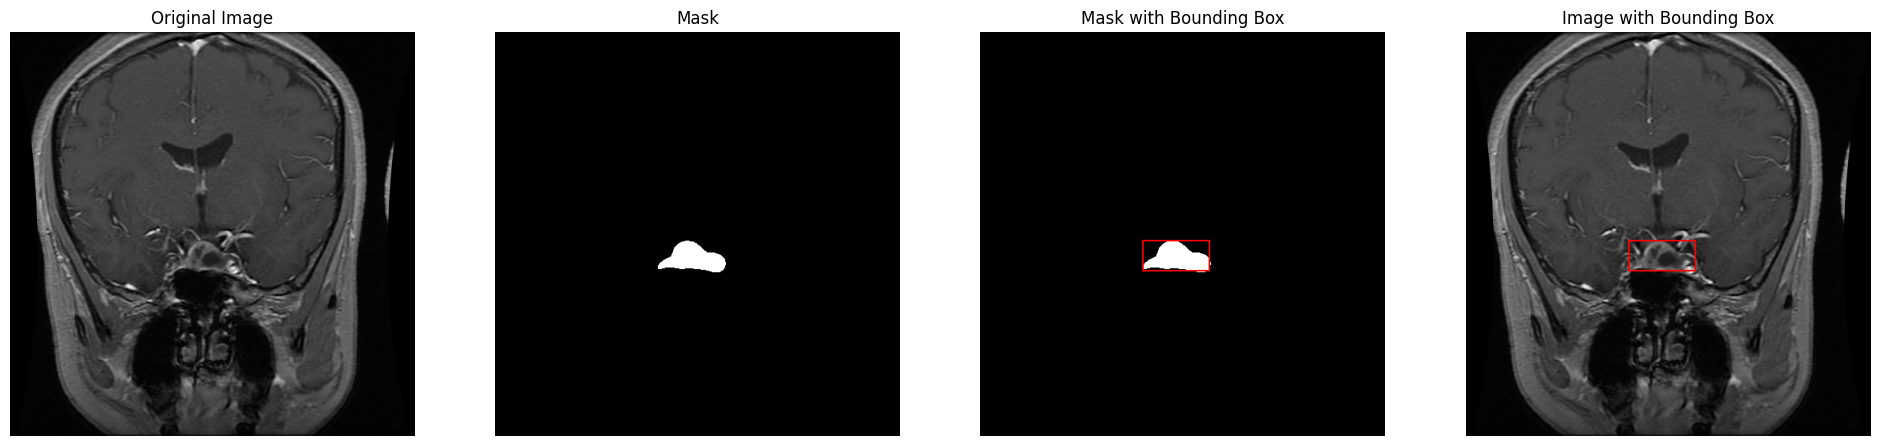

In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Define the directory where all files are saved
save_dir = "/content/drive/MyDrive/Figshare_dataset/brain/"

# Randomly select an index from 1 to 3063
i = random.randint(1, 3063)

# Define file paths
image_file = os.path.join(save_dir, f"{i}.png")
mask_file = os.path.join(save_dir, f"{i}_mask.png")
yolo_file = os.path.join(save_dir, f"{i}.txt")

# Load the image
img = Image.open(image_file).convert("RGB")
image_width, image_height = img.size

# Load the mask
mask = Image.open(mask_file).convert("RGB")

# Read YOLO format bounding box
with open(yolo_file, 'r') as f:
    yolo_format = f.readline().strip().split()
    class_id, x_center, y_center, width, height = map(float, yolo_format)

# Convert YOLO format to pixel coordinates
x_center_pixel = int(x_center * image_width)
y_center_pixel = int(y_center * image_height)
bbox_width = int(width * image_width)
bbox_height = int(height * image_height)

x_min = int(x_center_pixel - bbox_width / 2)
y_min = int(y_center_pixel - bbox_height / 2)
x_max = int(x_center_pixel + bbox_width / 2)
y_max = int(y_center_pixel + bbox_height / 2)

# Draw the bounding box on a copy of the original image
img_with_bbox = img.copy()
draw = ImageDraw.Draw(img_with_bbox)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

# Draw the bounding box on a copy of the mask image
mask_with_bbox = mask.copy()
draw_mask = ImageDraw.Draw(mask_with_bbox)
draw_mask.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

# Display the images in the requested order
plt.figure(figsize=(24, 6))

# Original image
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Mask
plt.subplot(1, 4, 2)
plt.title('Mask')
plt.imshow(mask)
plt.axis('off')

# Mask with bounding box
plt.subplot(1, 4, 3)
plt.title('Mask with Bounding Box')
plt.imshow(mask_with_bbox)
plt.axis('off')

# Image with bounding box
plt.subplot(1, 4, 4)
plt.title('Image with Bounding Box')
plt.imshow(img_with_bbox)
plt.axis('off')

# Print bounding box details
print(f"Selected index: {i}")
print(f"Image file: {image_file}")
print(f"Mask file: {mask_file}")
print(f"Bounding box (YOLO format): class_id={int(class_id)}, x_center={x_center}, y_center={y_center}, width={width}, height={height}")
print(f"Bounding box (Pixel coordinates): x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

plt.show()


## Squeeze-and-Excitation Networks

#### Finding optimal number of anchors

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
import yaml

# Load dataset annotations (width, height)
def load_annotations(data_yaml_path):
    # Load data.yaml file to get dataset path
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)

    # Define paths to dataset files
    train_path = data_yaml['train']  # Path to training set
    labels_dir = os.path.join(train_path, 'labels')  # Assuming labels are stored here

    # Gather all width, height pairs of objects
    boxes = []
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    # Assuming YOLO format: class, x_center, y_center, width, height
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        width = float(parts[3])
                        height = float(parts[4])
                        boxes.append([width, height])

    return np.array(boxes)

# Apply K-Means clustering to calculate anchors
def calculate_anchors(boxes, num_anchors):
    kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(boxes)
    return kmeans.cluster_centers_

# Save calculated anchors to a modified copy of your YOLO config
def save_anchors_to_yaml(anchor_boxes, yaml_path):
    with open(yaml_path, 'r') as f:
        model_yaml = yaml.safe_load(f)

    # Update the anchor boxes
    model_yaml['anchors'] = anchor_boxes.tolist()

    # Define the path for the modified YAML file
    base_name, ext = os.path.splitext(yaml_path)
    modified_yaml_path = f"{base_name}_modified{ext}"

    # Save the updated YAML to the new file
    with open(modified_yaml_path, 'w') as f:
        yaml.dump(model_yaml, f)

    return modified_yaml_path

if __name__ == "__main__":
    data_yaml_path = '/content/drive/MyDrive/RGELAN/data/coco.yaml'  # Path to your data.yaml file
    model_yaml_path = '/content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v39.yaml'  # Path to your model config

    num_anchors = 6  # Adjust this based on your architecture

    # Load dataset annotations and calculate anchors
    boxes = load_annotations(data_yaml_path)
    anchors = calculate_anchors(boxes, num_anchors)

    print(f"Calculated anchors: {anchors}")

    # Save anchors to a modified model configuration file
    modified_model_yaml_path = save_anchors_to_yaml(anchors, model_yaml_path)
    print(f"Anchors saved to {modified_model_yaml_path}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculated anchors: [[0.23915973 0.19110774]
 [0.08097399 0.07503275]
 [0.35601266 0.27014933]
 [0.12688732 0.12687835]
 [0.22471899 0.29060706]
 [0.16724963 0.18115554]]
Anchors saved to /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v39_modified.yaml


## 5-Fold Cross-Validation

In [ ]:
import os
import yaml
import shutil

In [ ]:
# Define paths
yolov9_path = '/content/drive/MyDrive/RGELAN'  # Update with the path to YOLOv9 directory
custom_yaml_path = '/content/drive/MyDrive/RGELAN/data/coco.yaml'  # Update with the path to custom.yaml
data_path = '/content/drive/MyDrive/Folds2'

# Function to create training folders for each fold
def create_train_folders(train_folders, n):
    for idx, folder in enumerate(train_folders):
        train_folder = f'/content/drive/MyDrive/Folds2/train{n}'
        os.makedirs(os.path.join(train_folder, 'images'), exist_ok=True)
        os.makedirs(os.path.join(train_folder, 'labels'), exist_ok=True)

        # Copy images and labels from original training folders
        images_src = os.path.join(folder, 'images')
        labels_src = os.path.join(folder, 'labels')

        images_dst = os.path.join(train_folder, 'images')
        labels_dst = os.path.join(train_folder, 'labels')

        for image_file in os.listdir(images_src):
            shutil.copy(os.path.join(images_src, image_file), images_dst)

        for label_file in os.listdir(labels_src):
            shutil.copy(os.path.join(labels_src, label_file), labels_dst)

        # Count images and labels
        num_images = len(os.listdir(images_dst))
        num_labels = len(os.listdir(labels_dst))
    print(f"Train{n} - Images: {num_images}, Labels: {num_labels}")

    return train_folder

# Function to train YOLOv9
def train_yolov9(train_folders, val_folder, fold_idx):
    # Load custom.yaml
    with open(custom_yaml_path, 'r') as file:
        yaml_content = yaml.safe_load(file)

    # Update train and val paths
    yaml_content['path'] = data_path
    yaml_content['train'] = train_folders
    yaml_content['val'] = val_folder

    print(yaml_content['val'])

    # Write the updated YAML content back to the file
    with open(custom_yaml_path, 'w') as file:
        yaml.dump(yaml_content, file)

    !python {yolov9_path}/train.py --img 640 --batch 8 --epochs 60 --min-items 0 --data {custom_yaml_path} --cfg {yolov9_path}/models/detect/ne-rcs-gelan-c-v39.yaml --hyp {yolov9_path}/data/hyps/hyp.scratch-high.yaml --device 0 --name fold{fold_idx} #--save-period 20 --resume /content/drive/MyDrive/RGELAN/runs/train/fold5/weights/epoch440.pt #(you might need to change exp? or epoch_?)

# Get list of fold directories
fold_directories = [f'/content/drive/MyDrive/Folds2/fold_{i+1}' for i in range(5)]


In [ ]:
import shutil
p = '/content/drive/MyDrive/Folds2/train1'
shutil.rmtree(p)

### Training on Fold 1

In [ ]:
# Fold 1
fold_idx = 0
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)

Training on fold 1...
Train1 - Images: 2451, Labels: 2451
/content/drive/MyDrive/Folds2/train1
/content/drive/MyDrive/Folds2/fold_1
2024-10-05 09:02:14.133515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 09:02:14.154046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 09:02:14.159939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 09:02:14.174017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX

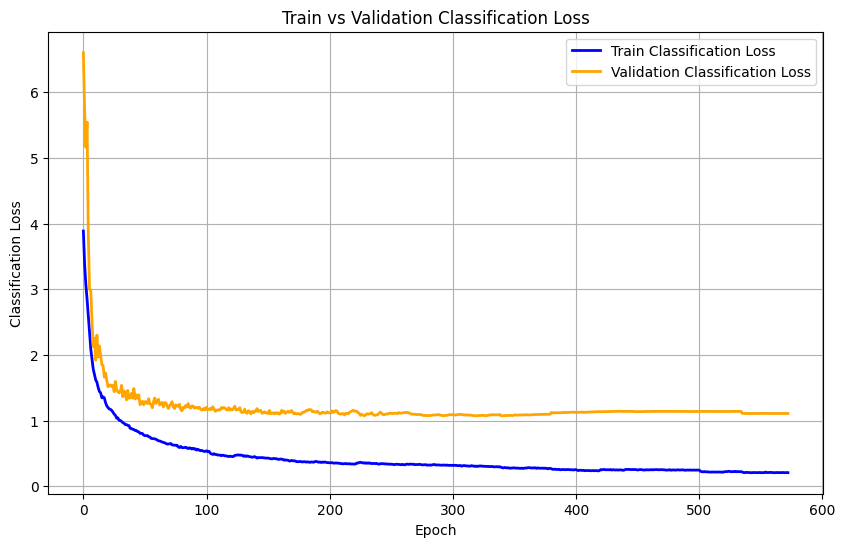

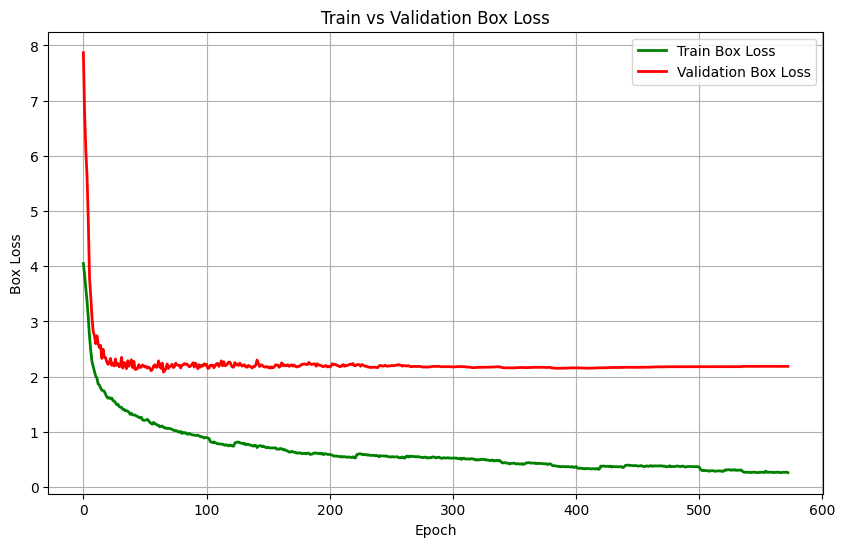

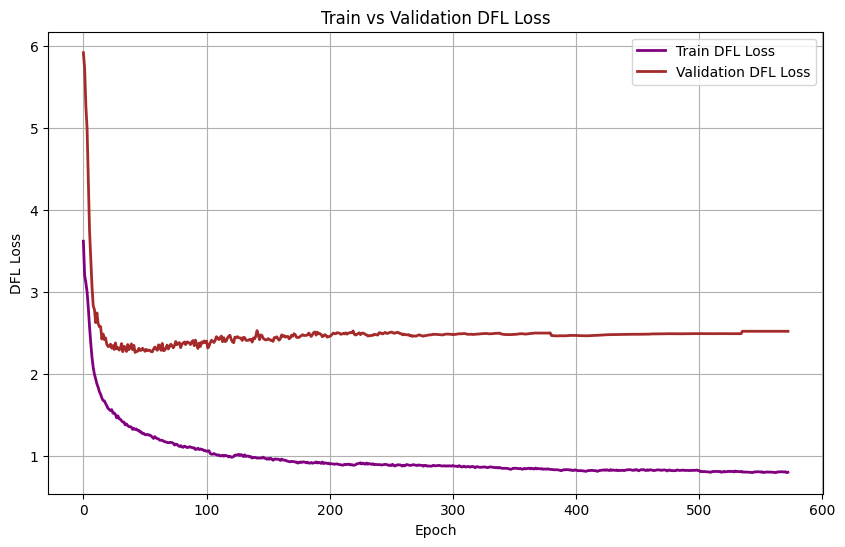

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/fold14/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/cls_loss'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['        val/cls_loss'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/box_loss'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['        val/box_loss'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()


### Training on Fold 2

In [ ]:
# Fold 2
fold_idx = 1
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)

Training on fold 2...
Train2 - Images: 2450, Labels: 2450
/content/drive/MyDrive/Folds2/train2
/content/drive/MyDrive/Folds2/fold_2
2024-09-22 18:21:24.453851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 18:21:24.474680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 18:21:24.481301: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 18:21:24.497183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX

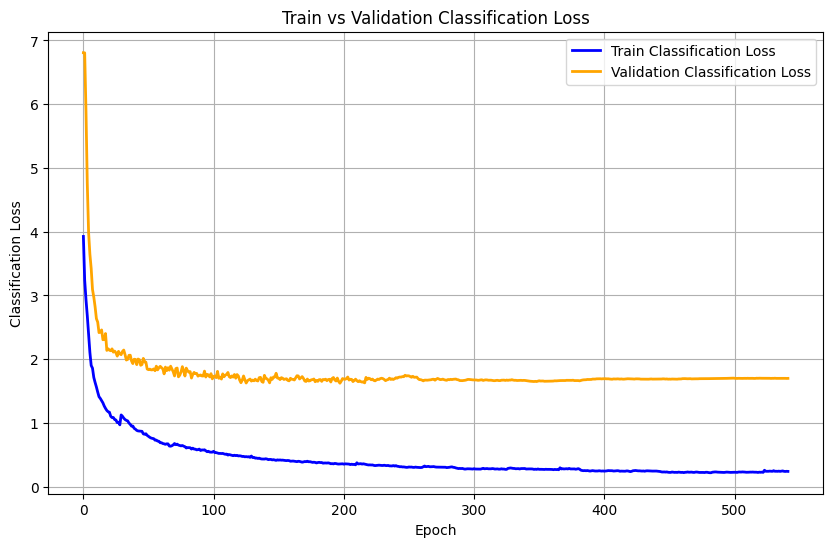

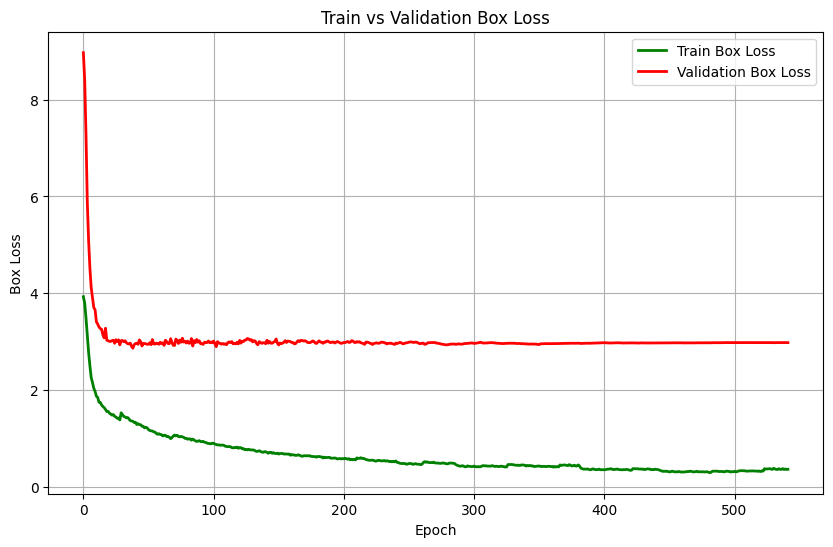

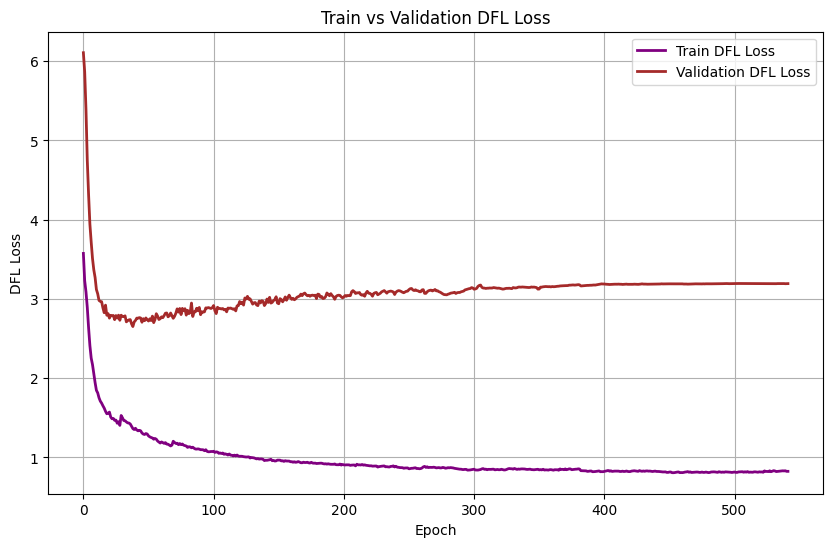

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/fold2/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/cls_loss'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['        val/cls_loss'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/box_loss'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['        val/box_loss'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()


### Training on Fold 3

In [ ]:
# Fold 3
fold_idx = 2
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)


Training on fold 3...
Train3 - Images: 2451, Labels: 2451
/content/drive/MyDrive/Folds2/train3
/content/drive/MyDrive/Folds2/fold_3
2024-09-23 23:19:39.800216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 23:19:39.820985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 23:19:39.827133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 23:19:39.841721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX

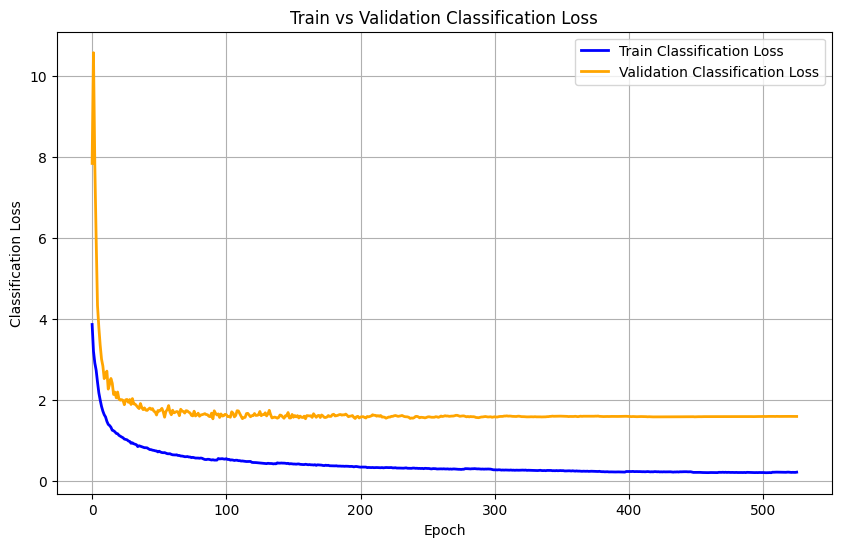

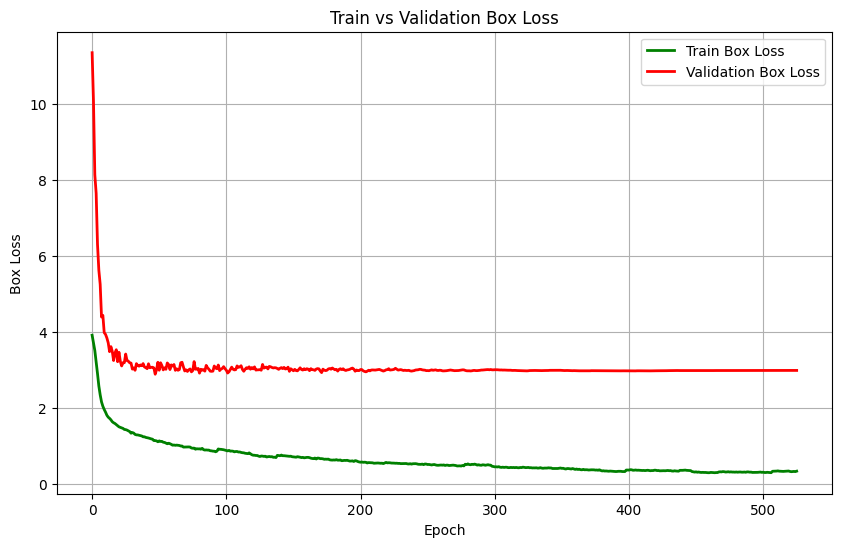

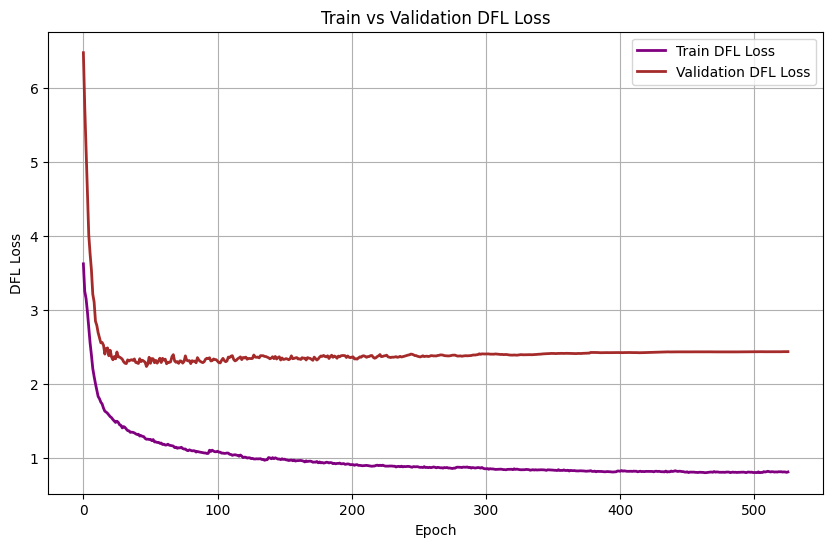

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/fold3/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/cls_loss'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['        val/cls_loss'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/box_loss'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['        val/box_loss'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()


### Training on Fold 4

In [ ]:
# Fold 4
fold_idx = 3
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)


Training on fold 4...
Train4 - Images: 2450, Labels: 2450
/content/drive/MyDrive/Folds2/train4
/content/drive/MyDrive/Folds2/fold_4
2024-09-25 21:39:23.272781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 21:39:23.293427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 21:39:23.299230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 21:39:23.314566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX

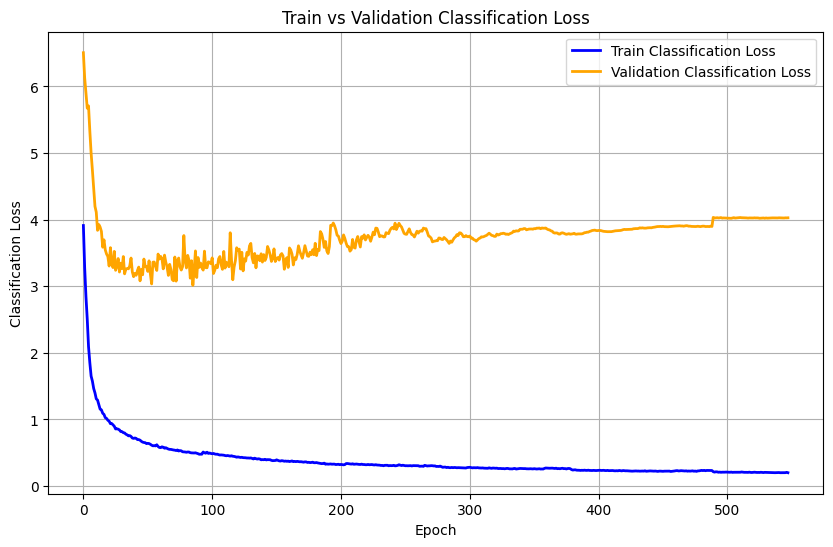

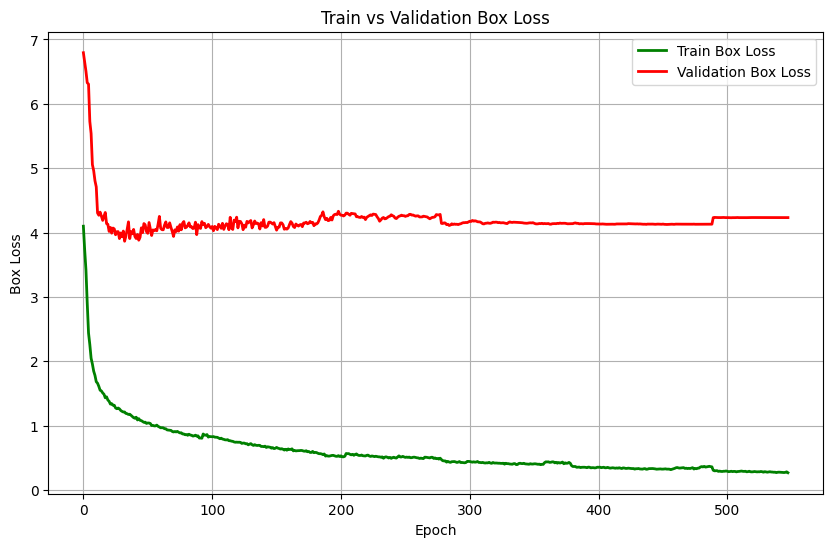

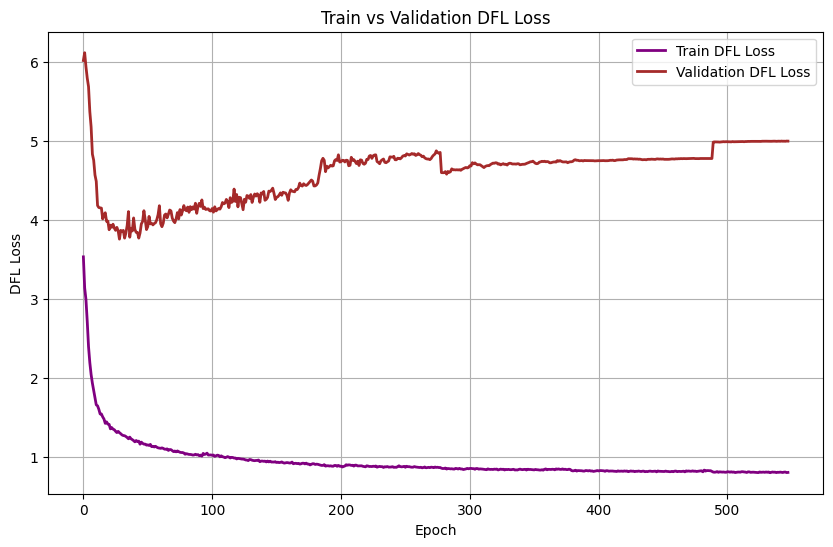

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/fold4/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/cls_loss'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['        val/cls_loss'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/box_loss'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['        val/box_loss'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()


### Training on Fold 5

In [ ]:
# Fold 5
fold_idx = 4
val_folder = fold_directories[fold_idx]
print(f"Training on fold {fold_idx + 1}...")

# Define training folders (all other folds)
train_folders = fold_directories[:fold_idx] + fold_directories[fold_idx + 1:]

# Create training folders for the current fold
train_fold = create_train_folders(train_folders, fold_idx + 1)
print(train_fold)

# Train YOLOv9 on the current fold
train_yolov9(train_fold, val_folder, fold_idx + 1)

Training on fold 5...
Train5 - Images: 2450, Labels: 2450
/content/drive/MyDrive/Folds2/train5
/content/drive/MyDrive/Folds2/fold_5
2024-09-29 10:52:26.530064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 10:52:26.563718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 10:52:26.573497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 10:52:26.595851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX

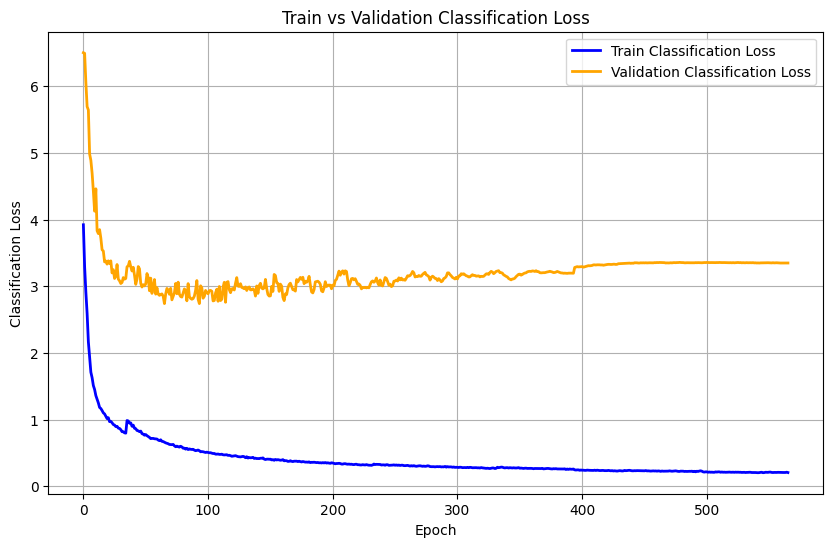

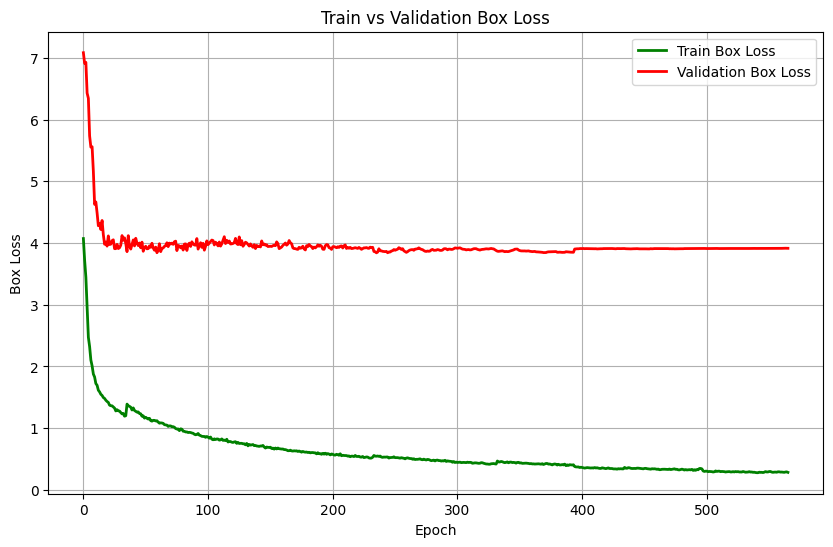

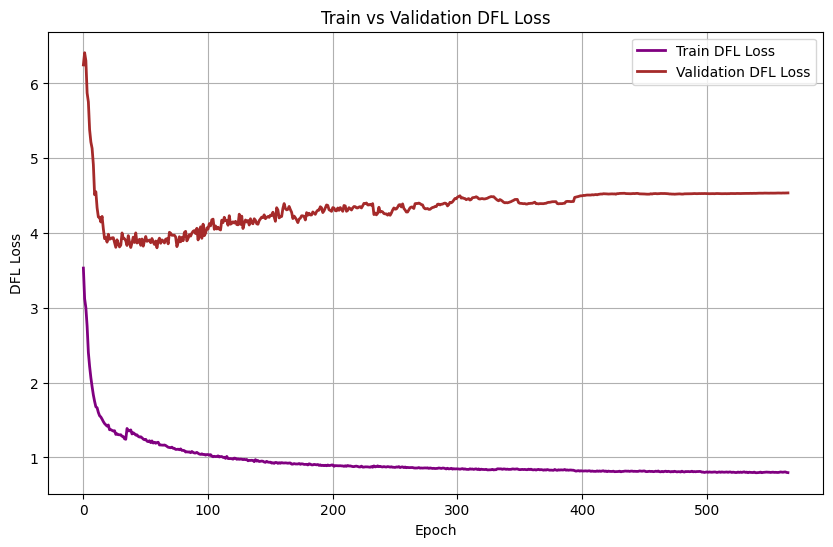

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/fold5/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/cls_loss'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['        val/cls_loss'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/box_loss'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['        val/box_loss'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()


### Whole Dataset run

150 epochs

In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 150 --img 640 --device 0 --min-items 0 --close-mosaic 15  \
--data /content/drive/MyDrive/RGELAN/data/coco2.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v39.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml \
--save-period 20 #--resume /content/drive/MyDrive/RGELAN/runs/train/exp4/weights/epoch100.pt #(you might need to change exp? or epoch_?)

2024-10-02 22:25:10.087281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 22:25:10.110870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 22:25:10.117256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 22:25:10.133137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 22:25:11.343377: W tensorflow/comp

200 epochs

In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 200 --img 640 --device 0 --min-items 0 --close-mosaic 15 --workers 8  \
--data /content/drive/MyDrive/RGELAN/data/coco2.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v39.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml \
--save-period 20 #--resume /content/drive/MyDrive/RGELAN/runs/train/exp3/weights/last.pt #(you might need to change exp? or epoch_?)

2024-10-07 08:25:41.627735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 08:25:41.647551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 08:25:41.653553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 08:25:41.668608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 08:25:42.920690: W tensorflow/comp

In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 200 --img 640 --device 0 --min-items 0 --close-mosaic 15 --workers 8  \
--data /content/drive/MyDrive/RGELAN/data/coco2.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/ne-rcs-gelan-c-v39.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml \
--save-period 20 #--resume /content/drive/MyDrive/RGELAN/runs/train/exp3/weights/last.pt #(you might need to change exp? or epoch_?)

2024-10-11 17:01:42.707979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 17:01:42.727336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 17:01:42.733104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 17:01:42.746998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 17:01:43.916117: W tensorflow/compiler/tf2

## Yolov9c

In [ ]:
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 49.9 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import random

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

In [ ]:
import cv2
from ultralytics import YOLO
from IPython.display import display, Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/'

In [ ]:
# Load a model
model = YOLO("yolov9c.pt")  # load pre trained model

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "coco2.yaml"), epochs=150, save_period=20, save=True)  # to resume use 'resume=True' and change 'epochs=?' to the number of remaining epochs

Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/drive/MyDrive/coco2.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=20, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

train: Scanning /content/drive/MyDrive/Folds2/train1/labels... 2451 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2451/2451 [41:13<00:00,  1.01s/it]


train: New cache created: /content/drive/MyDrive/Folds2/train1/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Folds2/fold_1/labels... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [12:37<00:00,  1.24s/it]


val: New cache created: /content/drive/MyDrive/Folds2/fold_1/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 160 weight(decay=0.0), 167 weight(decay=0.0005), 166 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      11.5G      1.701      2.872      1.716          1        640: 100%|██████████| 154/154 [02:14<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.18it/s]


                   all        612        612     0.0348      0.606     0.0314     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      11.5G      1.844       2.08      1.806          7        640: 100%|██████████| 154/154 [02:11<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


                   all        612        612      0.482      0.324      0.384      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      11.5G      1.779      1.876      1.767          6        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        612        612      0.724      0.614      0.703      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      11.5G      1.768       1.78      1.753          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.763      0.699      0.808      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      11.5G      1.727      1.691      1.744          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.571      0.533      0.568      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      11.5G      1.657      1.626      1.672          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.725      0.721      0.762      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      11.5G      1.611      1.525      1.646          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


                   all        612        612      0.828      0.732        0.8      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      11.5G      1.578      1.471      1.627          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


                   all        612        612      0.825       0.83      0.878      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      11.5G      1.553      1.401       1.59          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

                   all        612        612      0.746      0.651      0.734       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      11.5G       1.52      1.376      1.582          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.868      0.732       0.84      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      11.5G      1.511      1.345      1.582          9        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

                   all        612        612      0.896       0.81      0.901      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      11.5G       1.49      1.309      1.564          1        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612      0.818      0.742      0.829      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      11.5G      1.486      1.289       1.57          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612       0.84      0.807      0.889       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      11.5G      1.462      1.258      1.547          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.863      0.835      0.885      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      11.5G       1.46       1.21      1.532          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

                   all        612        612      0.881      0.724      0.843      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      11.5G      1.435      1.188      1.527          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.887       0.77      0.884      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      11.5G       1.42      1.187      1.516          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]

                   all        612        612      0.911      0.822      0.913      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      11.5G      1.438      1.191      1.533          2        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612      0.921      0.871      0.947      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      11.5G      1.404      1.165      1.508          5        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

                   all        612        612      0.669      0.538      0.594      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      11.5G      1.409      1.138      1.503          1        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.914      0.908      0.962       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      11.5G      1.398      1.136      1.494          2        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612      0.872      0.819      0.905      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      11.5G      1.393      1.114      1.486          3        640: 100%|██████████| 154/154 [02:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612      0.916      0.837      0.919      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      11.5G      1.381      1.102      1.482          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

                   all        612        612       0.87      0.814      0.892      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      11.5G      1.376       1.13      1.481          5        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]

                   all        612        612      0.846      0.735      0.829      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      11.5G      1.332      1.052      1.458          3        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

                   all        612        612      0.898      0.879      0.946      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      11.5G      1.352      1.052      1.462          5        640: 100%|██████████| 154/154 [02:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

                   all        612        612      0.911      0.857       0.93      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      11.5G      1.308      1.052      1.431          3        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

                   all        612        612      0.901      0.846       0.92      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      11.5G      1.319      1.005      1.448          5        640: 100%|██████████| 154/154 [02:06<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

                   all        612        612      0.862      0.859      0.909      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      11.5G      1.299      1.014      1.417          5        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612      0.919      0.882      0.949      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      11.5G      1.297     0.9975      1.425          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.893      0.822      0.918      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      11.5G      1.319      1.011      1.428          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.926      0.879      0.941      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      11.5G      1.292      1.012      1.423          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.904      0.851      0.936      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      11.5G       1.31     0.9825      1.443          6        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.922      0.833      0.927      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      11.5G      1.294     0.9728      1.426         10        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.903      0.848      0.932      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      11.5G      1.278     0.9469      1.407          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

                   all        612        612       0.89      0.872      0.927      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      11.5G      1.254     0.9522      1.391          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.902      0.915      0.958      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      11.5G      1.274     0.9452      1.402          5        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612       0.92      0.833      0.932      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      11.5G      1.262     0.9461      1.397          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.33it/s]

                   all        612        612      0.922      0.863      0.941      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      11.5G      1.256     0.9312      1.401          6        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.916      0.874      0.946      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      11.5G      1.253     0.9167      1.403          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

                   all        612        612      0.924      0.851      0.938      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      11.5G      1.236     0.8917      1.381          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]

                   all        612        612      0.917      0.926       0.97       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      11.5G      1.218     0.8743      1.363          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.866      0.828      0.913      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      11.5G       1.23     0.8909       1.38          2        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

                   all        612        612      0.943      0.868       0.95        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      11.5G      1.232     0.8952      1.376          5        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.878      0.882      0.942      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      11.5G      1.203       0.85      1.349          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.929      0.886      0.959      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      11.5G       1.24     0.8833       1.39          8        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.887      0.848      0.921      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      11.5G      1.197     0.8556      1.358          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.873      0.811      0.903      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      11.5G      1.208     0.8436      1.363          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

                   all        612        612      0.928      0.879      0.952      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      11.5G      1.191     0.8323      1.348          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612       0.94      0.898      0.962      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      11.5G      1.176     0.8148      1.328          5        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.919      0.897      0.957      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      11.5G      1.164     0.8126      1.325          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.902      0.899      0.952      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      11.5G       1.18     0.8086      1.334          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.936      0.853       0.96      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      11.5G      1.166     0.8148       1.33          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.934      0.904      0.962      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      11.5G      1.179     0.8211      1.336          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.895      0.867      0.929      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      11.5G      1.157     0.7917      1.322          2        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


                   all        612        612      0.926      0.902      0.959       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      11.5G      1.139     0.7864      1.325          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.921      0.783      0.902      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      11.5G      1.158     0.7808      1.318          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]

                   all        612        612      0.935      0.876      0.961      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      11.5G      1.137     0.7836      1.305          4        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.933      0.897      0.958      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      11.5G      1.121     0.7548      1.298          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612      0.927      0.925      0.965      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      11.5G      1.119     0.7582      1.306          9        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612       0.91      0.887      0.948      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      11.5G      1.121     0.7519      1.297          7        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.929      0.868      0.944      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      11.5G      1.104     0.7633      1.294          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

                   all        612        612      0.935      0.864      0.946      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      11.5G      1.101     0.7293      1.288          8        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]

                   all        612        612      0.929      0.868      0.946      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      11.5G      1.115     0.7348      1.295          5        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]

                   all        612        612      0.901      0.875      0.934       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      11.5G      1.089     0.7277      1.277          4        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


                   all        612        612      0.921      0.917      0.963      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      11.5G      1.084     0.7116      1.268          6        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]

                   all        612        612      0.923      0.892      0.964      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      11.5G      1.094     0.7462      1.282          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


                   all        612        612       0.91      0.838      0.932      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      11.5G      1.067     0.7068       1.26          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.919      0.873      0.949       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      11.5G      1.068     0.7019      1.264          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

                   all        612        612      0.939      0.898      0.953      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      11.5G      1.063     0.6833      1.264          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

                   all        612        612      0.951      0.918      0.972      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      11.5G      1.044     0.6749      1.246          2        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612      0.926      0.922      0.962       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      11.5G      1.058     0.6756      1.256          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

                   all        612        612       0.92      0.921      0.967      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      11.5G      1.061      0.669      1.256          5        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.889      0.912      0.955      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      11.5G      1.056     0.6699      1.248          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

                   all        612        612      0.923       0.84      0.937      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      11.5G      1.028     0.6674      1.227          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

                   all        612        612      0.917       0.91      0.957      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      11.5G      1.044     0.6567      1.255          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.947      0.904      0.961      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      11.5G      1.014     0.6431      1.234          2        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

                   all        612        612      0.917       0.93      0.961      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      11.5G      1.013     0.6444      1.237          5        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

                   all        612        612      0.933       0.92      0.969      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      11.5G      1.002     0.6255      1.225          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]

                   all        612        612      0.917      0.882      0.951      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      11.5G      1.017     0.6319      1.236          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.908      0.915      0.962      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      11.5G      1.003     0.6229      1.207          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

                   all        612        612      0.926      0.904      0.965      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      11.5G     0.9832     0.6059      1.204          3        640: 100%|██████████| 154/154 [02:10<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

                   all        612        612      0.889      0.869      0.929      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      11.5G     0.9905     0.6198      1.216          7        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612       0.88      0.901      0.946      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      11.5G     0.9667     0.6189      1.204          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]

                   all        612        612      0.922      0.869      0.943      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      11.5G     0.9737     0.6087      1.207          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612      0.913      0.896      0.944      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      11.5G     0.9737     0.6214        1.2          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]

                   all        612        612       0.93      0.892      0.959      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      11.5G     0.9748     0.5941      1.202          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

                   all        612        612      0.915      0.913      0.961      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      11.5G     0.9721     0.5967      1.187          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612       0.93      0.895      0.955      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      11.5G     0.9499     0.5963      1.186          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

                   all        612        612       0.89      0.913      0.949      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      11.5G     0.9459     0.5896      1.178          1        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

                   all        612        612      0.927      0.898      0.958      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      11.5G     0.9271     0.5665      1.158          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


                   all        612        612      0.928      0.906      0.957      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      11.5G     0.9388     0.5814      1.174          8        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.914       0.89      0.949      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      11.5G     0.9207     0.5653      1.165          8        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.921      0.894      0.947      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      11.5G     0.9239     0.5655      1.162          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

                   all        612        612      0.932      0.889      0.948      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      11.5G      0.911     0.5624      1.154          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612      0.943      0.895      0.961      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      11.5G     0.9009     0.5579      1.152          6        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.935       0.91      0.962      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      11.5G     0.8898     0.5508      1.149          8        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.932      0.903      0.954      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      11.5G     0.8859     0.5492      1.136          7        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

                   all        612        612      0.931      0.905      0.958      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      11.5G     0.8963     0.5538      1.152          2        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.941        0.9       0.96      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      11.5G     0.8815     0.5383      1.143          2        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

                   all        612        612      0.921      0.912      0.962      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      11.5G     0.8773     0.5375      1.144          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

                   all        612        612      0.929      0.925      0.962       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      11.5G     0.8721     0.5386      1.135          7        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

                   all        612        612      0.925      0.905      0.957      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      11.5G     0.8701     0.5239      1.126          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

                   all        612        612      0.955      0.889      0.962      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      11.5G     0.8656     0.5153      1.132          7        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

                   all        612        612       0.93      0.907      0.962      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      11.5G     0.8804     0.5253      1.136          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.945      0.907      0.965       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      11.5G     0.8545     0.5203       1.13          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.33it/s]

                   all        612        612       0.92      0.903      0.957      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      11.5G     0.8601     0.5132      1.122          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.939      0.894      0.952      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      11.5G     0.8271     0.4896      1.116          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.913      0.892      0.946      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      11.5G     0.8434     0.4951      1.112          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.903        0.9      0.947       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      11.5G     0.8239     0.4885      1.102          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]

                   all        612        612      0.944        0.9      0.965      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      11.5G     0.8126     0.4911      1.094          6        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

                   all        612        612      0.941      0.894      0.959      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      11.5G     0.8179     0.4801      1.096          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

                   all        612        612      0.927      0.917      0.961      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      11.5G      0.818      0.477      1.095          6        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.912      0.916      0.952      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      11.5G     0.8167      0.489      1.094          2        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

                   all        612        612       0.92      0.904      0.951      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      11.5G     0.8074     0.4831      1.092          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.936      0.881      0.952      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      11.5G     0.8079     0.4875      1.096          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.914      0.919      0.961      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      11.5G     0.7816     0.4588      1.074          5        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.938      0.909      0.966      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      11.5G     0.7906      0.472      1.076          6        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612        0.9      0.894      0.946      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      11.5G     0.7692     0.4614      1.068          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

                   all        612        612      0.924      0.894      0.953      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      11.5G     0.7785      0.461      1.078          2        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.906      0.925      0.954       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      11.5G     0.7679     0.4536      1.066          5        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

                   all        612        612      0.907      0.907       0.95      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      11.5G     0.7622     0.4513      1.073          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]

                   all        612        612      0.944      0.897       0.96      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      11.5G     0.7703     0.4625      1.062          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612      0.908      0.922      0.956      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      11.5G     0.7566     0.4391      1.059          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.933      0.904      0.957      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      11.5G     0.7635     0.4432      1.064          6        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.931      0.908      0.957      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      11.5G     0.7485     0.4447      1.055          4        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]

                   all        612        612      0.932      0.913      0.954      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      11.5G     0.7422      0.444      1.055          2        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.942       0.91       0.96      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      11.5G     0.7248     0.4292      1.038          6        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


                   all        612        612      0.935      0.894      0.956      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      11.5G     0.7462      0.449       1.06          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.942      0.925      0.965      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      11.5G     0.7274     0.4361      1.042         10        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

                   all        612        612      0.932      0.912      0.956      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      11.5G     0.7296     0.4238      1.053          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

                   all        612        612      0.924      0.918      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      11.5G       0.71      0.419      1.039          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

                   all        612        612      0.929        0.9      0.956      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      11.5G     0.7199     0.4276      1.045          2        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]

                   all        612        612       0.94      0.907      0.954      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      11.5G     0.7094     0.4207      1.036          4        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612      0.938      0.917      0.957      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      11.5G     0.7007     0.4219      1.031          6        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]

                   all        612        612      0.925      0.926      0.957      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      11.5G      0.707     0.4121      1.031          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612      0.922      0.922      0.953      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      11.5G     0.6964     0.4108      1.028          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


                   all        612        612      0.945      0.881      0.952      0.735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      11.5G     0.6955     0.4208      1.034          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

                   all        612        612       0.93      0.908      0.954      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      11.5G     0.7052     0.4093      1.032          7        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]

                   all        612        612      0.934       0.91      0.955      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      11.5G     0.6708     0.4059      1.016          4        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

                   all        612        612      0.916      0.912      0.958      0.732


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      11.5G     0.6327     0.3238     0.9931          3        640: 100%|██████████| 154/154 [02:09<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

                   all        612        612      0.924      0.904      0.953      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      11.5G     0.5907     0.3016     0.9618          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

                   all        612        612      0.916      0.902       0.95      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      11.5G     0.5919     0.3001     0.9664          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

                   all        612        612       0.92      0.892      0.946      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      11.5G     0.5843     0.2928     0.9604          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

                   all        612        612      0.908      0.916      0.949      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      11.5G     0.5767     0.2935     0.9575          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


                   all        612        612       0.91      0.909       0.95      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      11.5G     0.5619     0.2878      0.942          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


                   all        612        612      0.919      0.913      0.952      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      11.5G     0.5592      0.283      0.949          3        640: 100%|██████████| 154/154 [02:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

                   all        612        612      0.916      0.905      0.949      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      11.5G     0.5654     0.2831     0.9451          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

                   all        612        612      0.919      0.909      0.949      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      11.5G     0.5555     0.2807      0.941          3        640: 100%|██████████| 154/154 [02:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

                   all        612        612      0.902      0.921      0.949      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      11.5G     0.5528     0.2833     0.9422          3        640: 100%|██████████| 154/154 [02:08<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]

                   all        612        612      0.916       0.91       0.95      0.729



150 epochs completed in 6.075 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 43.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 43.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.3 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 402 layers, 21,146,195 parameters, 0 gradients, 82.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


                   all        612        612      0.932       0.91      0.961      0.752
Speed: 0.4ms preprocess, 15.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train2


## RepVGG-GELAN

In [ ]:
!python /content/drive/MyDrive/RGELAN/train.py \
--batch 8 --epochs 150 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data /content/drive/MyDrive/RGELAN/data/coco2.yaml \
--cfg /content/drive/MyDrive/RGELAN/models/detect/rcs-gelan-c.yaml \
--hyp /content/drive/MyDrive/RGELAN/data/hyps/hyp.scratch-high.yaml \
--save-period 20 --resume /content/drive/MyDrive/RGELAN/runs/train/exp2/weights/epoch100.pt #(you might need to change exp? or epoch_?)

2024-10-04 13:38:25.126943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 13:38:25.150108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 13:38:25.156898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 13:38:25.173662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 13:38:26.556882: W tensorflow/compiler/tf2

## RCS-yolo

In [ ]:
!pip install -r /content/drive/MyDrive/RCS-YOLO/requirements.txt

In [ ]:
!python /content/drive/MyDrive/RCS-YOLO/train.py \
--epochs 150 --device 0 --batch-size 8 --img 640 \
--data /content/drive/MyDrive/RCS-YOLO/data/coco22.yaml \
--cfg /content/drive/MyDrive/RCS-YOLO/cfg/training/rcs-yolo.yaml \
--hyp /content/drive/MyDrive/RCS-YOLO/data/hyp_training.yaml \
--project /content/drive/MyDrive/RCS-YOLO/runs/train --name exp2 \
--save_period 20 #--resume /content/drive/MyDrive/RCS-YOLO/runs/train/exp2/weights/best.pt #(you might need to change exp? or epoch_?)

2024-10-04 22:57:55.566507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 22:57:55.599817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 22:57:55.609815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 22:57:55.632086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 22:57:57.253547: W tensorflow/comp

# MICCAI Brats-2018 Dataset

## Convert NIfTI Files to PNG

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import random

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the dataset
dataset_path = '/content/drive/My Drive/MICCAI_BraTS_2018'
save_dir = os.path.join(dataset_path, 'brain')

# Function to empty the brain folder
def empty_folder(folder_path):
    """Delete all files in the specified folder."""
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")

# Create the 'brain' directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    # Empty the brain folder
    empty_folder(save_dir)

# Function to load a .nii.gz file
def load_nii_file(filepath):
    """Loads a .nii.gz file and returns the data as a numpy array."""
    nii_img = nib.load(filepath)
    return nii_img.get_fdata()

# Function to calculate the bounding box of the tumor mask
def get_bounding_box(mask):
    """Calculate the bounding box of the tumor mask."""
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()
    return x_min, y_min, x_max, y_max

# Function to convert bounding box coordinates to YOLO format
def convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height):
    """Convert the bounding box to YOLO format: [class x_center y_center width height]."""
    x_center = (x_min + x_max) / 2 / image_width
    y_center = (y_min + y_max) / 2 / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height
    return [0, x_center, y_center, width, height]  # Assuming class 0 for tumor

# Function to check if a mask contains a tumor
def has_tumor(mask_slice):
    """Returns True if the mask slice contains a non-zero pixel (tumor)."""
    return np.any(mask_slice > 0)

# Function to extract slices with tumors from MRI and mask files
def extract_slices_with_tumor(mri_file, mask_file, num_slices=2, slice_range=(80, 110)):
    """Extracts MRI and mask slices containing tumors within a given range."""
    mri_data = load_nii_file(mri_file)
    mask_data = load_nii_file(mask_file)

    assert mri_data.shape == mask_data.shape, "MRI and mask must have the same shape!"

    depth = mri_data.shape[2]  # Number of slices in the 3rd dimension
    valid_slices = []

    # Ensure we're within bounds and check for tumor presence in the mask slices
    for slice_idx in range(slice_range[0], slice_range[1]+1):
        if slice_idx < depth and has_tumor(mask_data[:, :, slice_idx]):
            valid_slices.append(slice_idx)

    # Randomly select 'num_slices' slices from valid slices with tumors
    if len(valid_slices) >= num_slices:
        return random.sample(valid_slices, num_slices)
    else:
        return valid_slices  # If there are fewer valid slices than needed

# Global counter to keep track of file naming
file_counter = 1

# Function to save MRI, mask as .png and mask's bounding box in YOLO-format .txt
def save_mri_and_mask(mri_slices, mask_slices, slice_indices):
    """Saves the MRI slices, mask slices, and YOLO-format bounding box annotations."""
    global file_counter  # Reference the global file counter
    for i in range(len(slice_indices)):
        # Use file_counter for naming
        base_filename = f"{file_counter}"

        # Save MRI slice as image (.png)
        mri_slice_path = os.path.join(save_dir, f"{base_filename}.png")
        plt.imsave(mri_slice_path, mri_slices[:, :, i], cmap='gray')

        # Save the mask slice as an image (.png)
        mask_slice_path = os.path.join(save_dir, f"{base_filename}_mask.png")
        plt.imsave(mask_slice_path, mask_slices[:, :, i], cmap='gray')

        # Get mask slice and calculate the bounding box
        mask_slice = mask_slices[:, :, i]
        x_min, y_min, x_max, y_max = get_bounding_box(mask_slice)

        # Convert bounding box to YOLO format
        image_height, image_width = mask_slice.shape
        yolo_format = convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height)

        # Save YOLO format annotation in .txt file
        yolo_file_path = os.path.join(save_dir, f"{base_filename}.txt")
        with open(yolo_file_path, 'w') as f:
            f.write(" ".join(map(str, yolo_format)) + "\n")

        print(f"Saved MRI slice {file_counter}, mask {file_counter}, and bounding box {file_counter}")

        # Increment the file counter after saving each slice
        file_counter += 1

# Function to process MRI files in the HGG or LGG folder
def process_mri_folder(folder_path, num_slices=2, slice_range=(80, 110)):
    """Processes MRI and mask files in a given folder, saves selected slices and YOLO-format annotations."""
    for patient_folder in os.listdir(folder_path):
        patient_path = os.path.join(folder_path, patient_folder)

        if os.path.isdir(patient_path):
            # Identify the MRI and mask files
            mri_file = None
            mask_file = None

            for file in os.listdir(patient_path):
                if 't1.nii.gz' in file:  # Example for T1 MRI, adjust as needed
                    mri_file = os.path.join(patient_path, file)
                if 'seg.nii.gz' in file:  # Example for segmentation mask
                    mask_file = os.path.join(patient_path, file)

            if mri_file and mask_file:
                # Extract slices containing tumors in the specified range
                slice_indices = extract_slices_with_tumor(mri_file, mask_file, num_slices, slice_range)

                if slice_indices:
                    # Load MRI and mask data for the selected slices
                    mri_data = load_nii_file(mri_file)[:, :, slice_indices]
                    mask_data = load_nii_file(mask_file)[:, :, slice_indices]

                    # Save the selected MRI slices, mask slices, and YOLO-format bounding boxes
                    save_mri_and_mask(mri_data, mask_data, slice_indices)

# Define paths to HGG and LGG folders
hgg_path = os.path.join(dataset_path, 'HGG')
lgg_path = os.path.join(dataset_path, 'LGG')

# Process both HGG and LGG folders
process_mri_folder(hgg_path, num_slices=2, slice_range=(80, 110))
process_mri_folder(lgg_path, num_slices=2, slice_range=(80, 110))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_13_1_104.png
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_13_1_104_mask.png
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_13_1_104.txt
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_17_1_87.png
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_17_1_87_mask.png
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_17_1_87.txt
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_12_1_100.png
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_12_1_100_mask.png
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_12_1_100.txt
Deleted: /content/drive/My Drive/MICCAI_BraTS_2018/brain/Brats18_2013_13_1_83.png
Deleted: /content/drive/My Dri

## Showcasing

Selected index: 184
Image file: /content/drive/MyDrive/MICCAI_BraTS_2018/brain/184.png
Mask file: /content/drive/MyDrive/MICCAI_BraTS_2018/brain/184_mask.png
Bounding box (YOLO format): class_id=0, x_center=0.6375, y_center=0.6291666666666667, width=0.15, height=0.11666666666666667
Bounding box (Pixel coordinates): x_min=135, y_min=137, x_max=171, y_max=165


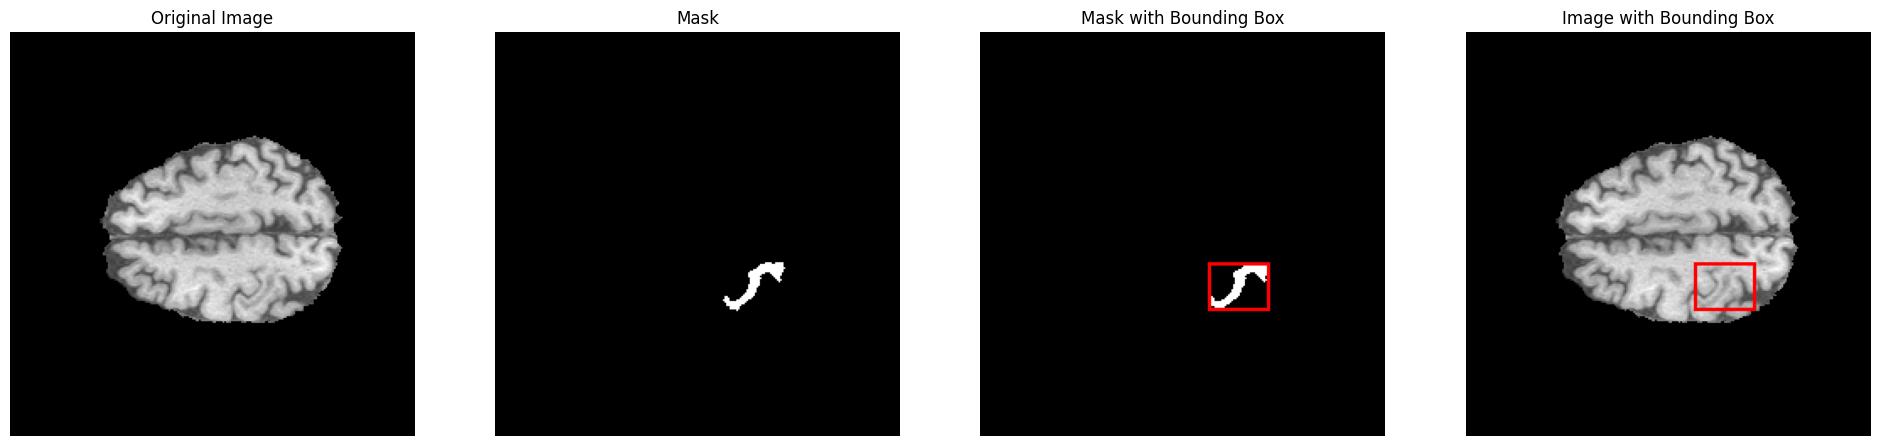

In [ ]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Define the directory where all files are saved
save_dir = "/content/drive/MyDrive/MICCAI_BraTS_2018/brain/"

# Randomly select an index from 1 to 3063
i = random.randint(1, 513)

# Define file paths
image_file = os.path.join(save_dir, f"{i}.png")
mask_file = os.path.join(save_dir, f"{i}_mask.png")
yolo_file = os.path.join(save_dir, f"{i}.txt")

# Load the image
img = Image.open(image_file).convert("RGB")
image_width, image_height = img.size

# Load the mask
mask = Image.open(mask_file).convert("RGB")

# Read YOLO format bounding box
with open(yolo_file, 'r') as f:
    yolo_format = f.readline().strip().split()
    class_id, x_center, y_center, width, height = map(float, yolo_format)

# Convert YOLO format to pixel coordinates
x_center_pixel = int(x_center * image_width)
y_center_pixel = int(y_center * image_height)
bbox_width = int(width * image_width)
bbox_height = int(height * image_height)

x_min = int(x_center_pixel - bbox_width / 2)
y_min = int(y_center_pixel - bbox_height / 2)
x_max = int(x_center_pixel + bbox_width / 2)
y_max = int(y_center_pixel + bbox_height / 2)

# Draw the bounding box on a copy of the original image
img_with_bbox = img.copy()
draw = ImageDraw.Draw(img_with_bbox)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

# Draw the bounding box on a copy of the mask image
mask_with_bbox = mask.copy()
draw_mask = ImageDraw.Draw(mask_with_bbox)
draw_mask.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

# Display the images in the requested order
plt.figure(figsize=(24, 6))

# Original image
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

# Mask
plt.subplot(1, 4, 2)
plt.title('Mask')
plt.imshow(mask)
plt.axis('off')

# Mask with bounding box
plt.subplot(1, 4, 3)
plt.title('Mask with Bounding Box')
plt.imshow(mask_with_bbox)
plt.axis('off')

# Image with bounding box
plt.subplot(1, 4, 4)
plt.title('Image with Bounding Box')
plt.imshow(img_with_bbox)
plt.axis('off')

# Print bounding box details
print(f"Selected index: {i}")
print(f"Image file: {image_file}")
print(f"Mask file: {mask_file}")
print(f"Bounding box (YOLO format): class_id={int(class_id)}, x_center={x_center}, y_center={y_center}, width={width}, height={height}")
print(f"Bounding box (Pixel coordinates): x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

plt.show()

# Tests

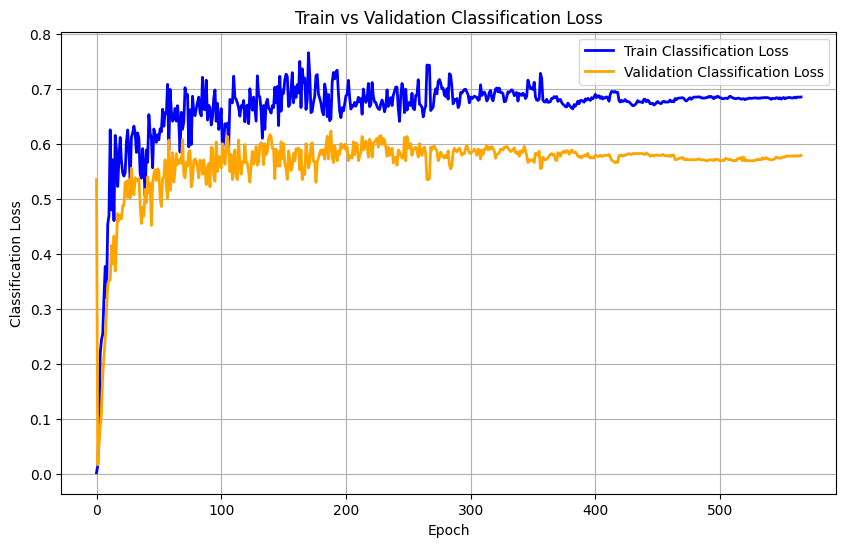

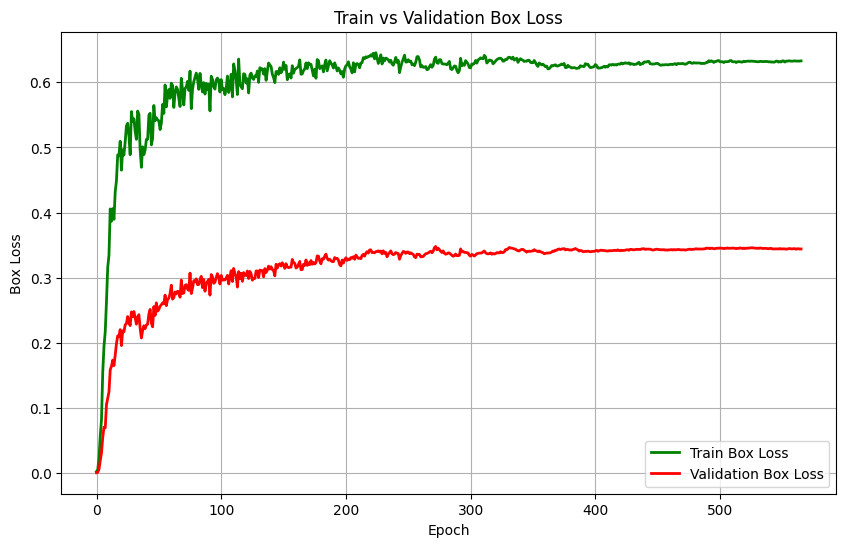

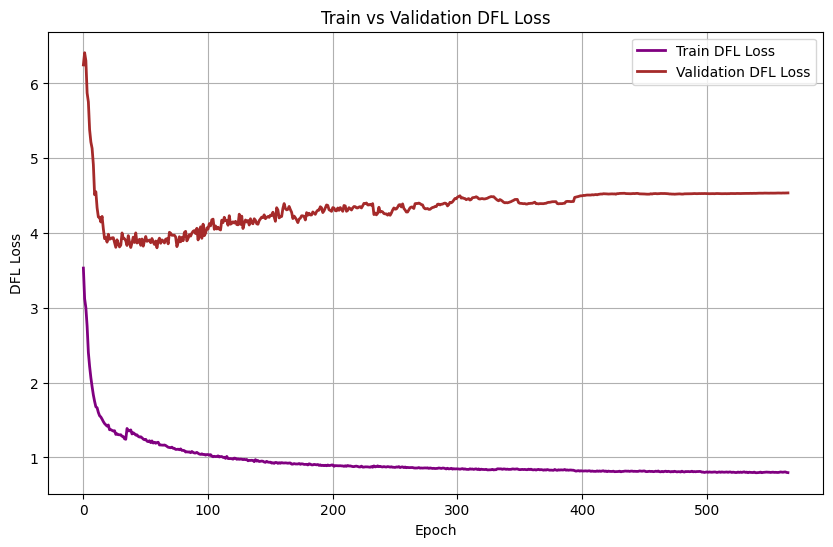

In [ ]:
# Required Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
file_path = '/content/drive/MyDrive/RGELAN/runs/train/fold5/results.csv' # -----> Change this depending on the folder where results are saved <-----
data = pd.read_csv(file_path)

# Plotting train/cls_loss and val/cls_loss
plt.figure(figsize=(10, 6))
plt.plot(data['   metrics/precision'], label='Train Classification Loss', color='blue', linewidth=2)
plt.plot(data['      metrics/recall'], label='Validation Classification Loss', color='orange', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/box_loss and val/box_loss
plt.figure(figsize=(10, 6))
plt.plot(data['     metrics/mAP_0.5'], label='Train Box Loss', color='green', linewidth=2)
plt.plot(data['metrics/mAP_0.5:0.95'], label='Validation Box Loss', color='red', linewidth=2)

# Labels and Title
plt.title('Train vs Validation Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting train/dfl_loss and val/dfl_loss
plt.figure(figsize=(10, 6))
plt.plot(data['      train/dfl_loss'], label='Train DFL Loss', color='purple', linewidth=2)
plt.plot(data['        val/dfl_loss'], label='Validation DFL Loss', color='brown', linewidth=2)

# Labels and Title
plt.title('Train vs Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Load the CSV file
csv_path = '/content/drive/MyDrive/RGELAN/runs/train/fold14/results.csv'
df = pd.read_csv(csv_path)

j=1

sum_values = df.loc[:j, '   metrics/precision'].sum()
max = sum_values/j

for i in range(2, 490):
    sum_values = df.loc[:i, '   metrics/precision'].sum()
    if max < sum_values/i:
        max = sum_values/i
        j=i

print("Best average precision is ",max," and is found on epoch ",j)

Best average precision is  0.9146661658486707  and is found on epoch  489


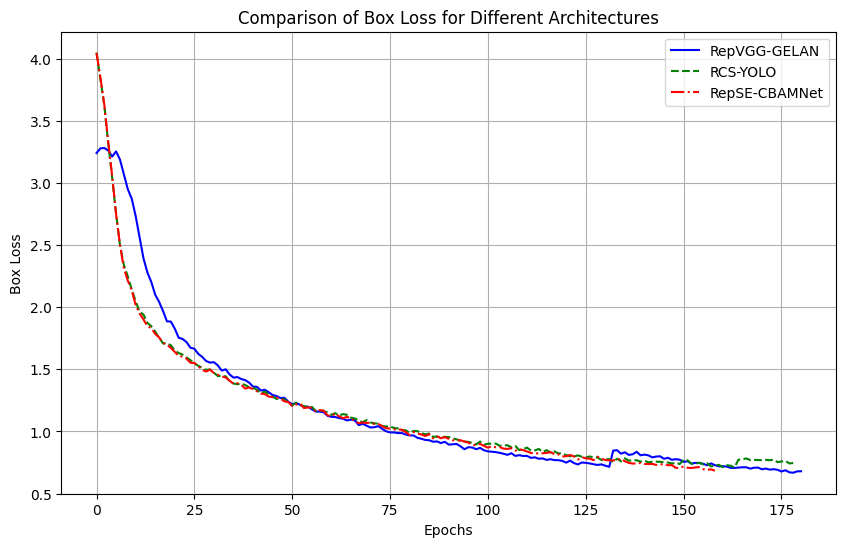

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files
repvgg_gelan_path = '/content/drive/MyDrive/RGELAN/runs/train/exp2/results.csv'
rcs_yolo_path = '/content/drive/MyDrive/RGELAN/runs/train/exp4/results.csv'
repse_cbamnet_path = '/content/drive/MyDrive/RGELAN/runs/train/exp6/results.csv'

# Read the CSV files and extract the 'train/box_loss' column
repvgg_gelan_data = pd.read_csv(repvgg_gelan_path)['      train/box_loss']
rcs_yolo_data = pd.read_csv(rcs_yolo_path)['      train/box_loss']
repse_cbamnet_data = pd.read_csv(repse_cbamnet_path)['      train/box_loss']

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(repvgg_gelan_data, label='RepVGG-GELAN', color='blue', linestyle='-')
plt.plot(rcs_yolo_data, label='RCS-YOLO', color='green', linestyle='--')
plt.plot(repse_cbamnet_data, label='RepSE-CBAMNet', color='red', linestyle='-.')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Box Loss')
plt.title('Comparison of Box Loss for Different Architectures')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
